In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date
import matplotlib.pyplot as plt
from numbers import Number

# credits and installation https://github.com/njchiang/tikhonov.git
from tikhonov.TikhonovRegression import Tikhonov

from sklearn.linear_model import LinearRegression
from scipy import stats

import warnings
warnings.simplefilter(action="ignore", category=(FutureWarning,UserWarning))

# Get pcm-dpc/COVID-19 data

In [2]:
def parse_date(date):
    return datetime.strptime(date[:10] + ' 23:59:00', '%Y-%m-%d %H:%M:%S')

In [3]:
italy_raw_data = pd.read_csv(
    'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv',
    parse_dates=['data'],
    date_parser=parse_date)

In [4]:
italy_raw_data

data stato  ricoverati_con_sintomi  terapia_intensiva  \
0   2020-02-24 23:59:00   ITA                     101                 26   
1   2020-02-25 23:59:00   ITA                     114                 35   
2   2020-02-26 23:59:00   ITA                     128                 36   
3   2020-02-27 23:59:00   ITA                     248                 56   
4   2020-02-28 23:59:00   ITA                     345                 64   
..                  ...   ...                     ...                ...   
294 2020-12-14 23:59:00   ITA                   27765               3095   
295 2020-12-15 23:59:00   ITA                   27342               3003   
296 2020-12-16 23:59:00   ITA                   26897               2926   
297 2020-12-17 23:59:00   ITA                   26427               2855   
298 2020-12-18 23:59:00   ITA                   25769               2819   

     totale_ospedalizzati  isolamento_domiciliare  totale_positivi  \
0                     127                      94              221   
1                     150                     162              311   
2                     164                     221              385   
3                     304                     284              588   
4                     409                     412              821   
..                    ...                     ...              ...   
294                 30860                  644249           675109   
295                 30345                  632968           663313   
296                 29823                  615883           645706   
297                 29282                  606061           635343   
298                 28588                  599210           627798   

     variazione_totale_positivi  nuovi_positivi  dimessi_guariti  deceduti  \
0                             0             221                1         7   
1                            90              93                1        10   
2                            74              78                3        12   
3                           203             250               45        17   
4                           233             238               46        21   
..                          ...             ...              ...       ...   
294                      -10922           12030          1115617     65011   
295                      -11796           14844          1141406     65857   
296                      -17607           17572          1175901     66537   
297                      -10363           18236          1203814     67220   
298                       -7545           17992          1226086     67894   

     casi_da_sospetto_diagnostico  casi_da_screening  totale_casi   tamponi  \
0                             NaN                NaN          229      4324   
1                             NaN                NaN          322      8623   
2                             NaN                NaN          400      9587   
3                             NaN                NaN          650     12014   
4                             NaN                NaN          888     15695   
..                            ...                ...          ...       ...   
294                           NaN                NaN      1855737  24319310   
295                           NaN                NaN      1870576  24483741   
296                           NaN                NaN      1888144  24683230   
297                           NaN                NaN      1906377  24635720   
298                           NaN                NaN      1921778  24815520   

     casi_testati note  ingressi_terapia_intensiva  note_test  note_casi  
0             NaN  NaN                         NaN        NaN        NaN  
1             NaN  NaN                         NaN        NaN        NaN  
2             NaN  NaN                         NaN        NaN        NaN  
3             NaN  NaN                         NaN        NaN        NaN  
4   

In [5]:
italy_raw_data.columns

Index(['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'casi_da_sospetto_diagnostico', 'casi_da_screening',
       'totale_casi', 'tamponi', 'casi_testati', 'note',
       'ingressi_terapia_intensiva', 'note_test', 'note_casi'],
      dtype='object')

In [6]:
TIMESTEPS = len(italy_raw_data.nuovi_positivi)

## Check data consistency

In [7]:
italy_raw_data.describe()

ricoverati_con_sintomi  terapia_intensiva  totale_ospedalizzati  \
count              299.000000         299.000000            299.000000   
mean             11392.026756        1252.578595          12644.608696   
std              11527.761798        1382.172411          12883.257518   
min                101.000000          26.000000            127.000000   
25%               1317.000000         107.000000           1421.500000   
50%               5742.000000         489.000000           6095.000000   
75%              22092.000000        2506.500000          24773.000000   
max              34697.000000        4068.000000          38507.000000   

       isolamento_domiciliare  totale_positivi  variazione_totale_positivi  \
count              299.000000       299.000000                  299.000000   
mean            141532.698997    154177.304348                 2098.919732   
std             230270.882534    240058.400199                 7561.858829   
min                 94.000000       221.000000               -27010.000000   
25%              14681.500000     17169.500000                 -572.000000   
50%              41511.000000     48593.000000                  327.000000   
75%              81709.000000    105830.000000                 1990.000000   
max             767867.000000    805947.000000                33418.000000   

       nuovi_positivi  dimessi_guariti      deceduti  \
count      299.000000     2.990000e+02    299.000000   
mean      6436.856187     2.317121e+05  32296.672241   
std      10148.903392     2.394865e+05  14274.379390   
min         78.000000     1.000000e+00      7.000000   
25%        381.500000     1.010270e+05  30298.000000   
50%       1494.000000     1.976280e+05  35082.000000   
75%       5414.000000     2.322975e+05  35994.000000   
max      40902.000000     1.226086e+06  67894.000000   

       casi_da_sospetto_diagnostico  casi_da_screening   totale_casi  \
count                    162.000000         162.000000  2.990000e+02   
mean                  345928.216049      132707.308642  4.181862e+05   
std                   217856.889628      176156.446171  4.684616e+05   
min                        0.000000           0.000000  2.290000e+02   
25%                   223237.500000       25369.750000  2.177265e+05   
50%                   236256.500000       50768.500000  2.450320e+05   
75%                   341673.000000      138410.250000  3.264575e+05   
max                   988470.000000      653140.000000  1.921778e+06   

            tamponi  casi_testati  ingressi_terapia_intensiva  note_test  \
count  2.990000e+02  2.440000e+02                   16.000000        0.0   
mean   8.053223e+06  5.880722e+06                  184.625000        NaN   
std    6.882326e+06  3.793491e+06                   30.447496        NaN   
min    4.324000e+03  9.353100e+05                  138.000000        NaN   
25%    2.479648e+06  2.980152e+06                  152.000000        NaN   
50%    6.354730e+06  4.530642e+06                  191.500000        NaN   
75%    1.181423e+07  8.216200e+06                  199.500000        NaN   
max    2.481552e+07  1.424674e+07                  251.000000        NaN   

       note_casi  
count        0.0  
mean         NaN  
std          NaN  
min          NaN  
25%          NaN  
50%          NaN  
75%          NaN  
max          NaN

In [8]:
(italy_raw_data.totale_positivi 
 + italy_raw_data.dimessi_guariti 
 + italy_raw_data.deceduti 
 == italy_raw_data.totale_casi).all()

False

In [9]:
italy_raw_data.loc[
    italy_raw_data.totale_positivi 
    + italy_raw_data.dimessi_guariti 
    + italy_raw_data.deceduti 
    != italy_raw_data.totale_casi,
    ['data', 'totale_positivi', 'dimessi_guariti', 'deceduti', 'totale_casi']
]

data  totale_positivi  dimessi_guariti  deceduti  \
254 2020-11-04 23:59:00           443235           307378     39747   

     totale_casi  
254       790377

In [10]:
italy_raw_data.loc[
    italy_raw_data.ricoverati_con_sintomi
    + italy_raw_data.terapia_intensiva
    != italy_raw_data.totale_ospedalizzati,
    ['data', 'ricoverati_con_sintomi', 'terapia_intensiva', 'totale_ospedalizzati']    
]

data  ricoverati_con_sintomi  terapia_intensiva  \
1 2020-02-25 23:59:00                     114                 35   

   totale_ospedalizzati  
1                   150

In [11]:
italy_raw_data.loc[
    italy_raw_data.totale_ospedalizzati 
    + italy_raw_data.isolamento_domiciliare 
    != italy_raw_data.totale_positivi,
    ['data', 'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi']    
]

data  totale_ospedalizzati  isolamento_domiciliare  \
1 2020-02-25 23:59:00                   150                     162   

   totale_positivi  
1              311

In [12]:
italy_raw_data.loc[
    italy_raw_data.ricoverati_con_sintomi
    + italy_raw_data.terapia_intensiva
    + italy_raw_data.isolamento_domiciliare
    != italy_raw_data.totale_positivi,
    ['data', 'ricoverati_con_sintomi', 'terapia_intensiva', 'isolamento_domiciliare', 
     'totale_positivi']    
]

Empty DataFrame
Columns: [data, ricoverati_con_sintomi, terapia_intensiva, isolamento_domiciliare, totale_positivi]
Index: []

In [13]:
italy_raw_data.loc[
    italy_raw_data.ricoverati_con_sintomi
    + italy_raw_data.terapia_intensiva
    + italy_raw_data.isolamento_domiciliare
    + italy_raw_data.dimessi_guariti 
    + italy_raw_data.deceduti 
    != italy_raw_data.totale_casi,
    ['data', 'ricoverati_con_sintomi', 'terapia_intensiva', 'isolamento_domiciliare', 
     'dimessi_guariti', 'deceduti', 'totale_casi']    
]

data  ricoverati_con_sintomi  terapia_intensiva  \
254 2020-11-04 23:59:00                   22116               2292   

     isolamento_domiciliare  dimessi_guariti  deceduti  totale_casi  
254                  418827           307378     39747       790377

# ipotesi sbagliata: totale positivi da sospetto diagnostico

In [14]:
italy_raw_data['totale_positivi_da_sospetto_diagnostico'] = \
(
    italy_raw_data.casi_da_sospetto_diagnostico
    - italy_raw_data.dimessi_guariti 
    - italy_raw_data.deceduti
)

In [15]:
italy_raw_data.totale_positivi_da_sospetto_diagnostico.mask(
    italy_raw_data.casi_da_sospetto_diagnostico.isna(), 
    inplace=True
)

In [16]:
italy_raw_data[italy_raw_data.totale_positivi_da_sospetto_diagnostico < 0].shape

(110, 21)

# nuovi casi

In [17]:
italy_raw_data['nuovi_casi_da_sospetto_diagnostico'] = \
    (italy_raw_data.casi_da_sospetto_diagnostico -
     italy_raw_data.casi_da_sospetto_diagnostico.shift(1))

In [18]:
italy_raw_data['nuovi_casi_da_screening'] = \
    (italy_raw_data.casi_da_screening -
     italy_raw_data.casi_da_screening.shift(1))

In [19]:
italy_raw_data.loc[:,['nuovi_positivi', 'nuovi_casi_da_sospetto_diagnostico', 'nuovi_casi_da_screening']]

nuovi_positivi  nuovi_casi_da_sospetto_diagnostico  \
0               221                                 NaN   
1                93                                 NaN   
2                78                                 NaN   
3               250                                 NaN   
4               238                                 NaN   
..              ...                                 ...   
294           12030                                 NaN   
295           14844                                 NaN   
296           17572                                 NaN   
297           18236                                 NaN   
298           17992                                 NaN   

     nuovi_casi_da_screening  
0                        NaN  
1                        NaN  
2                        NaN  
3                        NaN  
4                        NaN  
..                       ...  
294                      NaN  
295                      NaN  
296                      NaN  
297                      NaN  
298                      NaN  

[299 rows x 3 columns]

# Fix NaN data

In [20]:
italy_raw_data.casi_da_sospetto_diagnostico.fillna(0, inplace=True)
italy_raw_data.casi_da_screening.fillna(0, inplace=True)
italy_raw_data.totale_positivi_da_sospetto_diagnostico.fillna(0, inplace=True)

# Get Italy: Mobility COVID-19 data

In [21]:
# first url (now 404):
#url = 'https://data.humdata.org/dataset/40a9ea9e-0edb-49f7-a440-6aee3015961b/resource/d5384152-f198-466d-9be8-7f250c4edae9/download/average_network_degree_by_province_20200321_allusers.csv'
# dataset V1 up to march 27:
#url = 'https://ndownloader.figshare.com/files/22613561'
# dataset V2 up to june 26:
url = 'https://data.humdata.org/dataset/40a9ea9e-0edb-49f7-a440-6aee3015961b/resource/04aaa605-2755-4696-9a29-ab9ce3c59c62/download/average_network_degree_2020_01_18_2020_06_26.csv'



italy_mobility_data = pd.read_csv(url)

italy_mobility_data = italy_mobility_data.drop(labels='Unnamed: 0', axis=1)

italy_mobility_data = pd.melt(
    italy_mobility_data, 
    id_vars=['COD_PROV', 'SIGLA', 'NAME_PROV'], 
    value_name='network_degree',
    var_name='date'
)

italy_mobility_data['date'] = pd.to_datetime(italy_mobility_data['date'])

italy_mobility_data = \
    italy_mobility_data.groupby(by=['date']).mean().reset_index().drop(labels='COD_PROV', axis=1)

In [22]:
italy_mobility_data

date  network_degree
0   2020-01-18        0.050819
1   2020-01-19        0.045722
2   2020-01-20        0.046177
3   2020-01-21        0.048892
4   2020-01-22        0.047412
..         ...             ...
156 2020-06-22        0.038817
157 2020-06-23        0.039950
158 2020-06-24        0.036669
159 2020-06-25        0.040877
160 2020-06-26        0.040809

[161 rows x 2 columns]

In [23]:
MOBILITY_TIMESTEPS = len(italy_mobility_data.network_degree)

# Smoothing data

## Function `smooth_data`

Data are smoothed by fitting a series to represent the derivative of the original signal and then integrating it back to the original signal, which results in a smoothed one.


Given $y$ the signal to be smoothed, we search for the differential signal $\omega$ such that:
$$y = X\cdot \omega$$
where $X$ is the matrix representing the integration operator:
$$X = \begin{bmatrix} 
1 & 0 & 0 & ... & 0 \\
1 & 1 & 0 & ... & 0 \\
1 & 1 & 1 & ... & 0 \\
... & ... & ... & ...  & ... \\
1 & 1 & ... & ... & 1 \\
\end{bmatrix}
$$

$\omega$ is obtained by minimizing the following cost function:
$$F(\omega) = \left\|y - X\cdot\omega\right\|^2 +\alpha^2 \left\|\Gamma\cdot\omega\right\|^2$$

Hence the derivative is fitted using a Ridge regresssion with a generalized Tikhonov regularization factor:
- $y$: the original signal
- $X$: we choose the the integration matrix, to force the fitted signal to be the derivative one
- $\Gamma$: the Tikhonov regularizaztion matrix, choosen as the second derivative operator
- $\alpha$: the regularization factor

The regularization factor penalizes the noise, forcing the derivative to be a smoothed signal.
Once the derivative is fitted, then the original signal is reconstructed by appliyng again the integral matrix to the differentiated signal. The bigger the alpha factor, the smoother the signal.

## Function `smooth_differentiate`
As a by product of this procedure, we can apply the fit to cumulative data to obtain the daily variations, eg to obtain the "nuovi_positivi" from the "totale_casi"

## Function `filter_matrices`
Integral and derivative matrices are just the matrices that applyed to a signal produce the integral or the derivative. They are built via `np.tril`, `np.ones` and `np.eye`.


In [24]:
def filter_matrices(timesteps):
    
    integral_matrix = np.tri(timesteps,timesteps,0)

    derivative_matrix = np.eye(timesteps,timesteps)-(np.tri(timesteps,timesteps,-1)-np.tri(timesteps,timesteps,-2))

    second_derivative_matrix = np.dot(derivative_matrix, derivative_matrix)
    
    return integral_matrix, second_derivative_matrix 


In [25]:
ALPHA = 100.

INTEGRAL_MATRIX, SECOND_DERIVATIVE_MATRIX = filter_matrices(TIMESTEPS)

GAMMA = SECOND_DERIVATIVE_MATRIX

In [26]:
def smooth_data(y, X, L, alpha):    
    tic = Tikhonov(alpha=alpha)
    tic.fit(y=y, X=X, L=L)
    print('TIC R2: {}'.format(tic.score(X=X, y=y)))
    
    return tic.predict(X)

def smooth_differentiate(y, X, L, alpha):
    tic = Tikhonov(alpha=alpha)
    tic.fit(y=y, X=X, L=L)
    print('TIC R2: {}'.format(tic.score(X=X, y=y)))
    
    return tic.coef_

In [27]:
italy_raw_data['tamponi_giornalieri'] = (italy_raw_data.tamponi - italy_raw_data.tamponi.shift(1)).fillna(0)
italy_raw_data['tamponi_giornalieri_smoothed'] = smooth_differentiate(italy_raw_data.tamponi, 
                                                                      X=INTEGRAL_MATRIX,
                                                                      L=GAMMA,
                                                                      alpha=ALPHA)

TIC R2: 0.99999201710841


In [28]:
italy_raw_data['dimessi_guariti_giornalieri'] = (italy_raw_data.dimessi_guariti - italy_raw_data.dimessi_guariti.shift(1)).fillna(0)
italy_raw_data['dimessi_guariti_giornalieri_smoothed'] = smooth_differentiate(italy_raw_data.dimessi_guariti,
                                                                              X=INTEGRAL_MATRIX,
                                                                              L=GAMMA,
                                                                              alpha=ALPHA)

TIC R2: 0.9999346770436132


In [29]:
italy_raw_data['deceduti_giornalieri'] = (italy_raw_data.deceduti - italy_raw_data.deceduti.shift(1)).fillna(0)
italy_raw_data['deceduti_giornalieri_smoothed'] = smooth_differentiate(italy_raw_data.deceduti,
                                                                       X=INTEGRAL_MATRIX,
                                                                       L=GAMMA,
                                                                       alpha=200.)

TIC R2: 0.9999877871947714


In [30]:
italy_raw_data['nuovi_positivi_smoothed'] = smooth_differentiate(italy_raw_data.totale_casi,
                                                                 X=INTEGRAL_MATRIX,
                                                                 L=GAMMA,
                                                                 alpha=ALPHA)

TIC R2: 0.9999875502114492


In [31]:
italy_raw_data['nuovi_casi_da_sospetto_diagnostico_smoothed'] = \
    smooth_differentiate(italy_raw_data.casi_da_sospetto_diagnostico,
                         X=INTEGRAL_MATRIX,
                         L=GAMMA,
                         alpha=ALPHA)

TIC R2: 0.963943253135142


In [32]:
italy_raw_data['nuovi_casi_da_screening_smoothed'] = \
    smooth_differentiate(italy_raw_data.casi_da_screening,
                         X=INTEGRAL_MATRIX,
                         L=GAMMA,
                         alpha=ALPHA)

TIC R2: 0.9603764988697151


In [33]:
filter_columns = [
    'ricoverati_con_sintomi', 'terapia_intensiva',
    'isolamento_domiciliare', 'totale_positivi', 'totale_positivi_da_sospetto_diagnostico',
    'dimessi_guariti', 'deceduti', 'tamponi', 'totale_casi', 'casi_da_screening',
    'casi_da_sospetto_diagnostico'
]

for col in filter_columns:
    italy_raw_data[col+'_smoothed'] = smooth_data(y=italy_raw_data[col],
                                              X=INTEGRAL_MATRIX,
                                              L=GAMMA,
                                              alpha=ALPHA)

TIC R2: 0.999806497819238
TIC R2: 0.9998813215398481
TIC R2: 0.9998722052564607
TIC R2: 0.9998831093083718
TIC R2: 0.667779946182206
TIC R2: 0.9999346770436132
TIC R2: 0.9999884201212357
TIC R2: 0.99999201710841
TIC R2: 0.9999875502114492
TIC R2: 0.9603764988697151
TIC R2: 0.963943253135142


In [34]:
MOBILITIY_INTEGRAL_MATRIX, MOBILITY_SECOND_DERIVATIVE_MATRIX = filter_matrices(MOBILITY_TIMESTEPS)

In [35]:
italy_mobility_data['network_degree_smoothed'] = smooth_data(italy_mobility_data.network_degree,
                                                             X=MOBILITIY_INTEGRAL_MATRIX,
                                                             L=MOBILITY_SECOND_DERIVATIVE_MATRIX,
                                                             alpha=20.)

TIC R2: 0.9494433317815328


# Plot everything

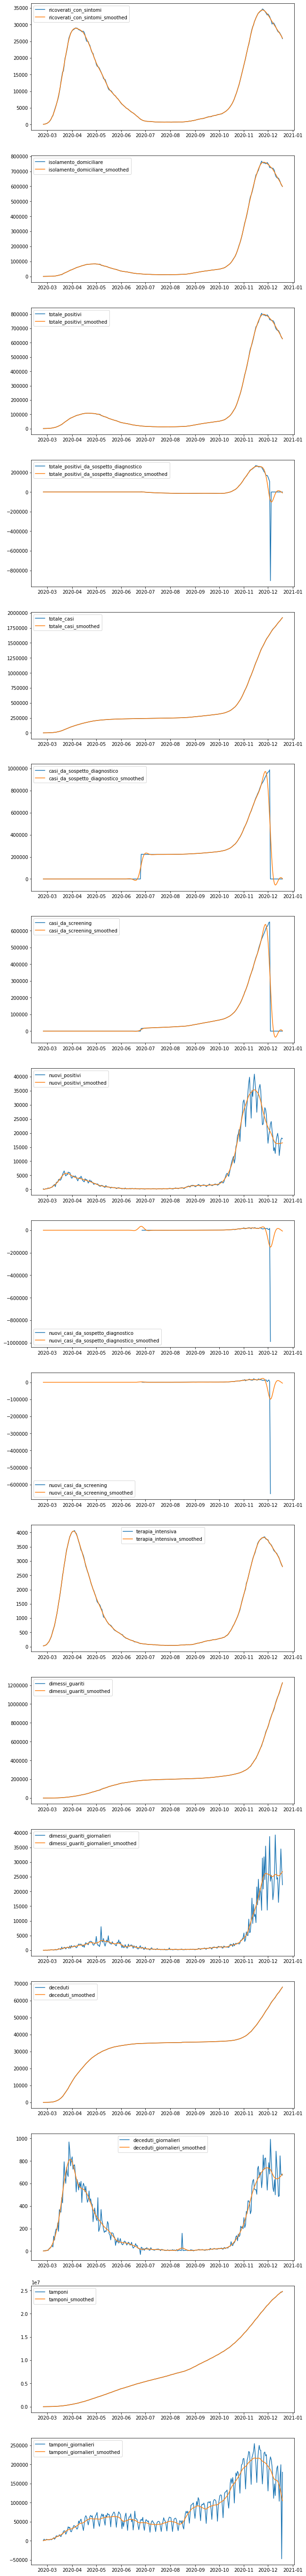

In [36]:
plotcols = [
    'ricoverati_con_sintomi', 
    'isolamento_domiciliare', 'totale_positivi', 'totale_positivi_da_sospetto_diagnostico',
    'totale_casi', 'casi_da_sospetto_diagnostico', 'casi_da_screening',
    'nuovi_positivi', 'nuovi_casi_da_sospetto_diagnostico', 'nuovi_casi_da_screening',  
    'terapia_intensiva', 
    'dimessi_guariti', 'dimessi_guariti_giornalieri',
    'deceduti', 'deceduti_giornalieri',
    'tamponi', 'tamponi_giornalieri', 
]

fig, axs = plt.subplots(len(plotcols), figsize=(10,100))
for col in plotcols:
    sbp = axs[plotcols.index(col)]
    sbp.plot(italy_raw_data.data, italy_raw_data[col], label=col)
    sbp.plot(italy_raw_data.data, italy_raw_data[col+'_smoothed'], label=col+'_smoothed')
    sbp.legend(fontsize=10)

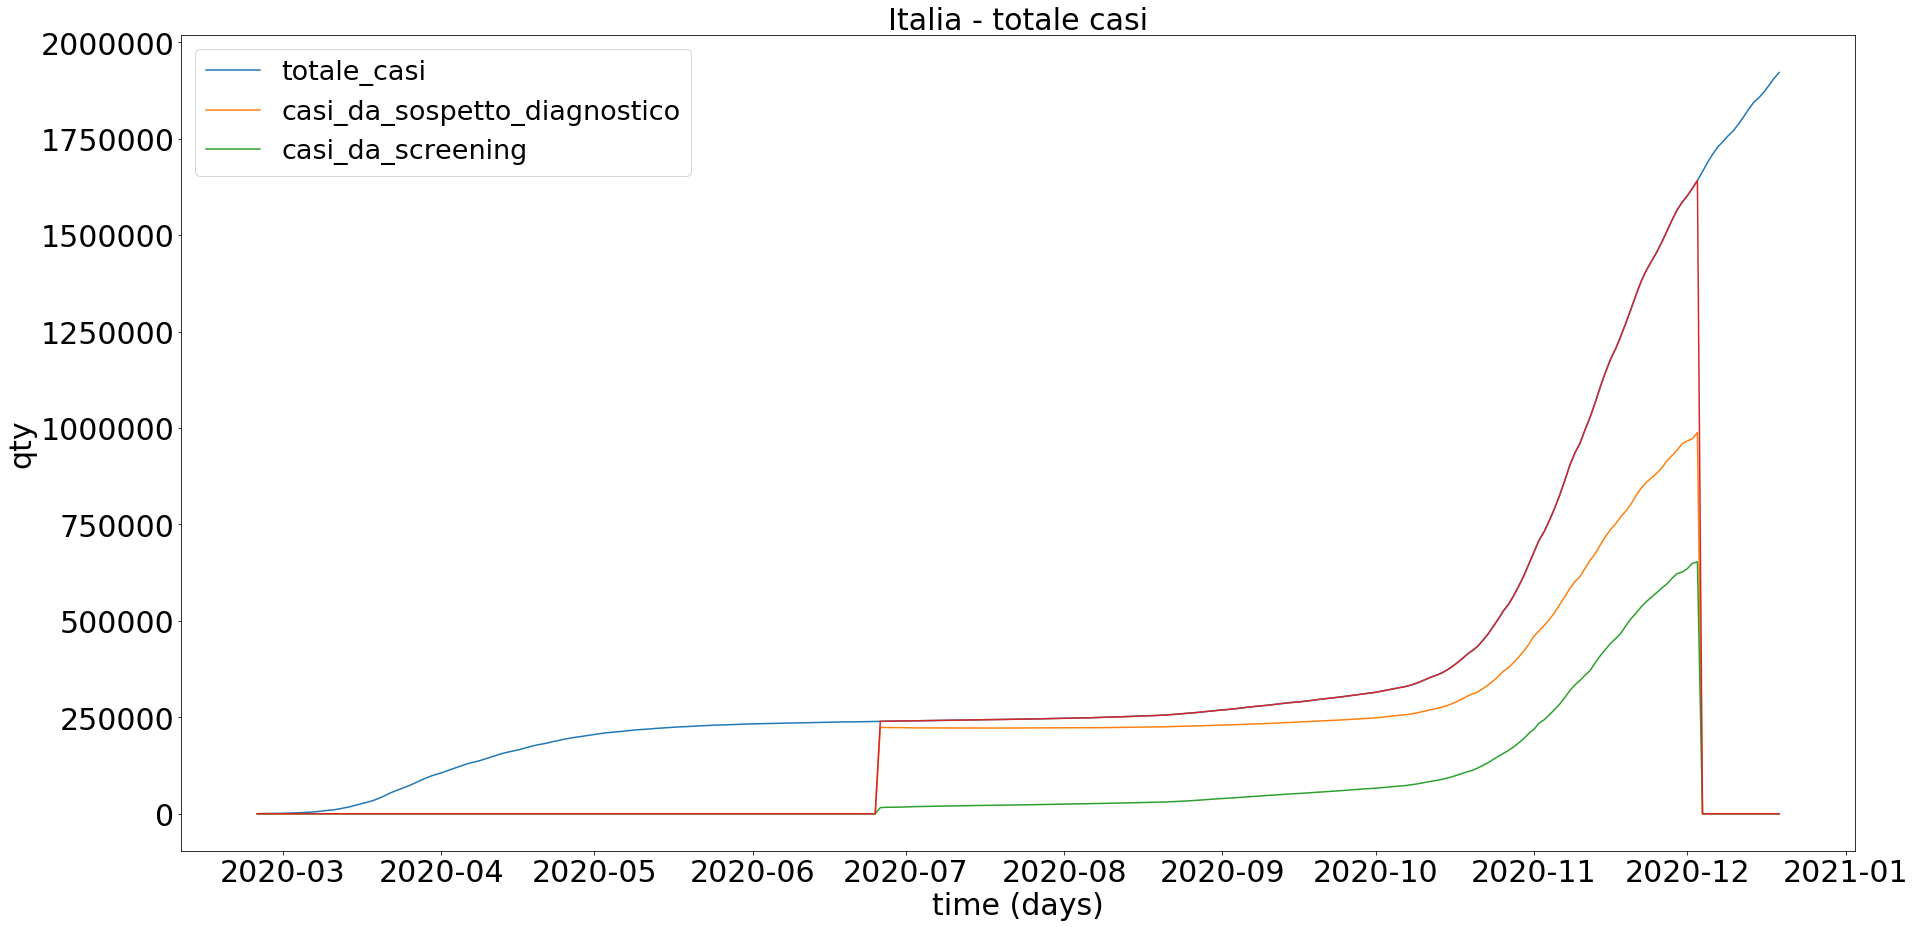

In [37]:
fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Italia - totale casi', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('qty', fontsize=30)
#ax1.set_ylim(0,50)
#ax1.set_xlim(datetime(2020,2,24),datetime(2020,6,20))

ax1.plot(italy_raw_data.data, italy_raw_data.totale_casi, label='totale_casi')
ax1.plot(italy_raw_data.data, italy_raw_data.casi_da_sospetto_diagnostico, label='casi_da_sospetto_diagnostico')
ax1.plot(italy_raw_data.data, italy_raw_data.casi_da_screening, label='casi_da_screening')
ax1.plot(italy_raw_data.data, italy_raw_data.casi_da_sospetto_diagnostico+italy_raw_data.casi_da_screening, label='')


#ax1.plot(italy_raw_data.data, italy_raw_data.terapia_intensiva_smoothed_Dt_fit, label='tempo di raddoppio terapie intensive', color='blue')
ax1.legend(fontsize=27, loc='upper left')


In [38]:
def growth(v,rate, zerosteps, steps):
    assert(zerosteps < steps)
    if isinstance(rate, Number):
        ratefunc = lambda s: rate
    elif callable(rate):
        ratefunc = rate
    else:
        raise Exception("rate must be either a number or a function")
    for s in range(steps):
        if s <= zerosteps:
            yield 0.
        else:
            r = ratefunc(s)
            v = v * (1. + r)
            yield v

In [39]:
pd.Series(
    growth(
        v = 40.,
        rate = lambda s: 0.03 * np.sin(2*np.pi*s / 28.) + 0.07, 
        zerosteps = TIMESTEPS/2, 
        steps = TIMESTEPS
    )
)

0           0.000000
1           0.000000
2           0.000000
3           0.000000
4           0.000000
           ...      
294    751019.453620
295    798577.288866
296    844083.008085
297    887380.504227
298    928683.679068
Length: 299, dtype: float64

In [40]:
italy_raw_data['casi_perturbazione_r07'] = pd.Series(growth(40.,0.07, TIMESTEPS/2, TIMESTEPS))

italy_raw_data['casi_da_sospetto_diagnostico_perturbati_r07'] = (
    italy_raw_data.casi_da_sospetto_diagnostico + italy_raw_data.casi_perturbazione_r07
)

italy_raw_data['casi_da_sospetto_diagnostico_perturbati_r07_smoothed'] = smooth_data(
    y=italy_raw_data.casi_da_sospetto_diagnostico_perturbati_r07,
    X=INTEGRAL_MATRIX,
    L=GAMMA,
    alpha=ALPHA)


italy_raw_data['casi_perturbazione_r08'] = pd.Series(growth(40.,0.08, TIMESTEPS/2, TIMESTEPS))

italy_raw_data['casi_da_sospetto_diagnostico_perturbati_r08'] = (
    italy_raw_data.casi_da_sospetto_diagnostico + italy_raw_data.casi_perturbazione_r08
)

italy_raw_data['casi_da_sospetto_diagnostico_perturbati_r08_smoothed'] = smooth_data(
    y=italy_raw_data.casi_da_sospetto_diagnostico_perturbati_r08,
    X=INTEGRAL_MATRIX,
    L=GAMMA,
    alpha=ALPHA)


italy_raw_data['casi_perturbazione_rsin'] = pd.Series(
    growth(
        v = 40.,
        rate = lambda s: 0.07 * np.sin(2*np.pi*s / 7.) + 0.07, 
        zerosteps = TIMESTEPS/2, 
        steps = TIMESTEPS
    )
)

italy_raw_data['casi_da_sospetto_diagnostico_perturbati_rsin'] = (
    italy_raw_data.casi_da_sospetto_diagnostico + italy_raw_data.casi_perturbazione_rsin
)

italy_raw_data['casi_da_sospetto_diagnostico_perturbati_rsin_smoothed'] = smooth_data(
    y=italy_raw_data.casi_da_sospetto_diagnostico_perturbati_rsin,
    X=INTEGRAL_MATRIX,
    L=GAMMA,
    alpha=ALPHA)

italy_raw_data['casi_perturbazione_const_50k'] = pd.Series(TIMESTEPS*[50000])

italy_raw_data['casi_da_sospetto_diagnostico_perturbati_const_50k'] = (
    italy_raw_data.casi_da_sospetto_diagnostico + italy_raw_data.casi_perturbazione_const_50k
)

italy_raw_data['casi_da_sospetto_diagnostico_perturbati_const_50k_smoothed'] = smooth_data(
    y=italy_raw_data.casi_da_sospetto_diagnostico_perturbati_const_50k,
    X=INTEGRAL_MATRIX,
    L=GAMMA,
    alpha=ALPHA)

italy_raw_data['casi_perturbazione_lin_10k'] = np.linspace(0, TIMESTEPS*10000, TIMESTEPS)

italy_raw_data['casi_da_sospetto_diagnostico_perturbati_lin_10k'] = (
    italy_raw_data.casi_da_sospetto_diagnostico + italy_raw_data.casi_perturbazione_lin_10k
)

italy_raw_data['casi_da_sospetto_diagnostico_perturbati_lin_10k_smoothed'] = smooth_data(
    y=italy_raw_data.casi_da_sospetto_diagnostico_perturbati_lin_10k,
    X=INTEGRAL_MATRIX,
    L=GAMMA,
    alpha=ALPHA)

TIC R2: 0.9764362598977168
TIC R2: 0.994815464811657
TIC R2: 0.9742351441386314
TIC R2: 0.963943253135142
TIC R2: 0.9981679935511495


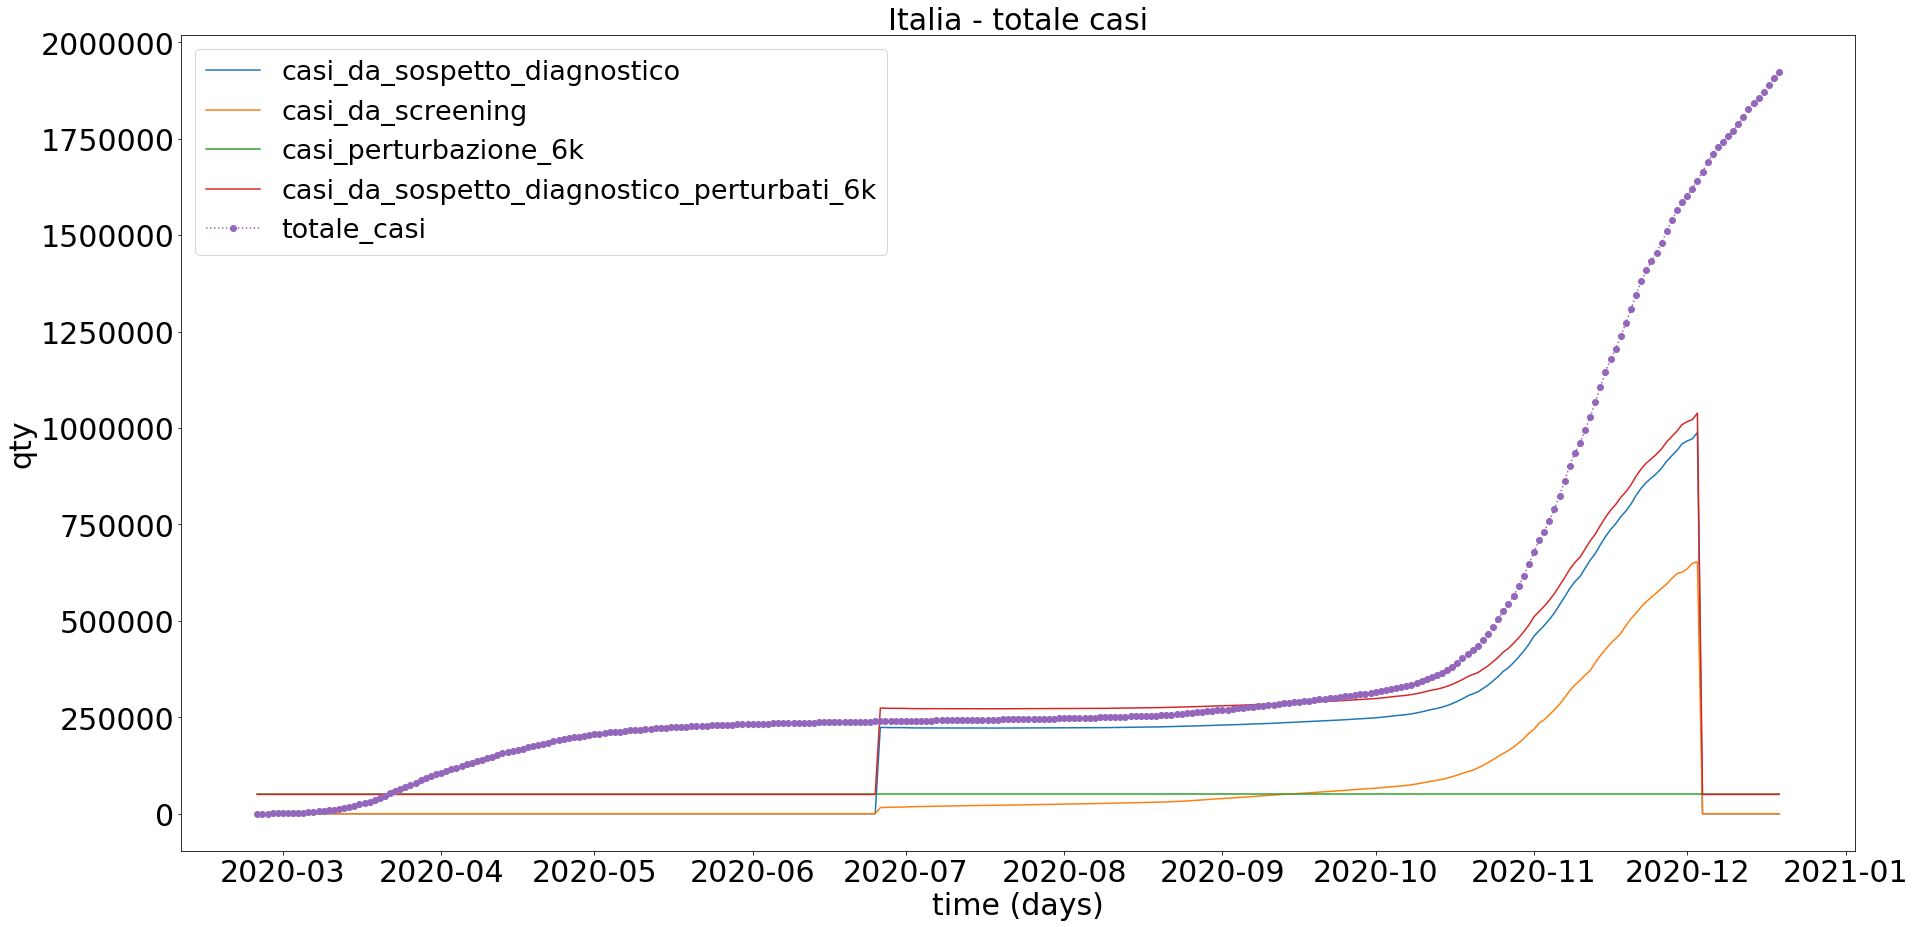

In [41]:
fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Italia - totale casi', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('qty', fontsize=30)
#ax1.set_ylim(0,50)
#ax1.set_xlim(datetime(2020,10,1),datetime(2020,11,10))

ax1.plot(italy_raw_data.data, italy_raw_data.casi_da_sospetto_diagnostico, label='casi_da_sospetto_diagnostico')
ax1.plot(italy_raw_data.data, italy_raw_data.casi_da_screening, label='casi_da_screening')
#ax1.plot(italy_raw_data.data, italy_raw_data.casi_da_sospetto_diagnostico+italy_raw_data.casi_da_screening, label='')

#ax1.plot(italy_raw_data.data, italy_raw_data.casi_perturbazione_r07, label='casi_perturbazione_r07')
#ax1.plot(italy_raw_data.data, italy_raw_data.casi_perturbazione_r08, label='casi_perturbazione_r08')
#ax1.plot(italy_raw_data.data, italy_raw_data.casi_da_sospetto_diagnostico_perturbati_r07, label='casi_da_sospetto_diagnostico_perturbati_r07')
#ax1.plot(italy_raw_data.data, italy_raw_data.casi_da_sospetto_diagnostico_perturbati_r08, label='casi_da_sospetto_diagnostico_perturbati_r08')

#ax1.plot(italy_raw_data.data, italy_raw_data.casi_perturbazione_rsin, label='casi_perturbazione_rsin')
#ax1.plot(italy_raw_data.data, italy_raw_data.casi_da_sospetto_diagnostico_perturbati_rsin, label='casi_da_sospetto_diagnostico_perturbati_rsin')

ax1.plot(italy_raw_data.data, italy_raw_data.casi_perturbazione_const_50k, label='casi_perturbazione_6k')
ax1.plot(italy_raw_data.data, italy_raw_data.casi_da_sospetto_diagnostico_perturbati_const_50k, label='casi_da_sospetto_diagnostico_perturbati_6k')

ax1.plot(italy_raw_data.data, italy_raw_data.totale_casi, label='totale_casi', linestyle=':', marker='o')


#ax1.plot(italy_raw_data.data, italy_raw_data.terapia_intensiva_smoothed_Dt_fit, label='tempo di raddoppio terapie intensive', color='blue')
ax1.legend(fontsize=27, loc='upper left')


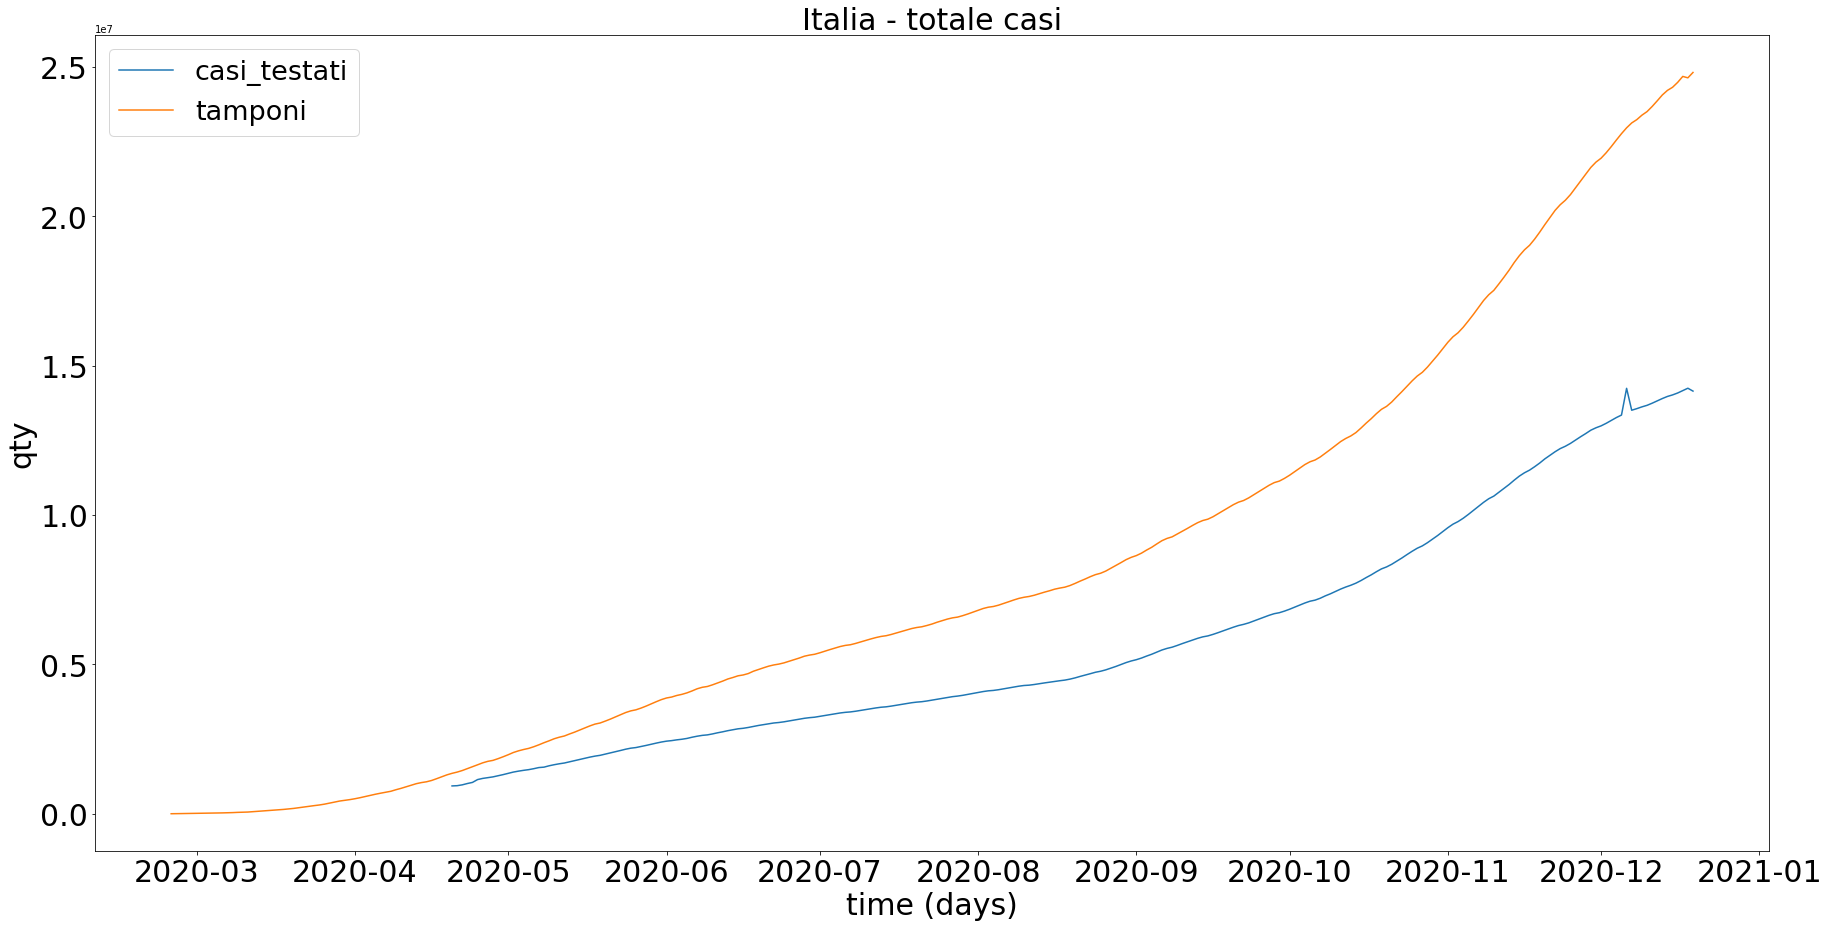

In [42]:
fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Italia - totale casi', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('qty', fontsize=30)
#ax1.set_ylim(0,50)
#ax1.set_xlim(datetime(2020,6,22),datetime(2020,7,1))

ax1.plot(italy_raw_data.data, italy_raw_data.casi_testati, label='casi_testati')
ax1.plot(italy_raw_data.data, italy_raw_data.tamponi, label='tamponi')


#ax1.plot(italy_raw_data.data, italy_raw_data.terapia_intensiva_smoothed_Dt_fit, label='tempo di raddoppio terapie intensive', color='blue')
ax1.legend(fontsize=27, loc='upper left')


In [43]:
italy_raw_data.loc[(italy_raw_data.data > datetime(2020,6,22)) & (italy_raw_data.data < datetime(2020,7,1)),['data','casi_da_screening']]

data  casi_da_screening
119 2020-06-22 23:59:00                0.0
120 2020-06-23 23:59:00                0.0
121 2020-06-24 23:59:00                0.0
122 2020-06-25 23:59:00            15801.0
123 2020-06-26 23:59:00            16521.0
124 2020-06-27 23:59:00            16874.0
125 2020-06-28 23:59:00            17038.0
126 2020-06-29 23:59:00            17182.0
127 2020-06-30 23:59:00            17677.0

# Compute the mortality (draft and probably wrong)

In [44]:
def compute_average_ratio(x, y):
    r = x / y
    return np.mean(r), np.std(r)

In [45]:
def compute_offset(s_preceeding, s_following, start = -20, interval = 10):
    crosscorrs =[]
    for shift in range(start, interval):
        crosscorrs.append(
            s_preceeding.corr(s_following.shift(shift))
        )

    return start + crosscorrs.index(max(crosscorrs)), crosscorrs

In [46]:
offset_deceduti_to_nuovi_positivi, cc = compute_offset(
    italy_raw_data.nuovi_positivi_smoothed, italy_raw_data.deceduti_giornalieri_smoothed
)

In [47]:
offset_deceduti_to_nuovi_positivi

-15

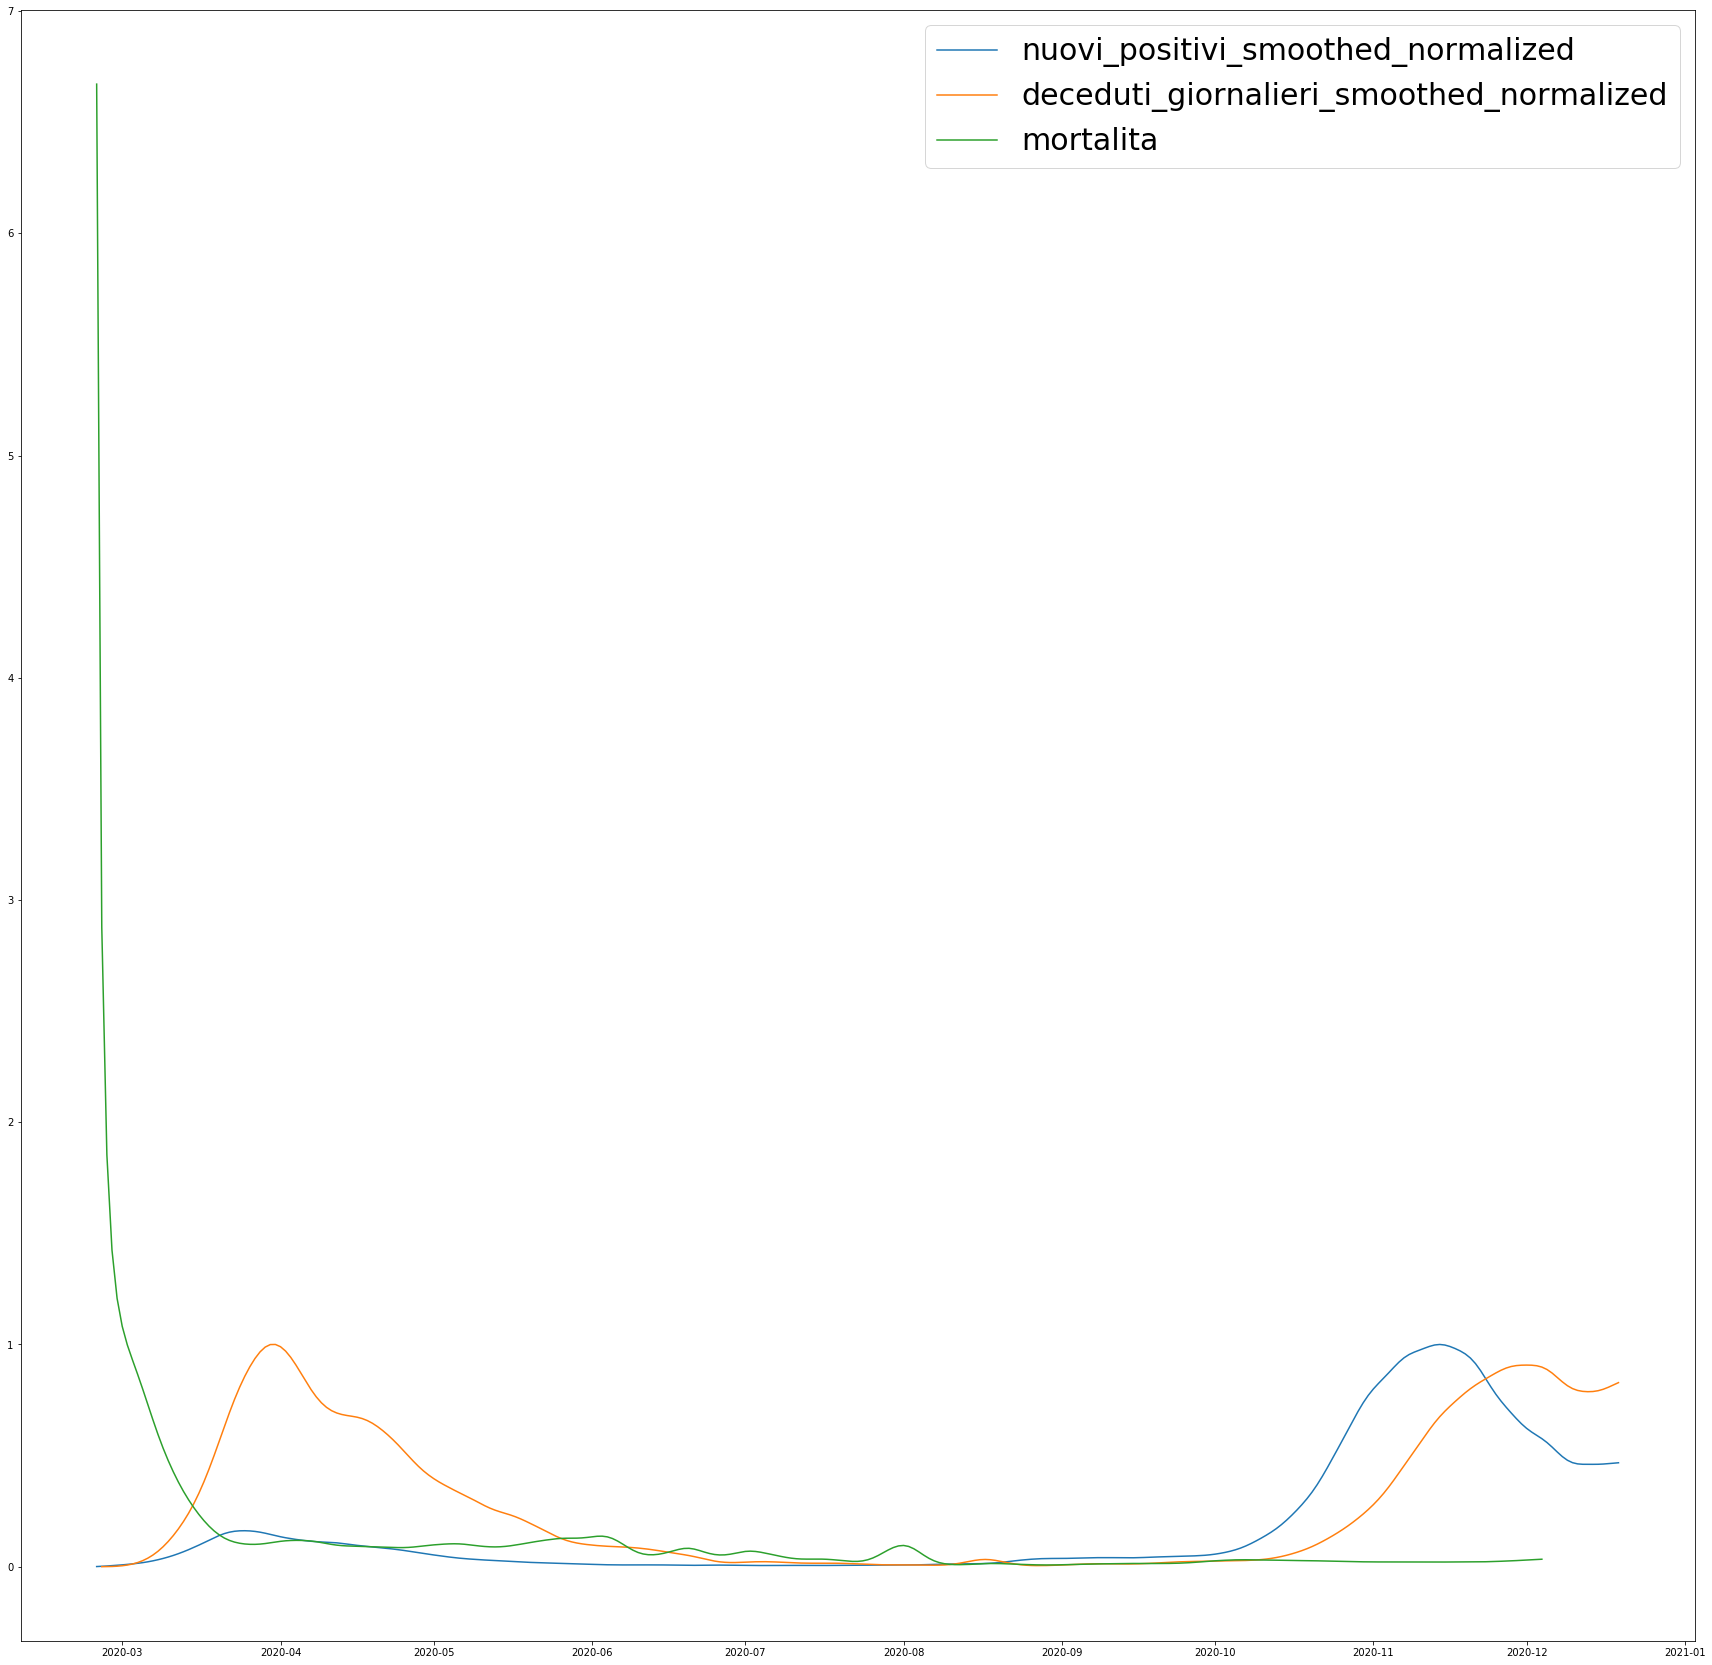

In [48]:
plt.figure(figsize=(30,30))
plt.plot(
    italy_raw_data.data, 
    italy_raw_data.nuovi_positivi_smoothed/italy_raw_data.nuovi_positivi_smoothed.max(), 
    label='nuovi_positivi_smoothed_normalized'
)
plt.plot(
    italy_raw_data.data, 
    italy_raw_data.deceduti_giornalieri_smoothed.shift()/italy_raw_data.deceduti_giornalieri_smoothed.max(), 
    label='deceduti_giornalieri_smoothed_normalized'
)
plt.plot(
    italy_raw_data.data, 
    italy_raw_data.deceduti_giornalieri_smoothed.shift(offset_deceduti_to_nuovi_positivi)/italy_raw_data.nuovi_positivi_smoothed, 
    label='mortalita'
)
plt.legend(fontsize=30)


In [49]:
m, m_e = compute_average_ratio(italy_raw_data.deceduti_giornalieri_smoothed.shift(offset_deceduti_to_nuovi_positivi), italy_raw_data.nuovi_positivi_smoothed)

In [50]:
print(m, m_e)

0.1353441764248876 0.46994590138773973


# Diffusion

## average totale_positivi over previous x days

In [51]:
def moving_average(series, window):
    return series.rolling(window).mean()

## totale_positivi in x days

In [52]:
(italy_raw_data.totale_positivi 
 + italy_raw_data.dimessi_guariti 
 + italy_raw_data.deceduti 
 == italy_raw_data.totale_casi).all()

False

In [53]:
(
      italy_raw_data.totale_positivi.shift(1)
    - italy_raw_data.dimessi_guariti_giornalieri.shift(0)
    - italy_raw_data.deceduti_giornalieri.shift(0)
    + italy_raw_data.nuovi_positivi.shift(0)
) - italy_raw_data.totale_positivi.shift(0)

0         NaN
1         0.0
2         0.0
3         0.0
4         0.0
        ...  
294       5.0
295       5.0
296       4.0
297       3.0
298    2591.0
Length: 299, dtype: float64

In [54]:
def get_totale_positivi_in_window(x, window, smoothed=False):
    postfix = ''
    if smoothed:
        postfix = '_smoothed'
    return (
        (
              x['totale_positivi' + postfix].shift(window + 1)
            - x['dimessi_guariti_giornalieri' + postfix].shift(window)
            - x['deceduti_giornalieri' + postfix].shift(window)
        ) + 
        (
              x['totale_casi' + postfix].shift(0)
            - x['totale_casi' + postfix].shift(window)
        )
    )

In [55]:
get_totale_positivi_in_window(italy_raw_data, 14, smoothed=True)

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
           ...     
294    1.012923e+06
295    1.003329e+06
296    9.938609e+05
297    9.846918e+05
298    9.759123e+05
Length: 299, dtype: float64

In [56]:
italy_raw_data['totale_positivi_in_14'] = get_totale_positivi_in_window(italy_raw_data, 14)
italy_raw_data['totale_positivi_in_14_smoothed'] = get_totale_positivi_in_window(italy_raw_data, 14, smoothed=True)

italy_raw_data['totale_positivi_in_28'] = get_totale_positivi_in_window(italy_raw_data, 28)
italy_raw_data['totale_positivi_in_28_smoothed'] = get_totale_positivi_in_window(italy_raw_data, 28, smoothed=True)


No handles with labels found to put in legend.


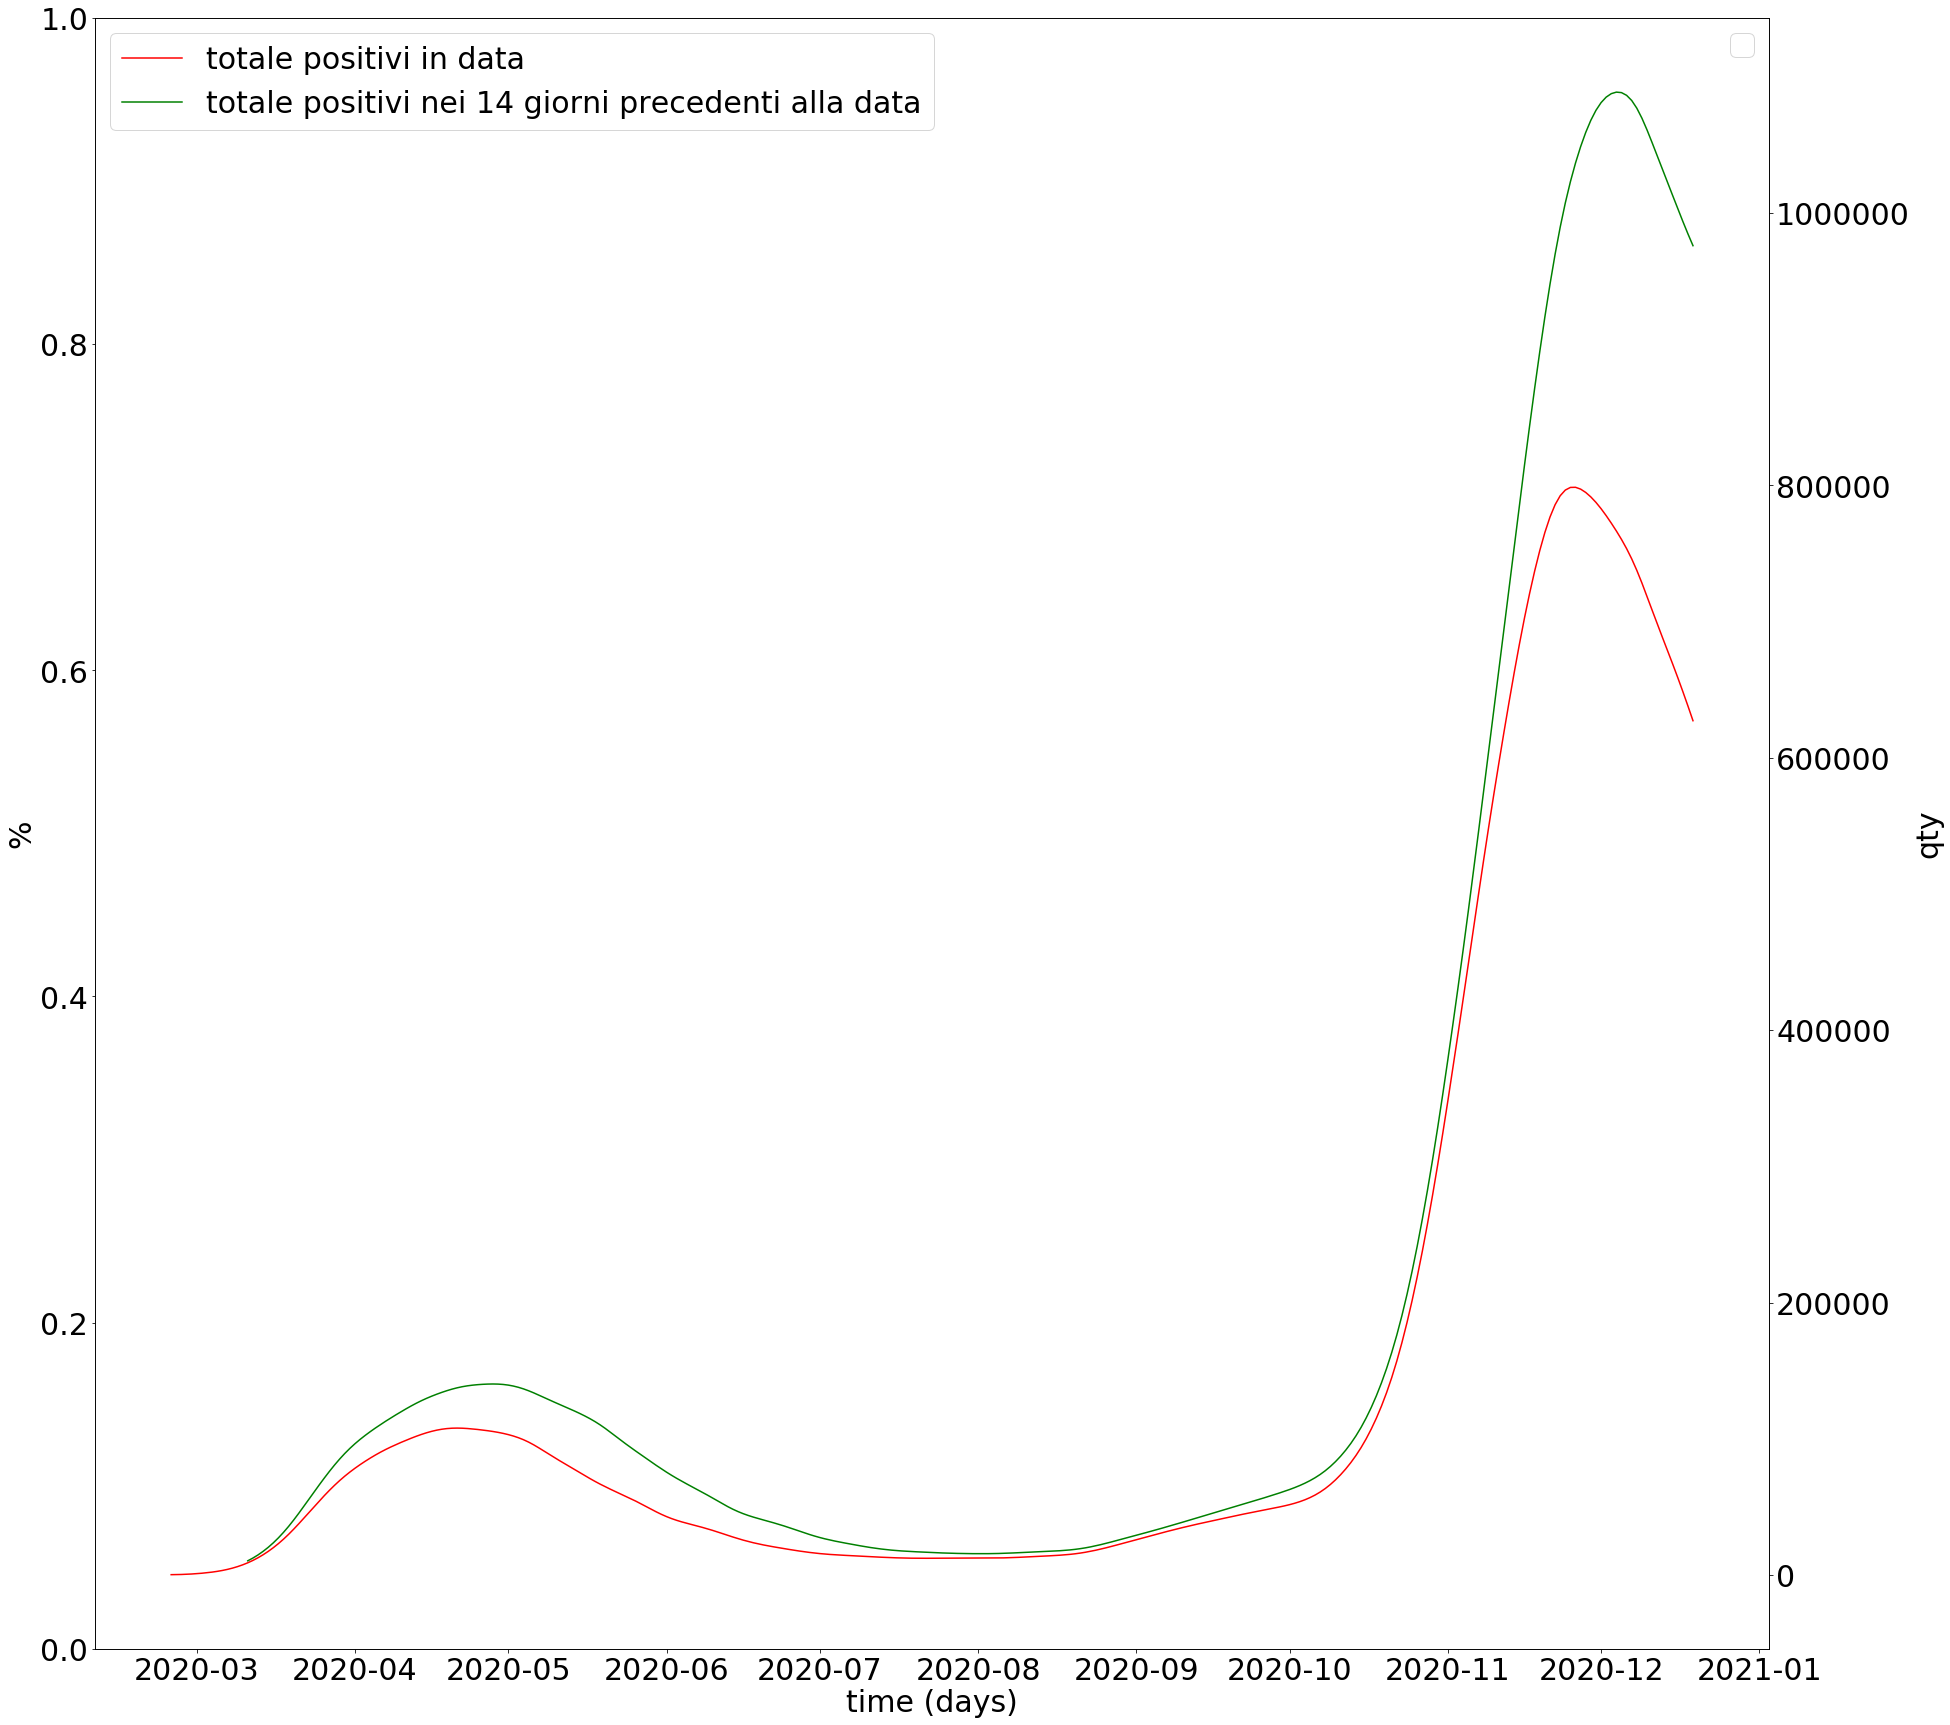

In [57]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,30))

ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('%', fontsize=30)

#ax1.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14_smoothed*100, label='diffusione_su_totale_positivi_in_14_smoothed', color='orange')
#ax1.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14*100, label='diffusione_su_totale_positivi_in_14', color='blue')
ax1.legend(fontsize=30)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('qty', fontsize=30)
ax2.tick_params(axis='y', labelsize=30)

ax2.plot(italy_raw_data.data, italy_raw_data.totale_positivi_smoothed, label='totale positivi in data', color='red')
ax2.plot(italy_raw_data.data, italy_raw_data.totale_positivi_in_14_smoothed, label='totale positivi nei 14 giorni precedenti alla data', color='green')

ax2.legend(fontsize=30)

In [58]:

italy_raw_data['diffusione_su_totale_positivi_in_14'] = italy_raw_data.nuovi_positivi/italy_raw_data.totale_positivi_in_14

italy_raw_data['diffusione_su_totale_positivi_in_14_smoothed'] = italy_raw_data.nuovi_positivi_smoothed/italy_raw_data.totale_positivi_in_14_smoothed

In [59]:

italy_raw_data['diffusione_terapia_intensiva_su_totale_positivi_in_14'] = italy_raw_data.terapia_intensiva/italy_raw_data.totale_positivi_in_14

italy_raw_data['diffusione_terapia_intensiva_su_totale_positivi_in_14_smoothed'] = italy_raw_data.terapia_intensiva_smoothed /italy_raw_data.totale_positivi_in_14_smoothed

In [60]:

italy_raw_data['diffusione_deceduti_su_totale_positivi_in_14'] = italy_raw_data.deceduti_giornalieri/italy_raw_data.totale_positivi_in_14

italy_raw_data['diffusione_deceduti_su_totale_positivi_in_14_smoothed'] = italy_raw_data.deceduti_giornalieri_smoothed /italy_raw_data.totale_positivi_in_14_smoothed

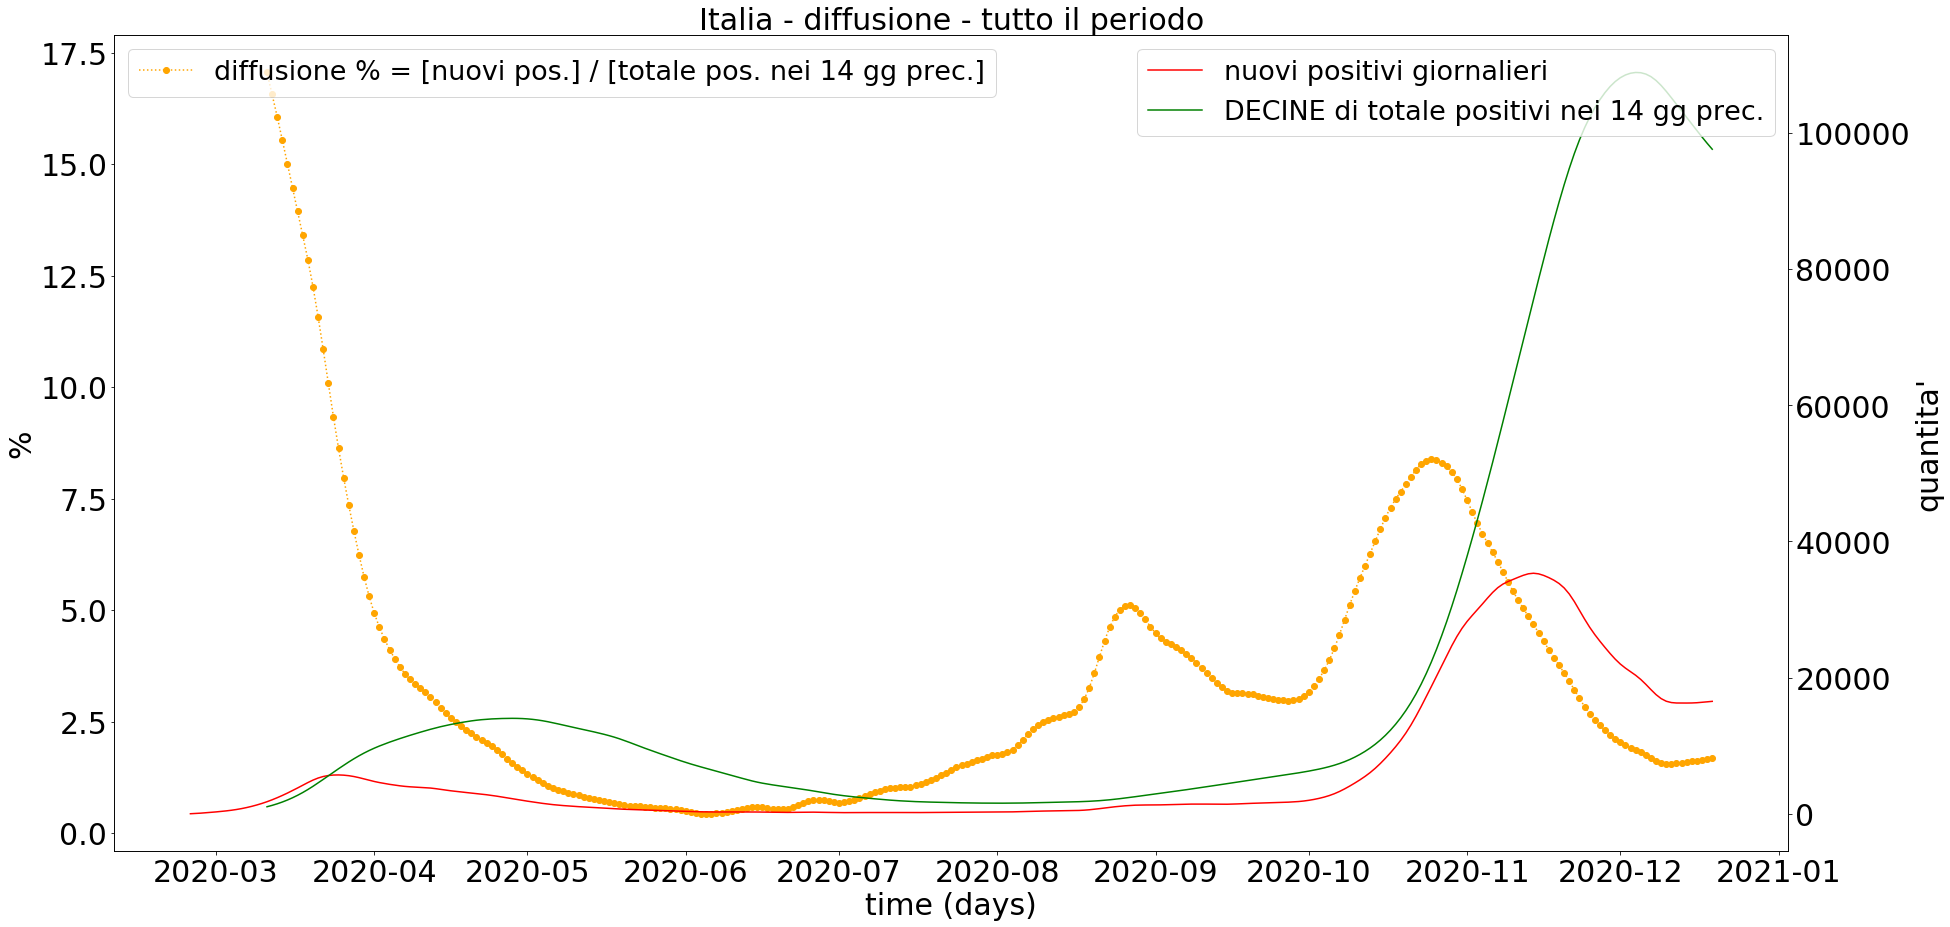

In [61]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Italia - diffusione - tutto il periodo', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('%', fontsize=30)

ax1.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14_smoothed*100, label='diffusione % = [nuovi pos.] / [totale pos. nei 14 gg prec.]', color='orange', linestyle=':', marker='o')
#ax1.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14*100, label='diffusione_su_totale_positivi_in_14', color='blue')
ax1.legend(fontsize=27, loc='upper left')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('quantita\'', fontsize=30)
ax2.tick_params(axis='y', labelsize=30)

ax2.plot(italy_raw_data.data, italy_raw_data.nuovi_positivi_smoothed, label='nuovi positivi giornalieri', color='red')
ax2.plot(italy_raw_data.data, italy_raw_data.totale_positivi_in_14_smoothed/10, label='DECINE di totale positivi nei 14 gg prec.', color='green')

ax2.legend(fontsize=27,loc='upper right')

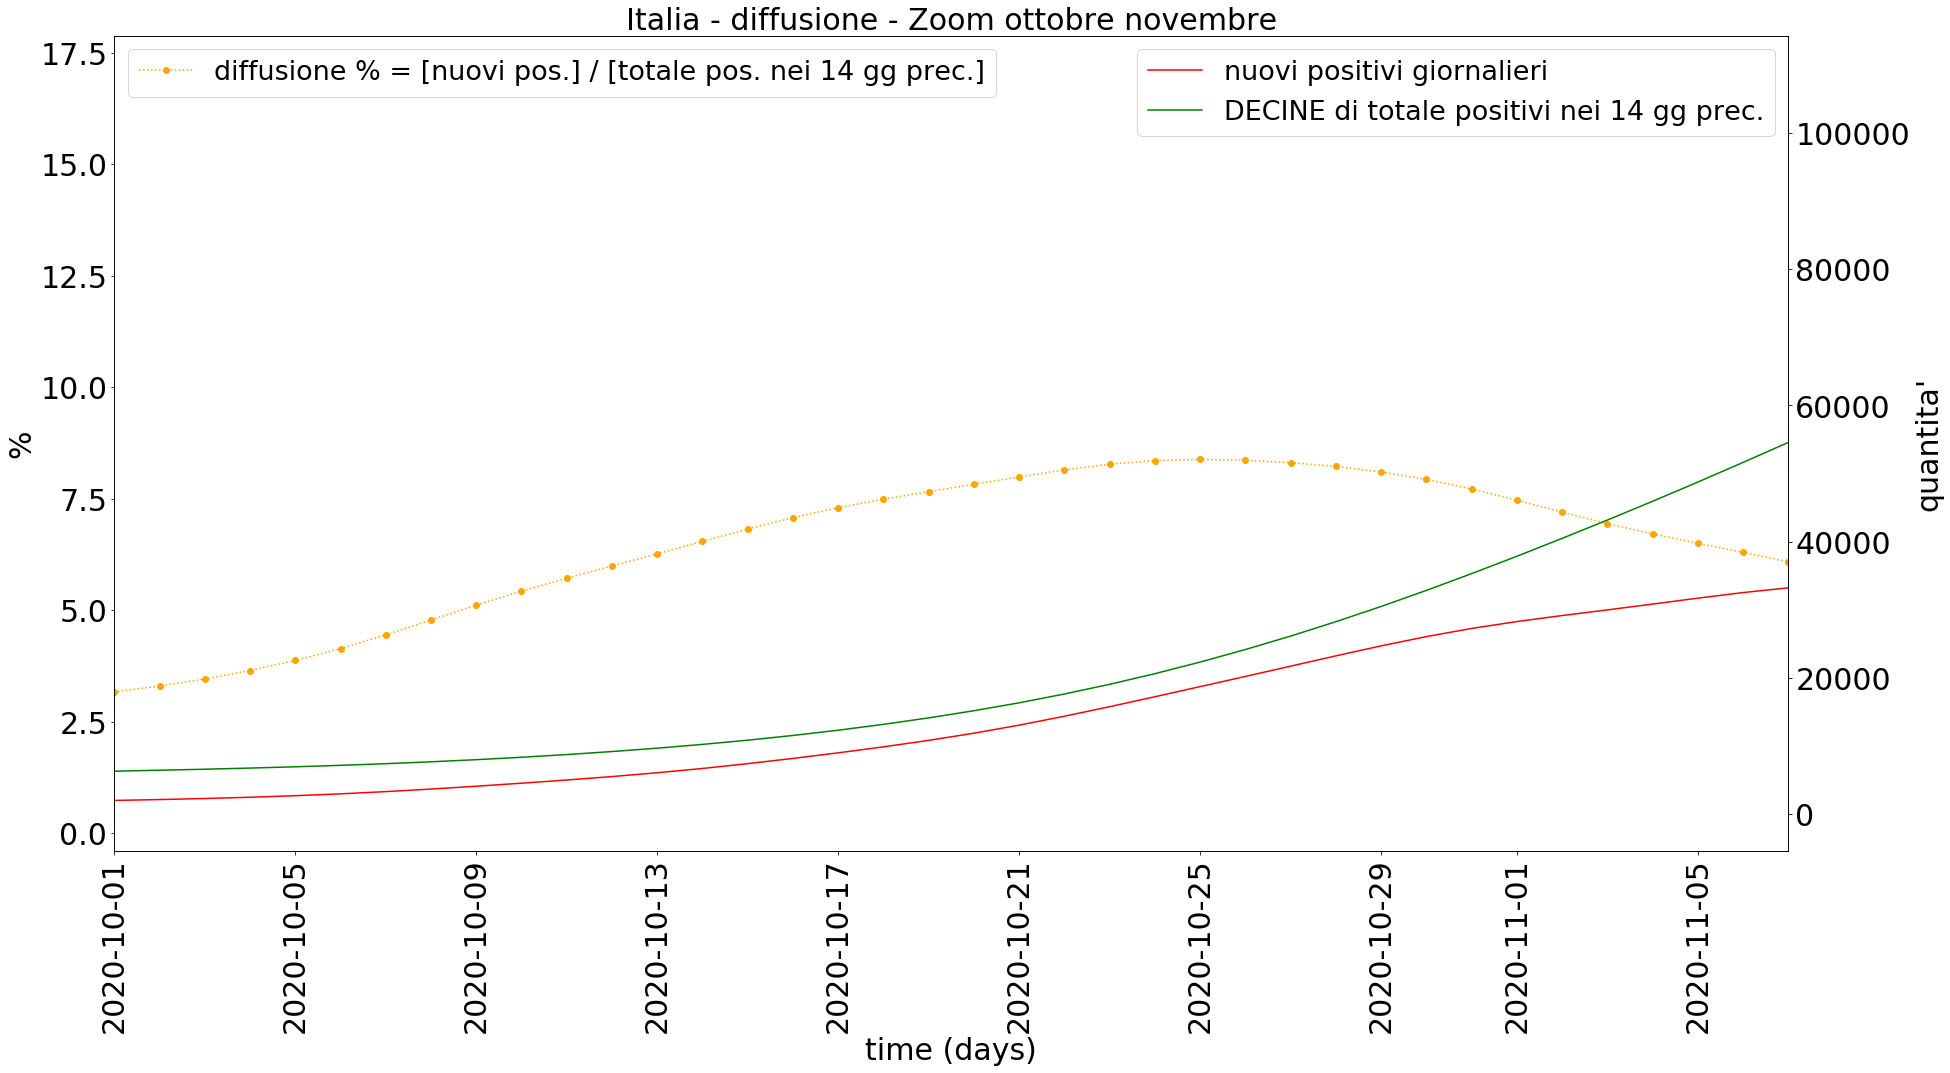

In [62]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Italia - diffusione - Zoom ottobre novembre', fontsize=30)

ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.tick_params(axis='x', labelsize=30,labelrotation=90)

ax1.set_ylabel('%', fontsize=30)
ax1.set_xlim(datetime(2020,10,1),datetime(2020,11,7))

ax1.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14_smoothed*100, label='diffusione % = [nuovi pos.] / [totale pos. nei 14 gg prec.]', color='orange', linestyle=':', marker='o')
#ax1.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14*100, label='diffusione_su_totale_positivi_in_14', color='blue')
ax1.legend(fontsize=27, loc='upper left')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('quantita\'', fontsize=30)
ax2.tick_params(axis='y', labelsize=30)

ax2.plot(italy_raw_data.data, italy_raw_data.nuovi_positivi_smoothed, label='nuovi positivi giornalieri', color='red')
ax2.plot(italy_raw_data.data, italy_raw_data.totale_positivi_in_14_smoothed/10, label='DECINE di totale positivi nei 14 gg prec.', color='green')

ax2.legend(fontsize=27,loc='upper right')





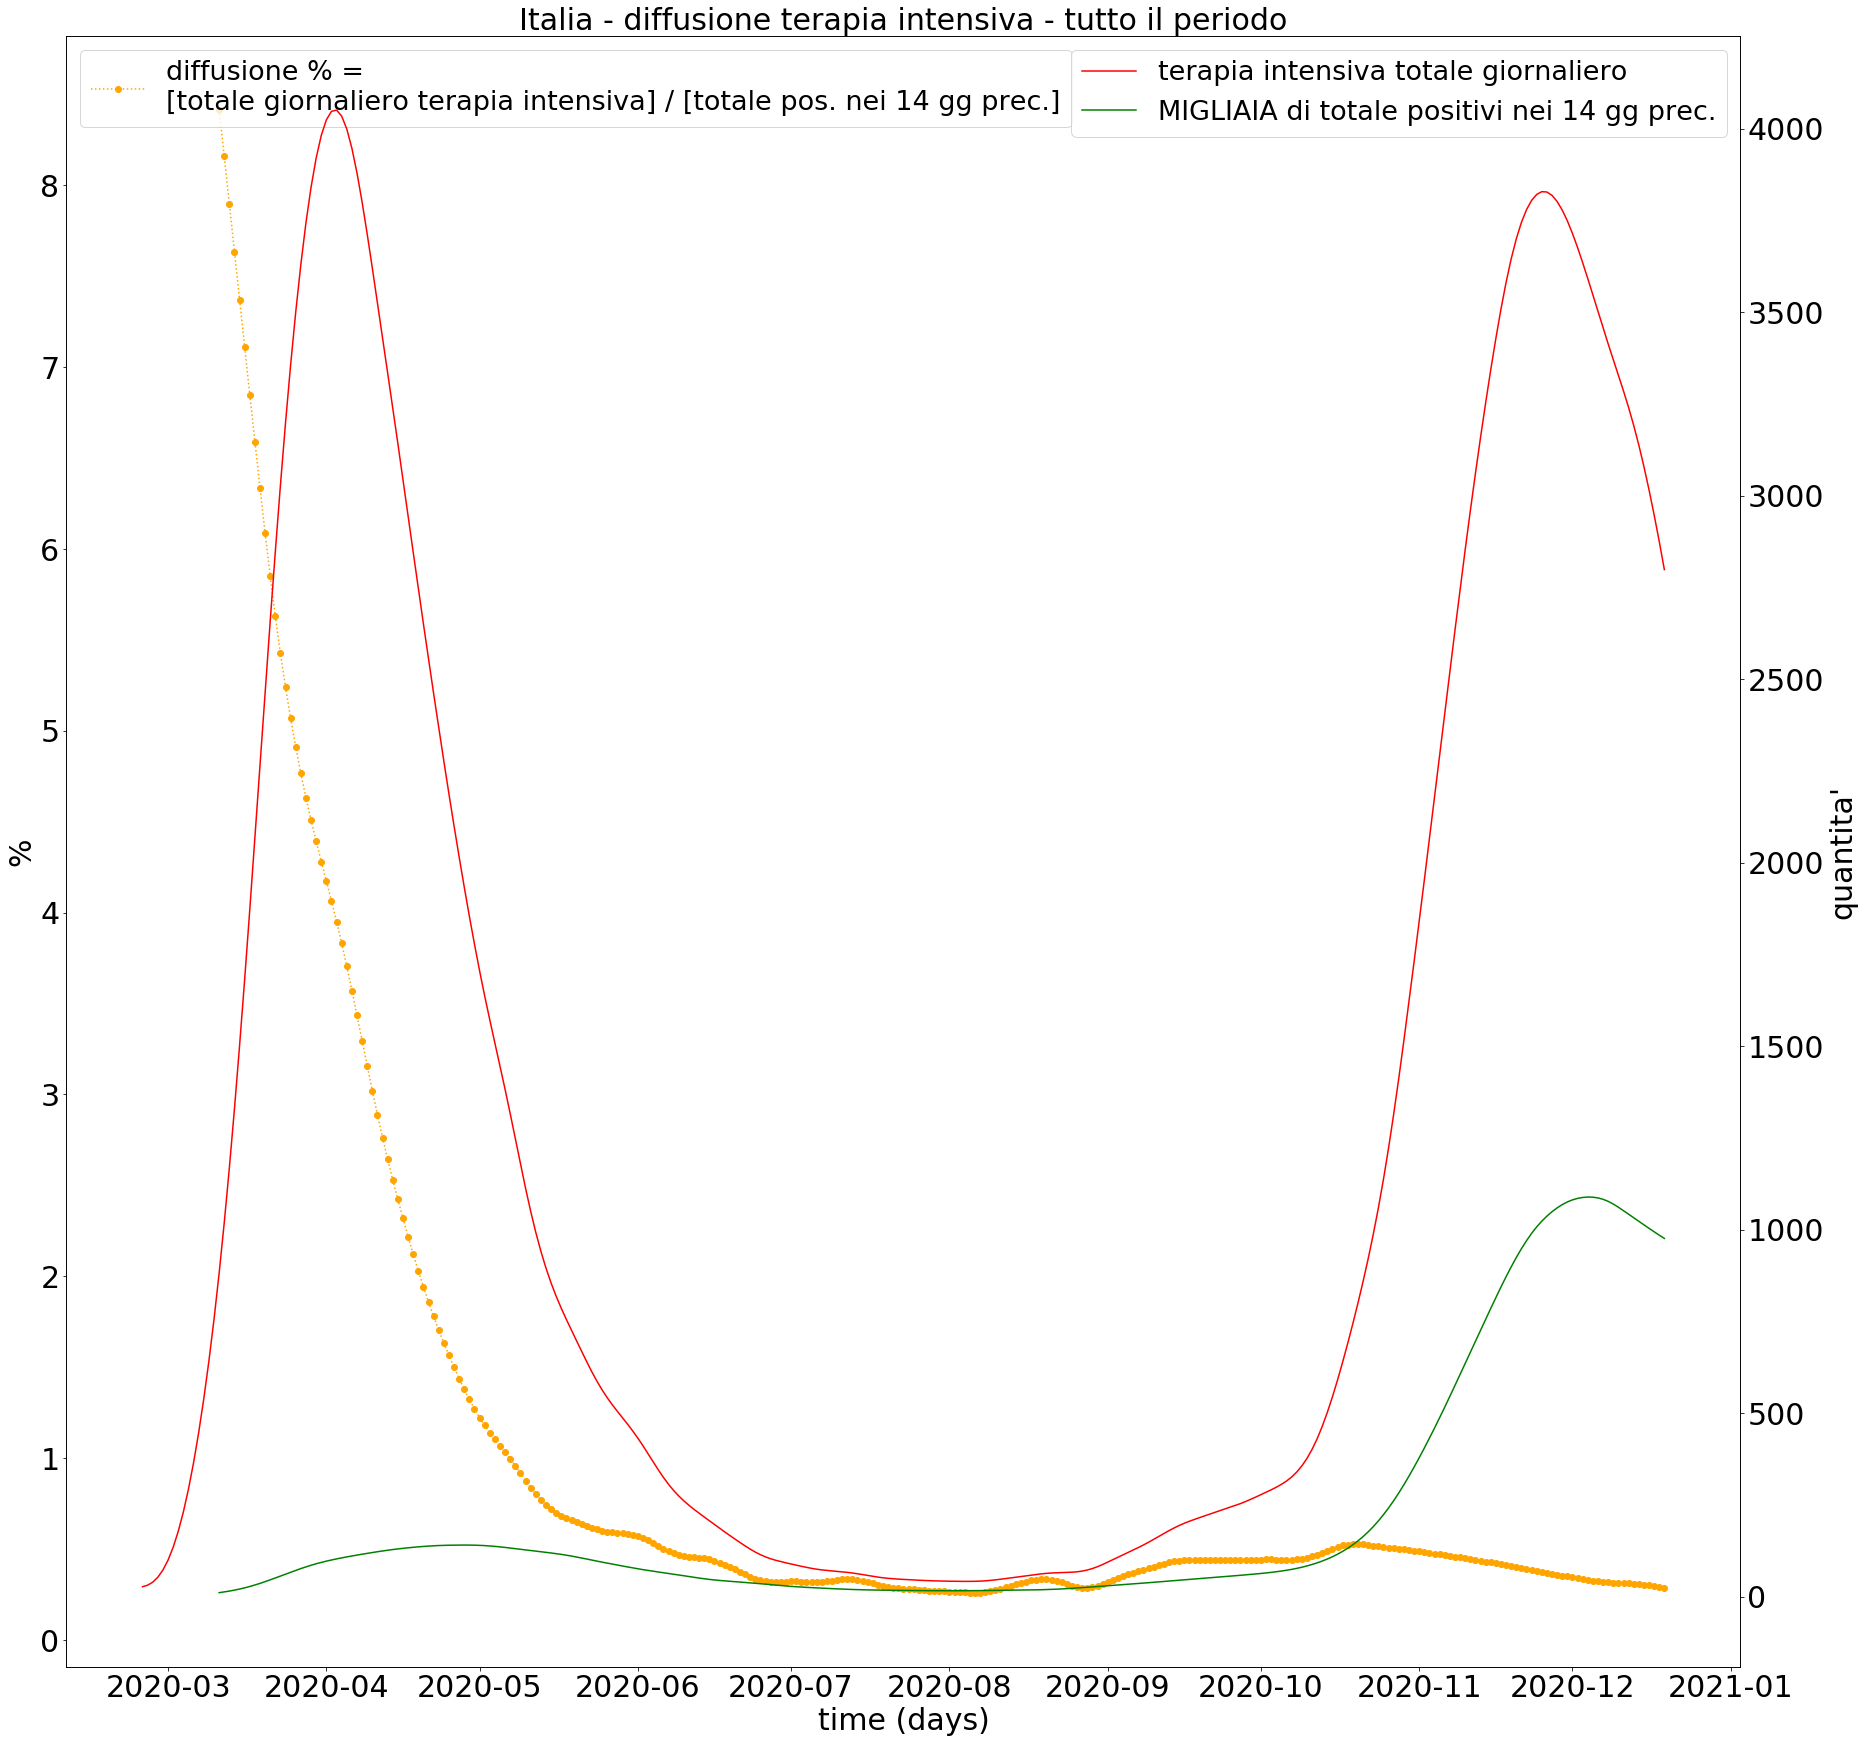

In [63]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,30))
ax1.set_title('Italia - diffusione terapia intensiva - tutto il periodo', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('%', fontsize=30)

ax1.plot(italy_raw_data.data, italy_raw_data.diffusione_terapia_intensiva_su_totale_positivi_in_14_smoothed*100, label='diffusione % = \n[totale giornaliero terapia intensiva] / [totale pos. nei 14 gg prec.]', color='orange', linestyle=':', marker='o')
#ax1.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14*100, label='diffusione_su_totale_positivi_in_14', color='blue')
ax1.legend(fontsize=27, loc='upper left')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('quantita\'', fontsize=30)
ax2.tick_params(axis='y', labelsize=30)

ax2.plot(italy_raw_data.data, italy_raw_data.terapia_intensiva_smoothed, label='terapia intensiva totale giornaliero', color='red')
ax2.plot(italy_raw_data.data, italy_raw_data.totale_positivi_in_14_smoothed/1000, label='MIGLIAIA di totale positivi nei 14 gg prec.', color='green')

ax2.legend(fontsize=27,loc='upper right')

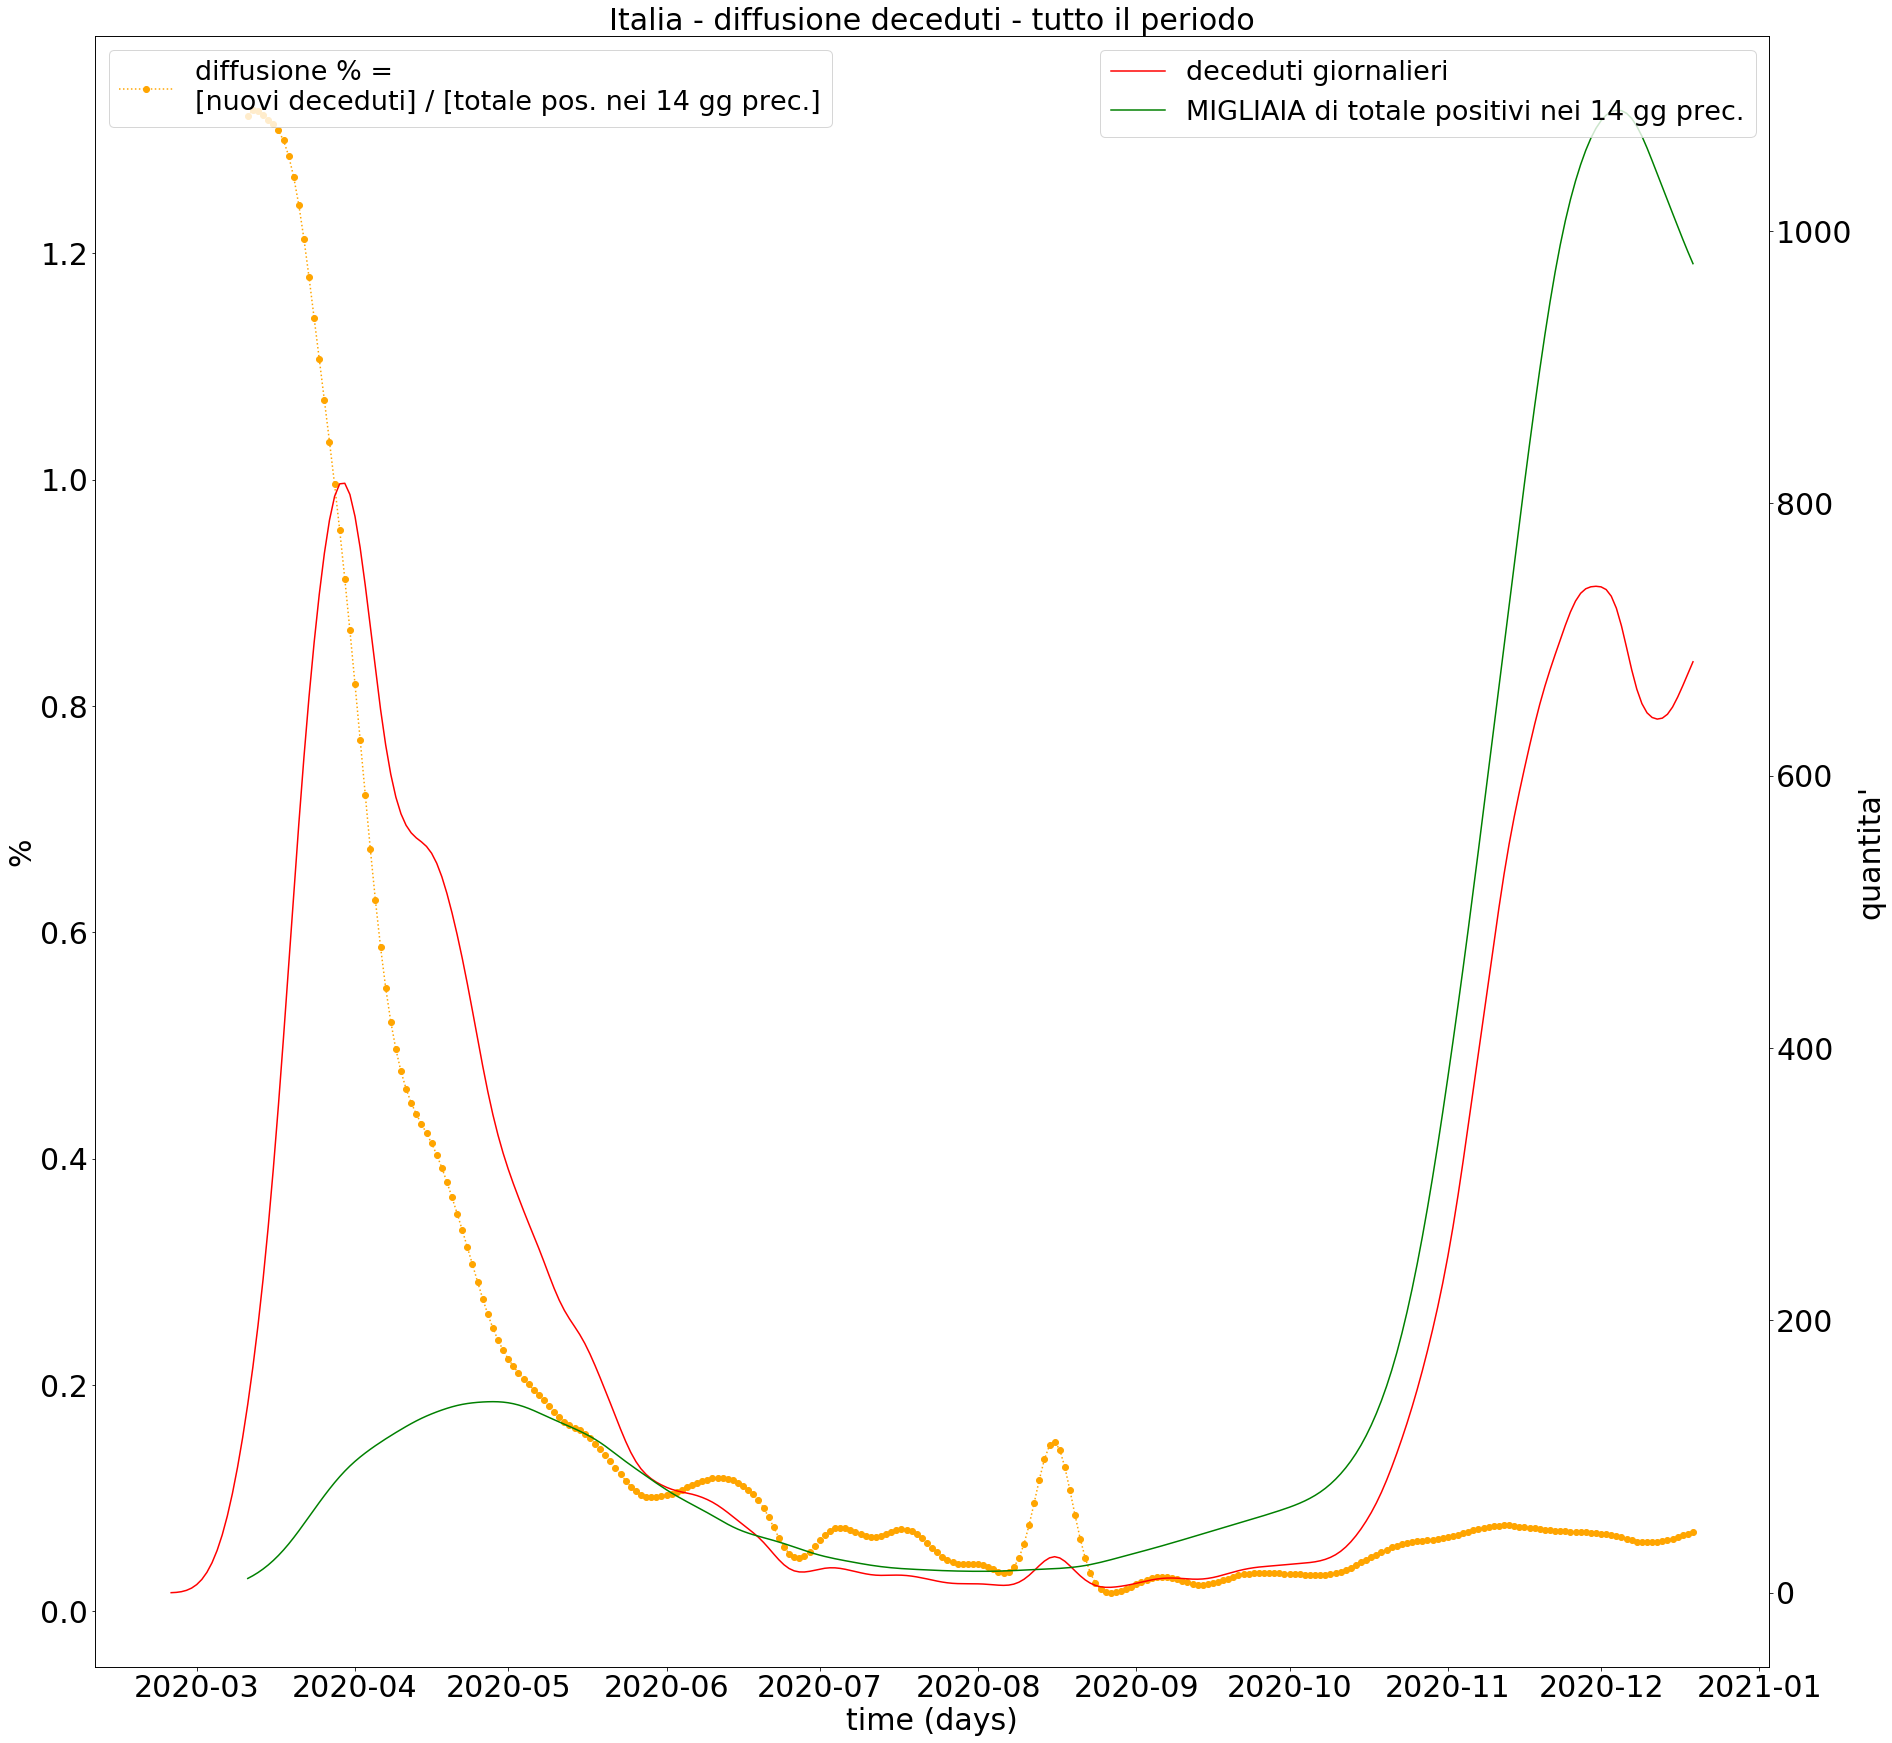

In [64]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,30))
ax1.set_title('Italia - diffusione deceduti - tutto il periodo', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('%', fontsize=30)

ax1.plot(italy_raw_data.data, italy_raw_data.diffusione_deceduti_su_totale_positivi_in_14_smoothed*100, label='diffusione % = \n[nuovi deceduti] / [totale pos. nei 14 gg prec.]', color='orange', linestyle=':', marker='o')
#ax1.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14*100, label='diffusione_su_totale_positivi_in_14', color='blue')
ax1.legend(fontsize=27, loc='upper left')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('quantita\'', fontsize=30)
ax2.tick_params(axis='y', labelsize=30)

ax2.plot(italy_raw_data.data, italy_raw_data.deceduti_giornalieri_smoothed, label='deceduti giornalieri', color='red')
ax2.plot(italy_raw_data.data, italy_raw_data.totale_positivi_in_14_smoothed/1000, label='MIGLIAIA di totale positivi nei 14 gg prec.', color='green')

ax2.legend(fontsize=27,loc='upper right')

# compute $R_t$

Ref: https://it.m.wikipedia.org/wiki/Numero_di_riproduzione_di_base

$$\large{R_t = \frac{I_t}{\sum_{s=1}^t w_s I_{t-s}}}$$

$$\large{w_s=\Gamma(s; \alpha,\beta)}$$

$\alpha = 1.87$

$\beta = 0.28$

In [65]:
def gamma_df(x, alpha, beta):
    return stats.gamma.pdf(x, a=alpha, scale=1/beta)

In [66]:
def gamma_pf(x, alpha, beta):
    return stats.gamma.ppf(x, a=alpha, scale=1/beta)

In [67]:
def Rt(series, alpha, beta):
    steps = len(series)
    x = np.linspace(1,steps-1, steps)
    w = gamma_df(x, alpha, beta)
    
    infectious_charge = [np.nan] + [
        sum(series[t-1::-1]*w[:t]) 
        for t in range(1, steps)        
    ]
    
    return series / infectious_charge

In [68]:
italy_raw_data['Rt'] = Rt(italy_raw_data.nuovi_positivi, alpha=1.87, beta=0.28).fillna(0)

In [69]:
italy_raw_data['Rt_on_np_smoothed'] = Rt(italy_raw_data.nuovi_positivi_smoothed, alpha=1.87, beta=0.28).fillna(0)

In [70]:
italy_raw_data['Rt_smoothed'] = smooth_data(
    y=italy_raw_data.Rt,
    X=INTEGRAL_MATRIX,
    L=GAMMA,
    alpha=ALPHA)

TIC R2: 0.7062776442277242


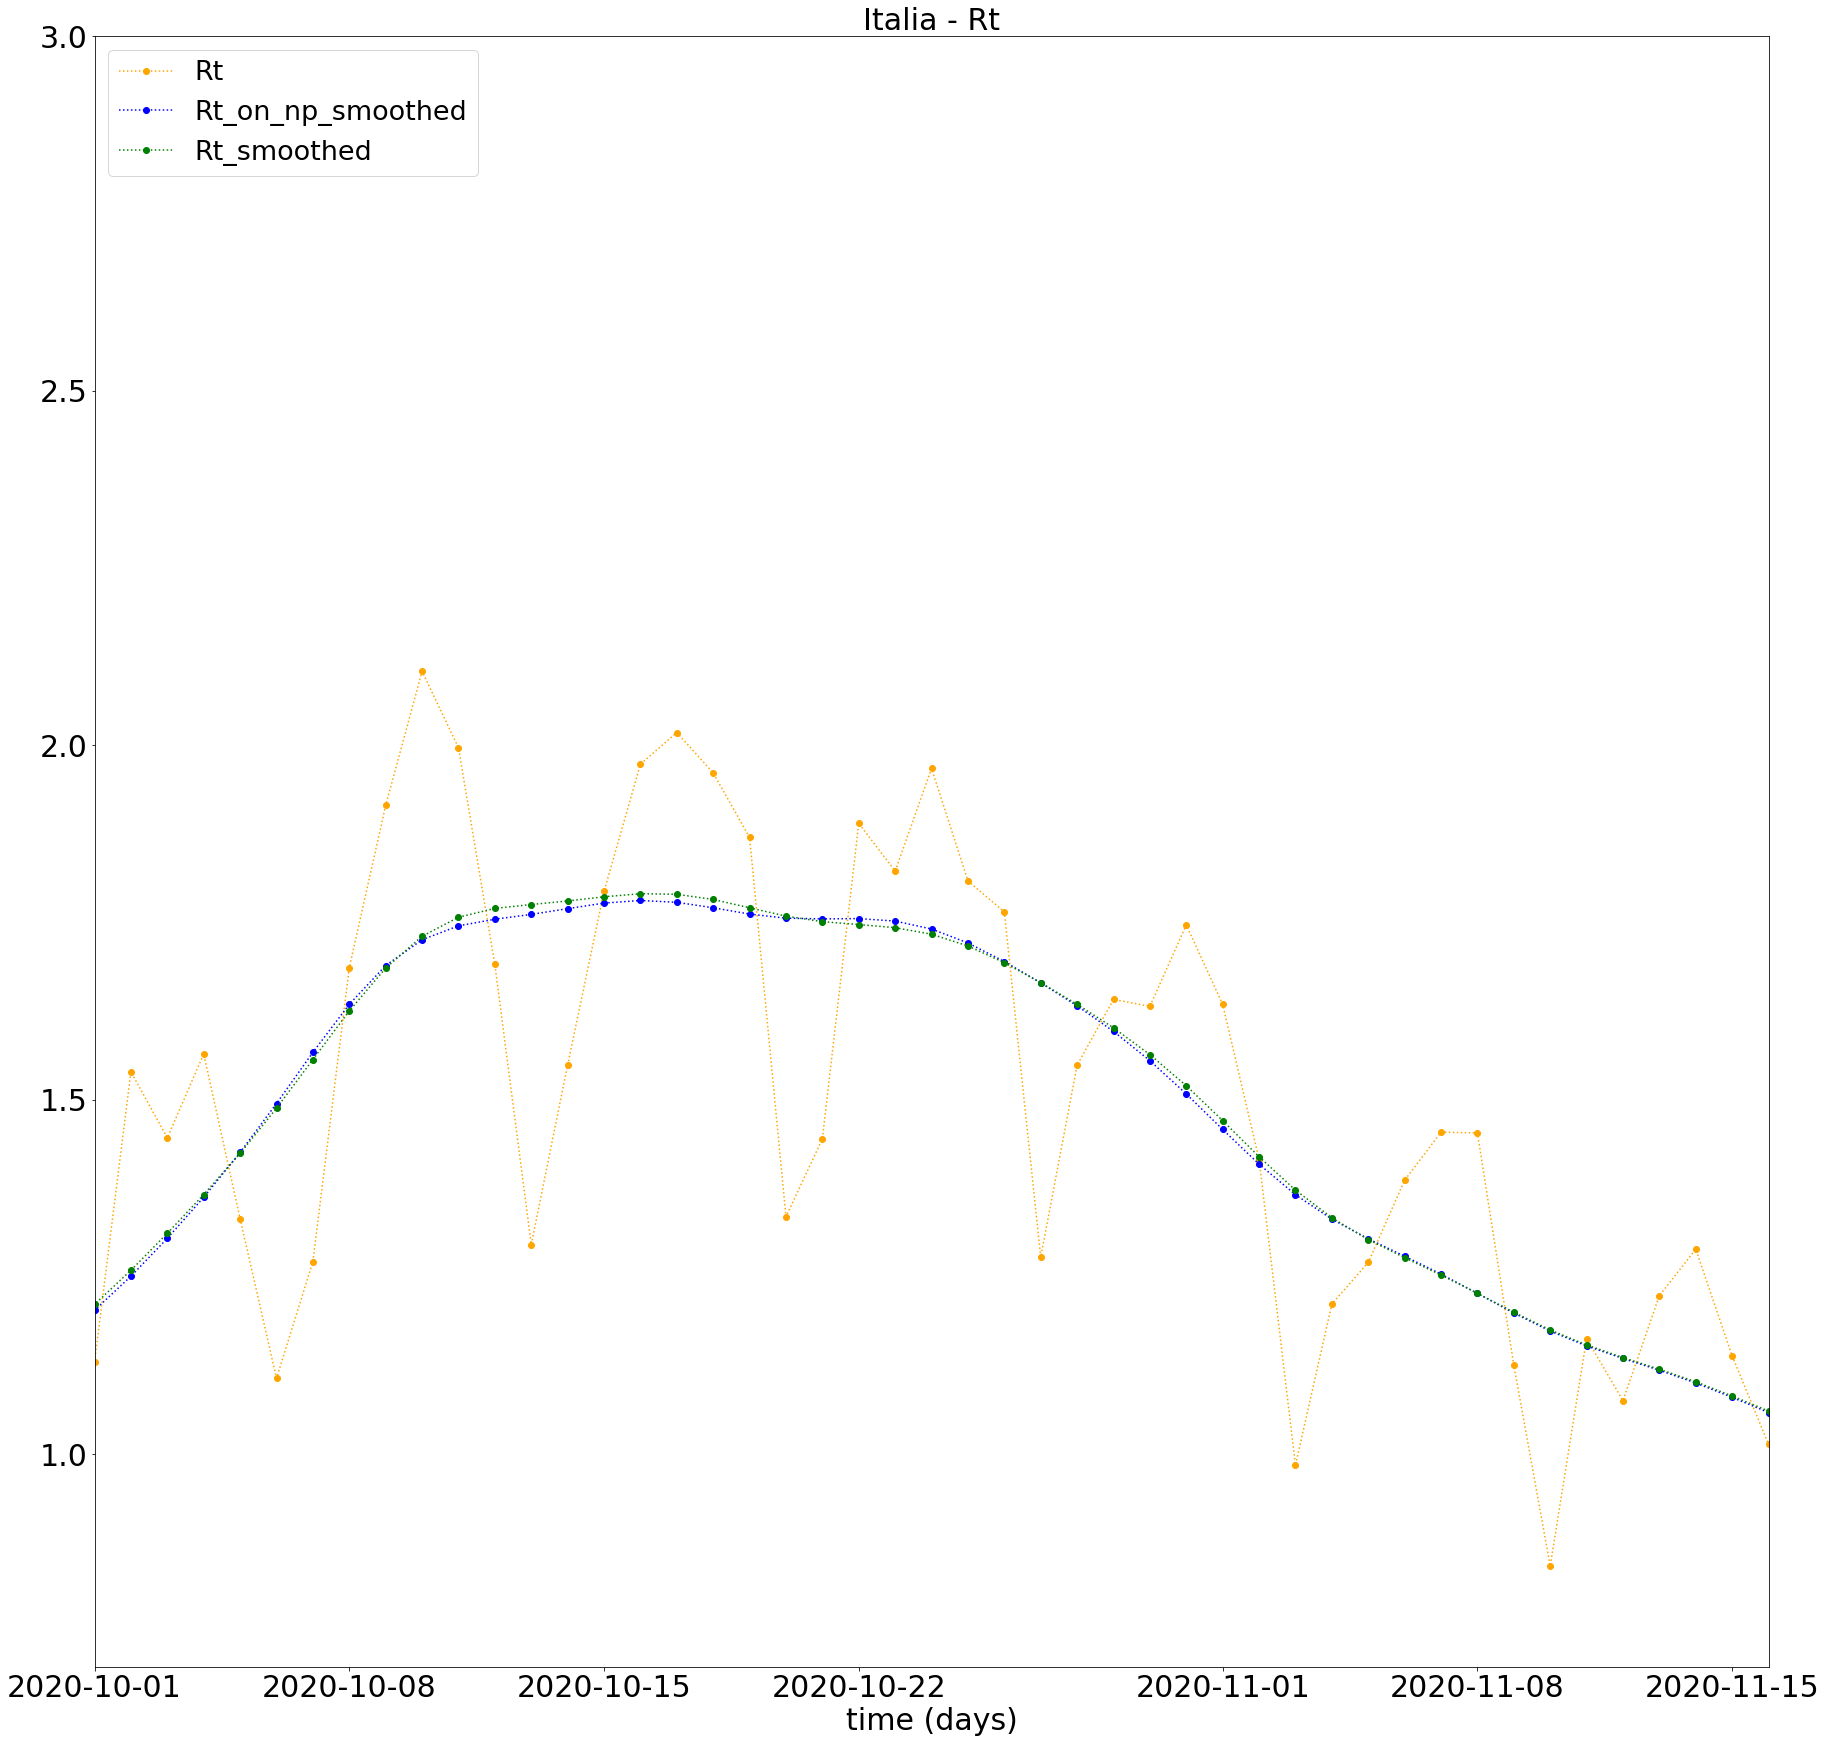

In [71]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,30))
ax1.set_title('Italia - Rt', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylim(0.7,3)
ax1.set_xlim(datetime(2020,10,1),datetime(2020,11,16))

ax1.plot(italy_raw_data.data, italy_raw_data.Rt, label='Rt', color='orange', linestyle=':', marker='o')
ax1.plot(italy_raw_data.data, italy_raw_data.Rt_on_np_smoothed, label='Rt_on_np_smoothed', color='blue', linestyle=':', marker='o')
ax1.plot(italy_raw_data.data, italy_raw_data.Rt_smoothed, label='Rt_smoothed', color='green', linestyle=':', marker='o')
ax1.legend(fontsize=27, loc='upper left')




# checking tamponi vs dimessi

In [72]:
start, end = 20, TIMESTEPS

td_offset, td_corrs = compute_offset(
    s_preceeding=italy_raw_data.tamponi_giornalieri_smoothed[start:end],
    s_following=italy_raw_data.dimessi_guariti_giornalieri_smoothed[start:end], 
    start=-5, interval=10
)


tod, tod_e = compute_average_ratio(
    italy_raw_data.tamponi_giornalieri_smoothed.shift(td_offset)[start:end], 
    italy_raw_data.dimessi_guariti_giornalieri_smoothed[start:end]
)

print('tamponi dimessi, offset: {}, ratio: {:2.0f} +/- {:2.0f}'.format(td_offset, tod, tod_e))


tamponi dimessi, offset: -5, ratio: 90 +/- 87


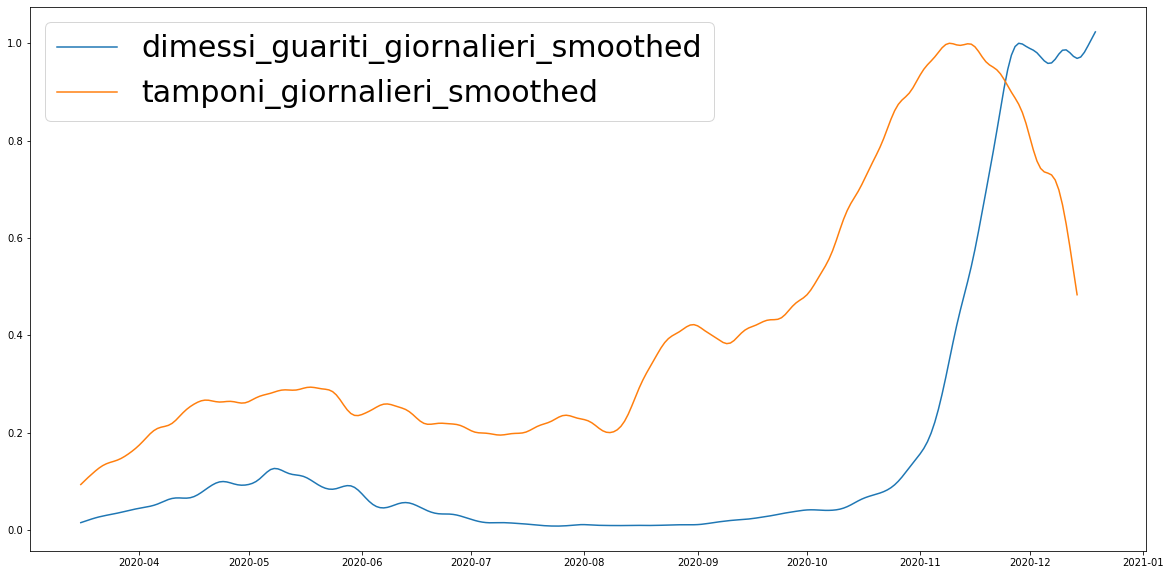

In [73]:
start, end = 20, TIMESTEPS
shift = 3
plt.figure(figsize=(20,10))
plt.plot(
    italy_raw_data.data[start:end], 
    italy_raw_data.dimessi_guariti_giornalieri_smoothed[start:end]/italy_raw_data.dimessi_guariti_giornalieri_smoothed.shift(3)[start:end].max(), label='dimessi_guariti_giornalieri_smoothed'
)
plt.plot(
    italy_raw_data.data[start:end], 
    italy_raw_data.tamponi_giornalieri_smoothed.shift(td_offset)[start:end]/italy_raw_data.tamponi_giornalieri_smoothed[start:end].max(), label='tamponi_giornalieri_smoothed'
)


plt.legend(fontsize=30)

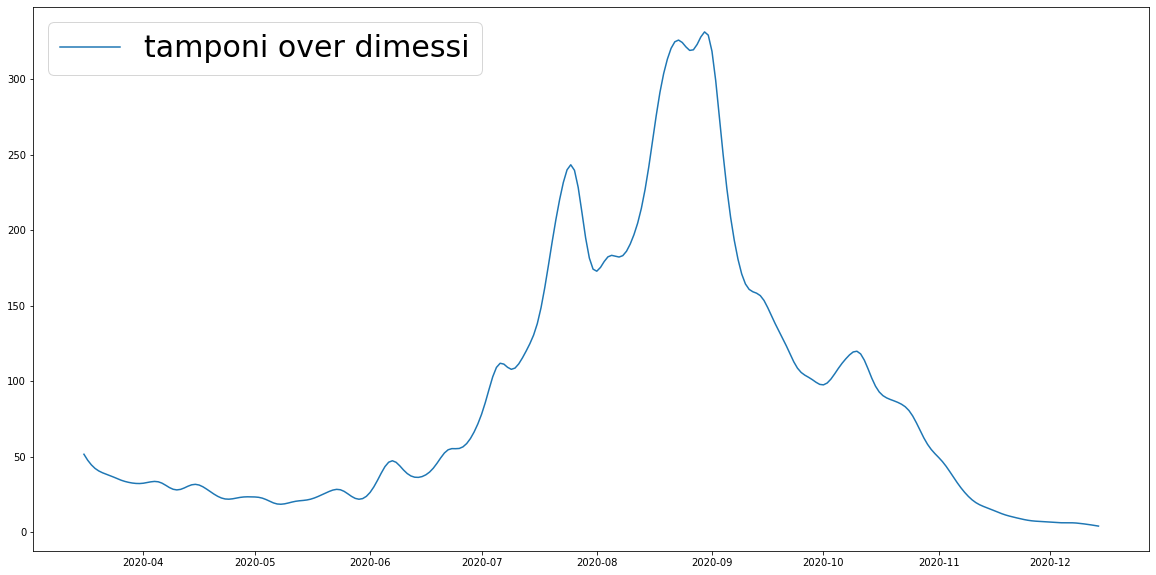

In [74]:
plt.figure(figsize=(20,10))
plt.plot(italy_raw_data.data[start:end], italy_raw_data.tamponi_giornalieri_smoothed.shift(td_offset)[start:end]/italy_raw_data.dimessi_guariti_giornalieri_smoothed[start:end], label='tamponi over dimessi')


plt.legend(fontsize=30)

# Doubling time

In [75]:
def doubling_times(x):
    Td = []
    for idx, tp in x.items():
        td = np.argmax(x > 2. * tp)
        if td > 0:
            Td.append(td -idx)
        else:
            Td.append(np.nan)
    return np.array(Td)

In [76]:
italy_raw_data['totale_positivi_Dt'] = doubling_times(italy_raw_data.totale_positivi)

In [77]:
italy_raw_data['totale_positivi_smoothed_Dt'] = doubling_times(italy_raw_data.totale_positivi_smoothed)

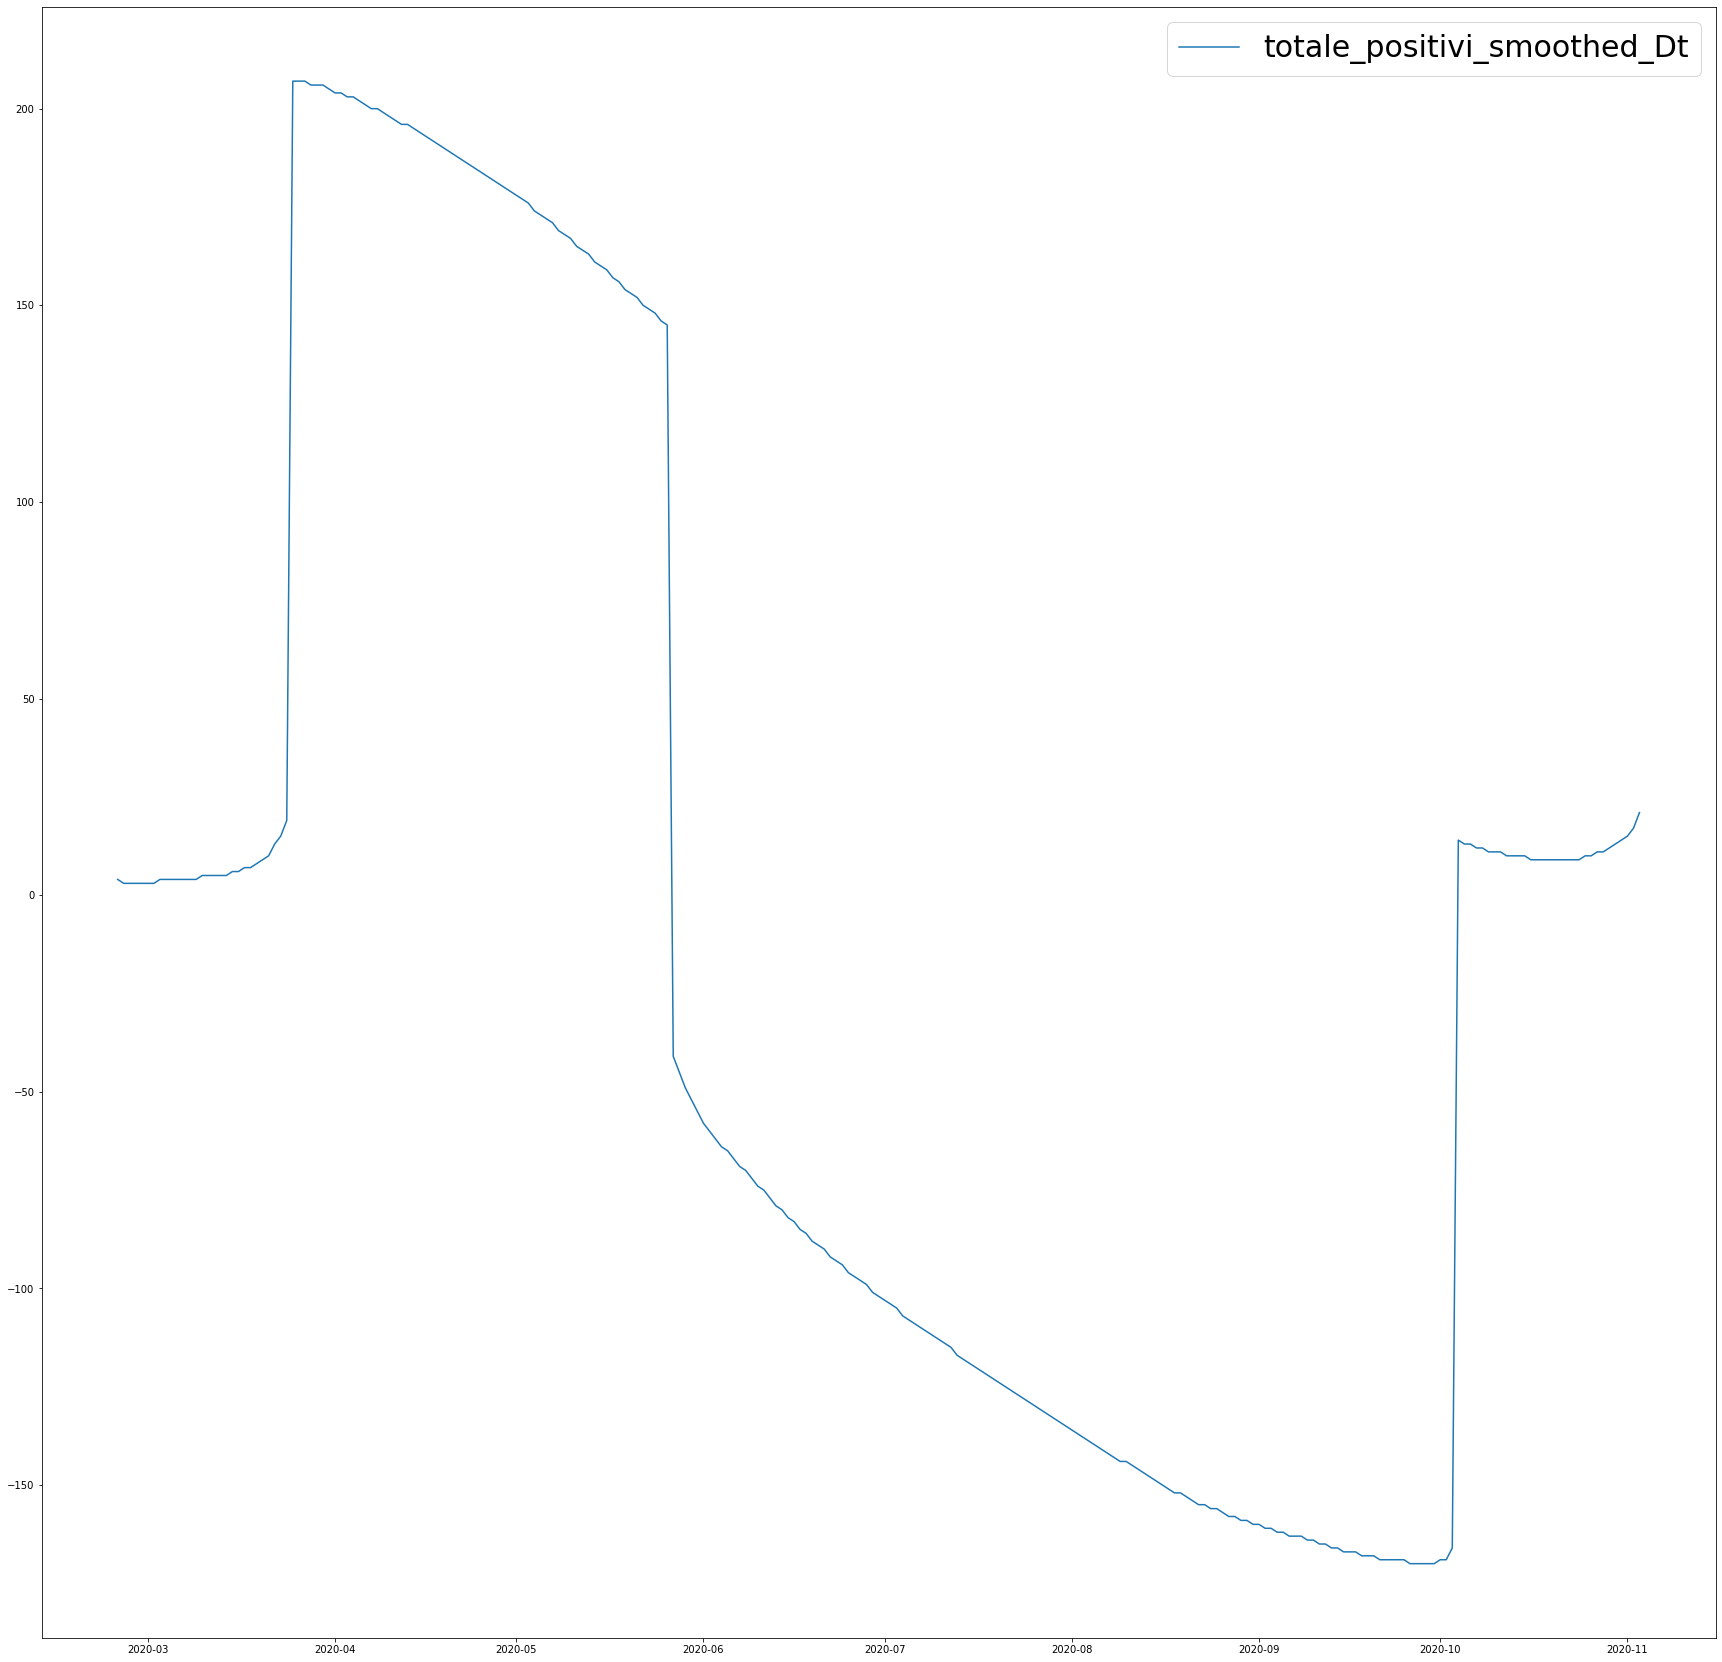

In [78]:
plt.figure(figsize=(30,30))

plt.plot(italy_raw_data.data, italy_raw_data.totale_positivi_smoothed_Dt, label='totale_positivi_smoothed_Dt')

plt.legend(fontsize=30)

## fitting the doubling time among 5 moving points

In [79]:
def fitted_doubling_time(x, rate=1.):
    fit_points = 5
    stop_before = 0
    half_interval = int(fit_points / 2)
    stop_at = TIMESTEPS - half_interval - stop_before

    double_times = [np.nan] * half_interval
    for idx, tp in x.items():
        time_range = np.array(range(0,fit_points)).reshape(fit_points, 1)
        if idx > half_interval and idx < stop_at:
            interval_points = x[idx-half_interval:idx+half_interval+1].to_numpy()
            reg = LinearRegression().fit(time_range, interval_points)
            Dt = (1.+rate) * tp / reg.coef_[0]
            double_times.append(Dt)

    double_times = double_times + [np.nan] * (TIMESTEPS - stop_at +1)
    return np.array(double_times).reshape(TIMESTEPS, 1)


In [80]:
italy_raw_data['totale_positivi_Dt_fit'] = fitted_doubling_time(italy_raw_data.totale_positivi)
italy_raw_data['totale_positivi_smoothed_Dt_fit'] = fitted_doubling_time(italy_raw_data.totale_positivi_smoothed)

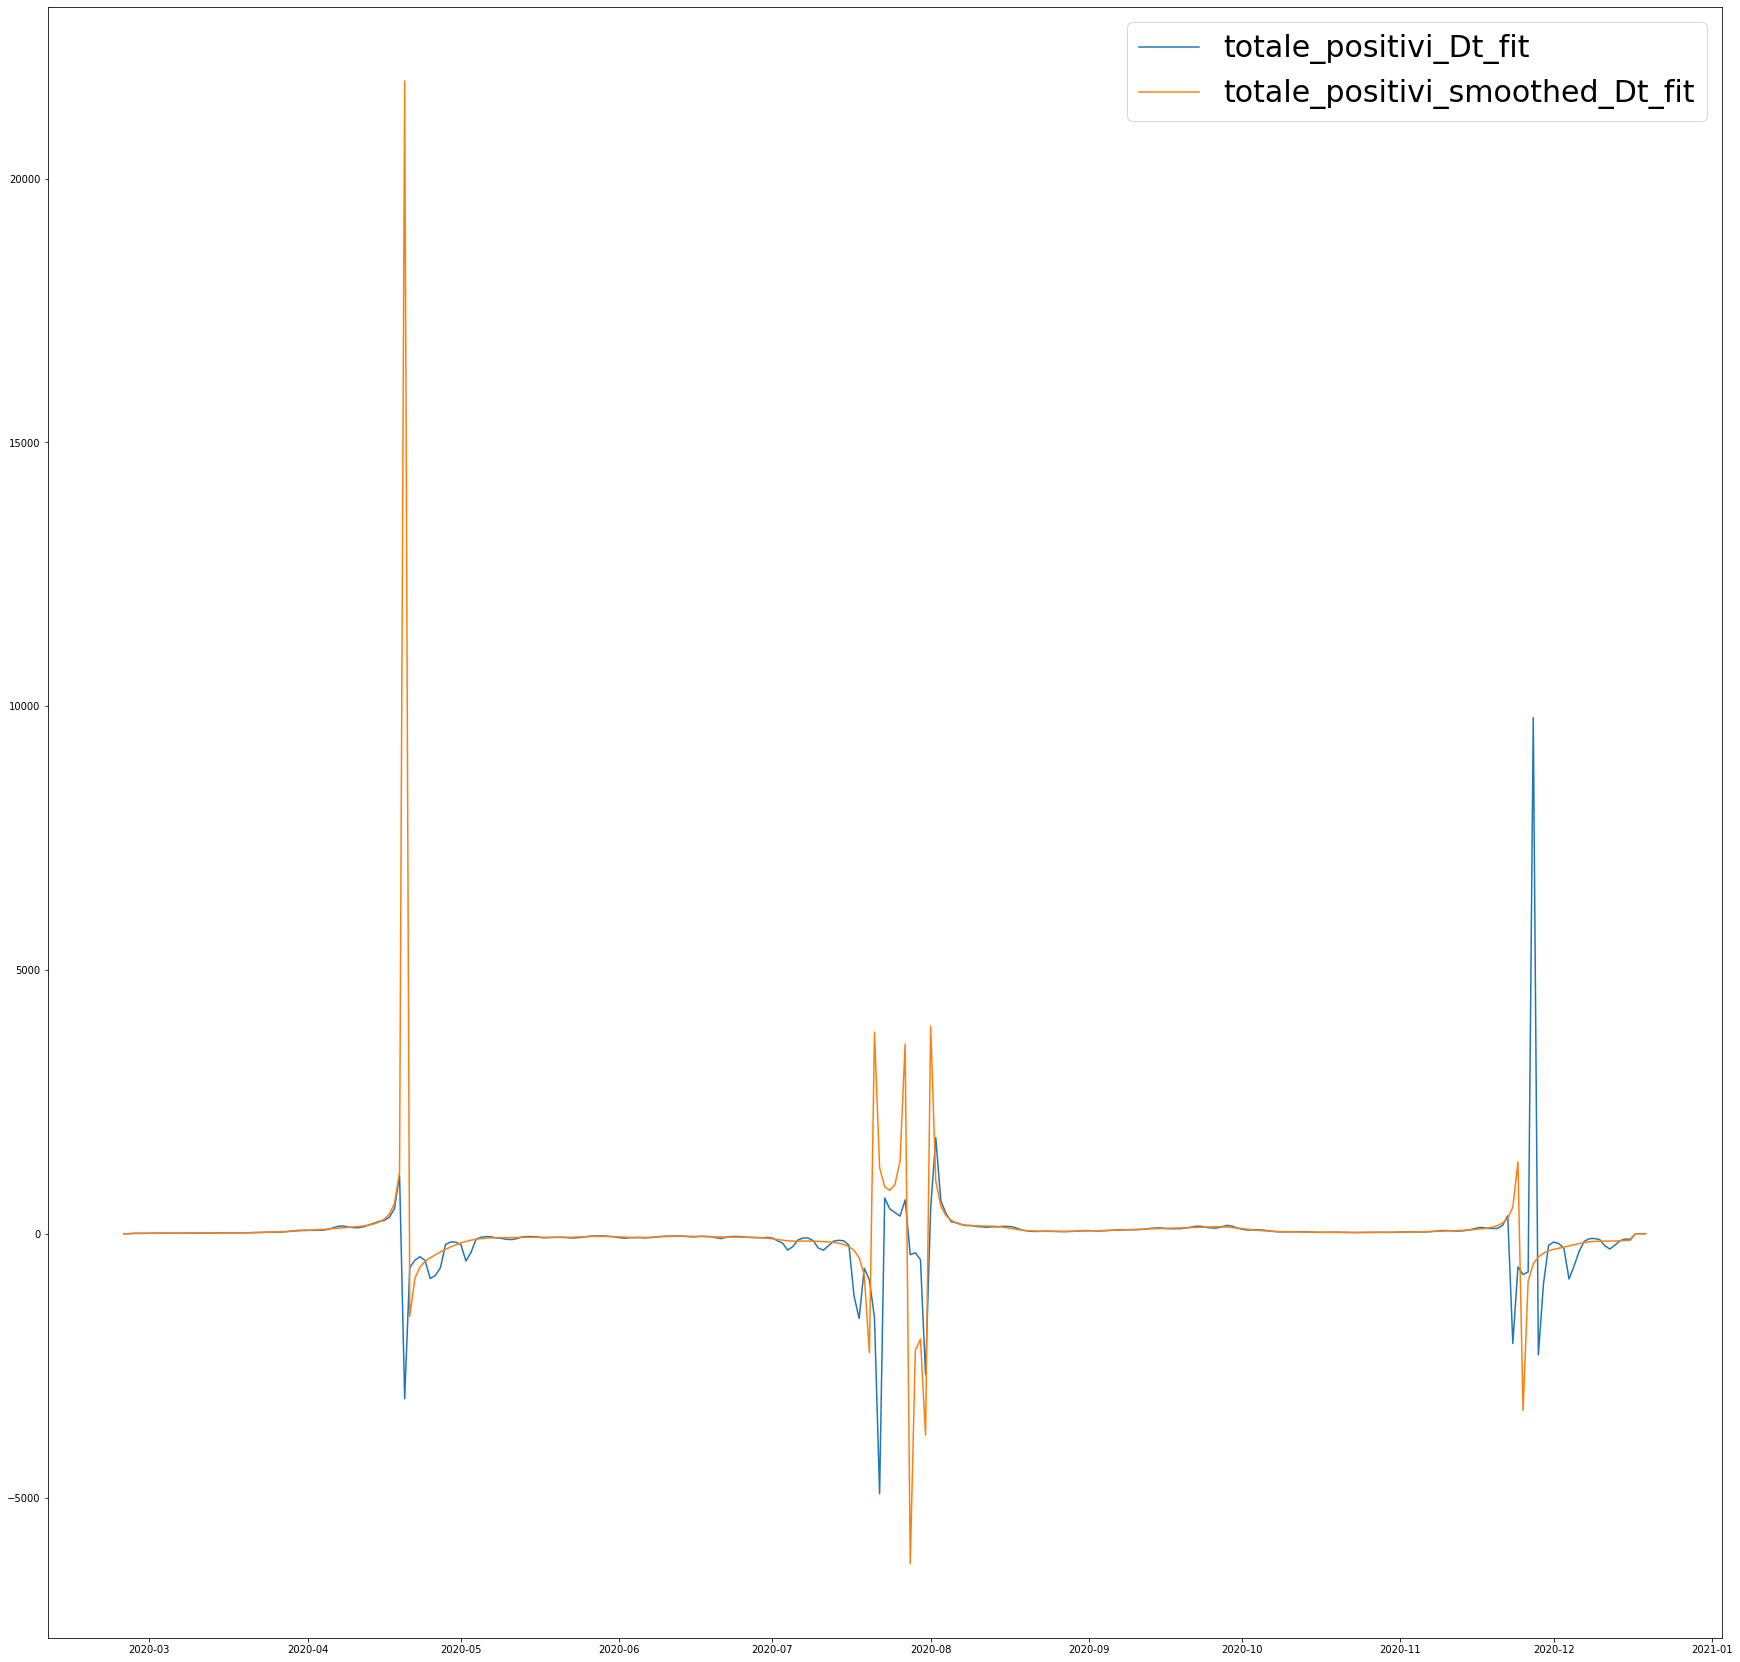

In [81]:
plt.figure(figsize=(30,30))
#plt.yscale('log')
plt.plot(italy_raw_data.data, italy_raw_data.totale_positivi_Dt_fit.fillna(0), label='totale_positivi_Dt_fit')
plt.plot(italy_raw_data.data, italy_raw_data.totale_positivi_smoothed_Dt_fit.fillna(0), label='totale_positivi_smoothed_Dt_fit')
#plt.plot(italy_raw_data.data, italy_raw_data.totale_positivi_smoothed/10**2, label='totale_positivi_smoothed')


plt.legend(fontsize=30)

In [82]:
compute_dt_on = [
    'totale_casi',
    'totale_casi_smoothed',
    'casi_da_sospetto_diagnostico',
    'casi_da_sospetto_diagnostico_smoothed',
    'casi_da_screening',
    'casi_da_screening_smoothed',
    'casi_da_sospetto_diagnostico_perturbati_r07_smoothed',
    'casi_da_sospetto_diagnostico_perturbati_r08_smoothed',
    'casi_perturbazione_r07',
    'casi_perturbazione_r08',
    'casi_da_sospetto_diagnostico_perturbati_const_50k_smoothed',
    'casi_da_sospetto_diagnostico_perturbati_rsin_smoothed',
    'casi_da_sospetto_diagnostico_perturbati_lin_10k_smoothed'
]

for c in compute_dt_on:
    italy_raw_data['{}_Dt_fit'.format(c)] = fitted_doubling_time(italy_raw_data[c])
    italy_raw_data['{}_r01t_fit'.format(c)] = fitted_doubling_time(italy_raw_data[c], rate=0.1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]

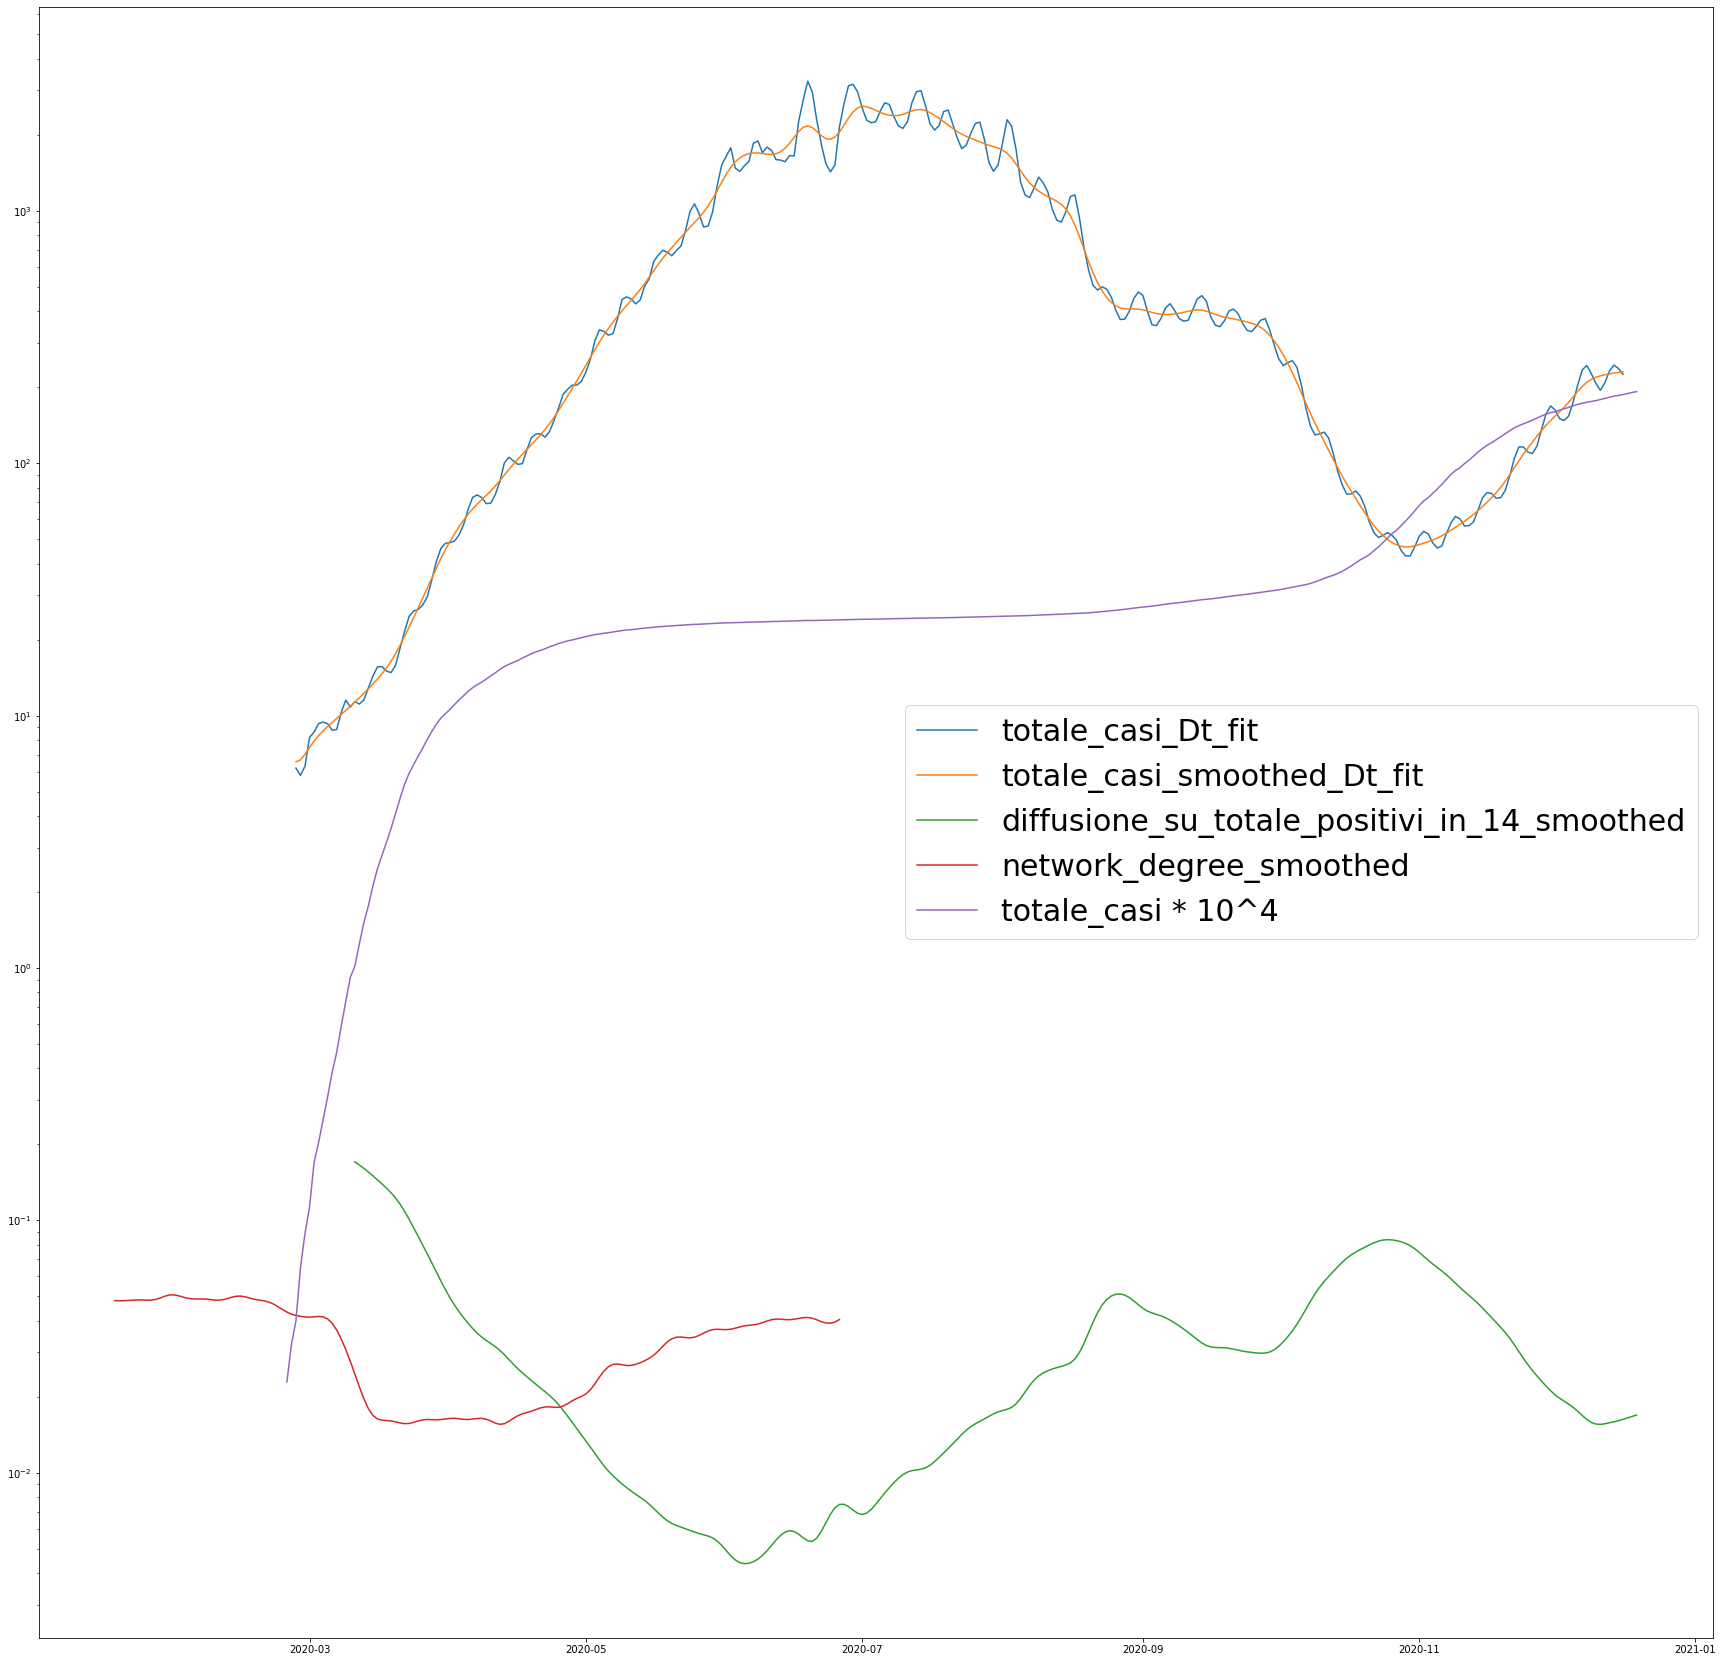

In [83]:
plt.figure(figsize=(30,30))
plt.yscale('log')
plt.plot(italy_raw_data.data, italy_raw_data.totale_casi_Dt_fit, label='totale_casi_Dt_fit')
plt.plot(italy_raw_data.data, italy_raw_data.totale_casi_smoothed_Dt_fit, label='totale_casi_smoothed_Dt_fit')

plt.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14_smoothed, label='diffusione_su_totale_positivi_in_14_smoothed')
plt.plot(italy_mobility_data.date, italy_mobility_data.network_degree_smoothed, label='network_degree_smoothed')

plt.plot(italy_raw_data.data, italy_raw_data.totale_casi/10**4, label='totale_casi * 10^4')


plt.legend(fontsize=30)

### Doubling time of total cases

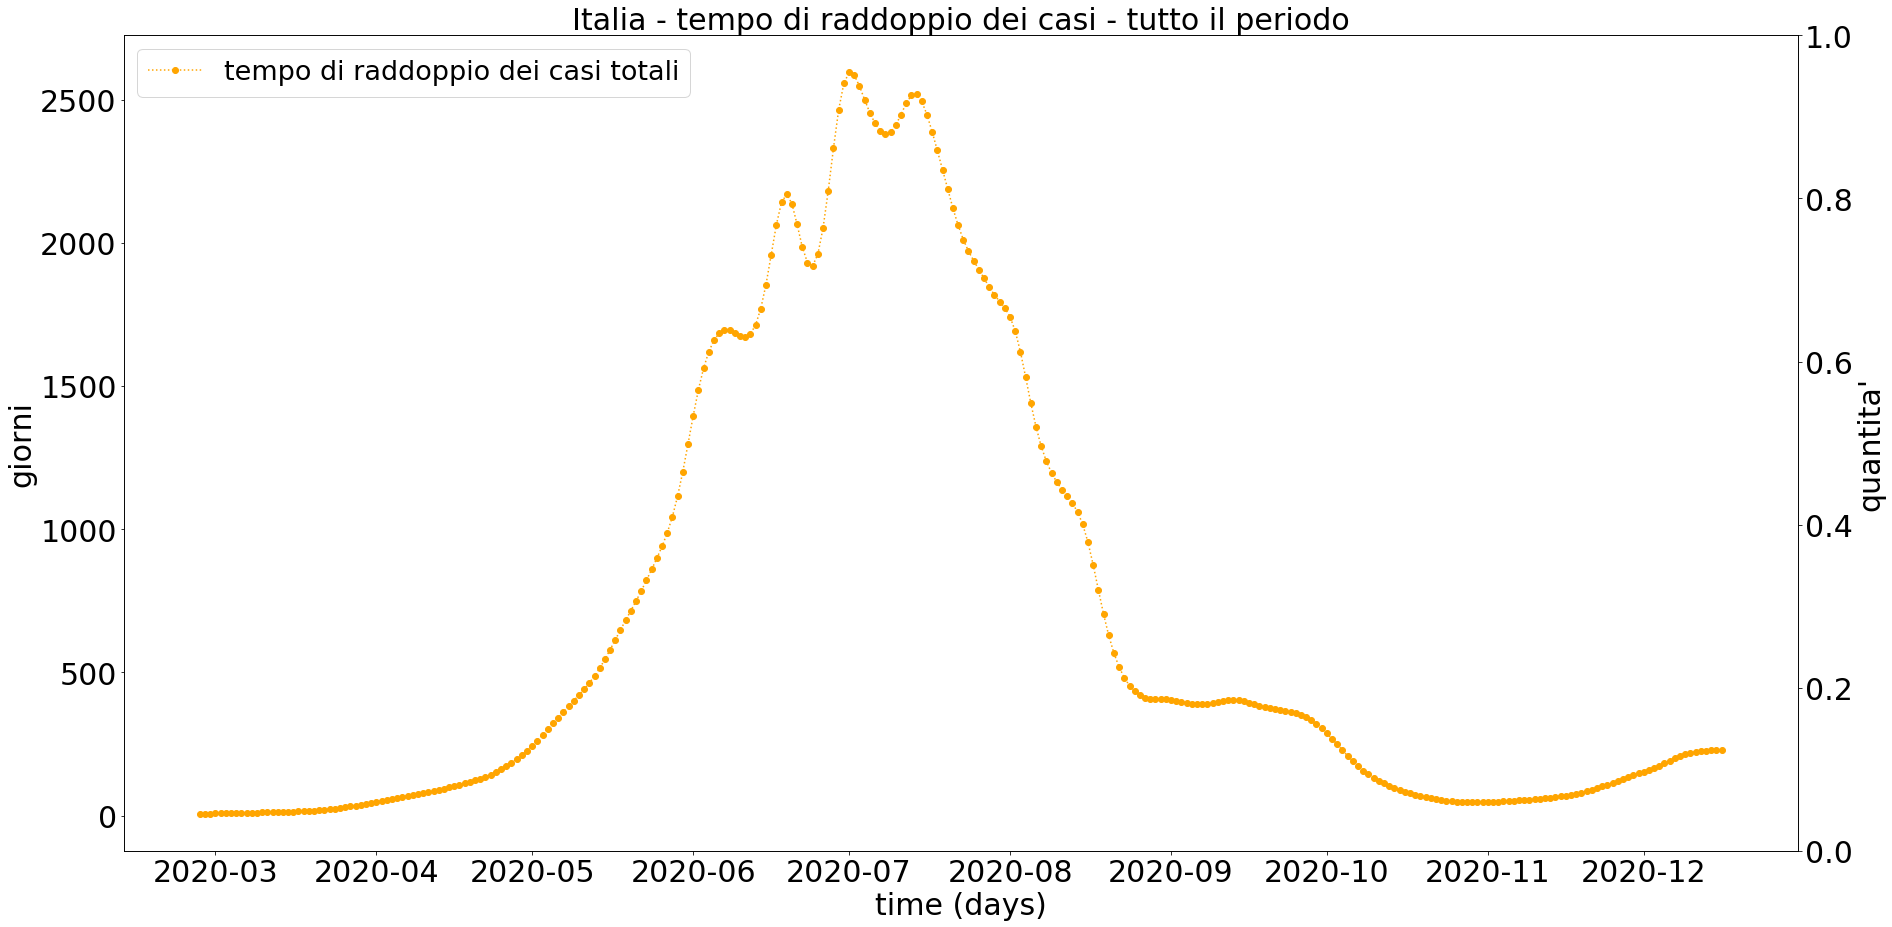

In [84]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Italia - tempo di raddoppio dei casi - tutto il periodo', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('giorni', fontsize=30)

ax1.plot(italy_raw_data.data, italy_raw_data.totale_casi_smoothed_Dt_fit, label='tempo di raddoppio dei casi totali', color='orange', linestyle=':', marker='o')
#ax1.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14*100, label='diffusione_su_totale_positivi_in_14', color='blue')
ax1.legend(fontsize=27, loc='upper left')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('quantita\'', fontsize=30)
ax2.tick_params(axis='y', labelsize=30)

#ax2.plot(italy_raw_data.data, italy_raw_data.nuovi_positivi_smoothed, label='nuovi positivi giornalieri', color='red')
#ax2.plot(italy_raw_data.data, italy_raw_data.totale_positivi_in_14_smoothed/10, label='DECINE di totale positivi nei 14 gg prec.', color='green')

#ax2.legend(fontsize=27,loc='upper right')

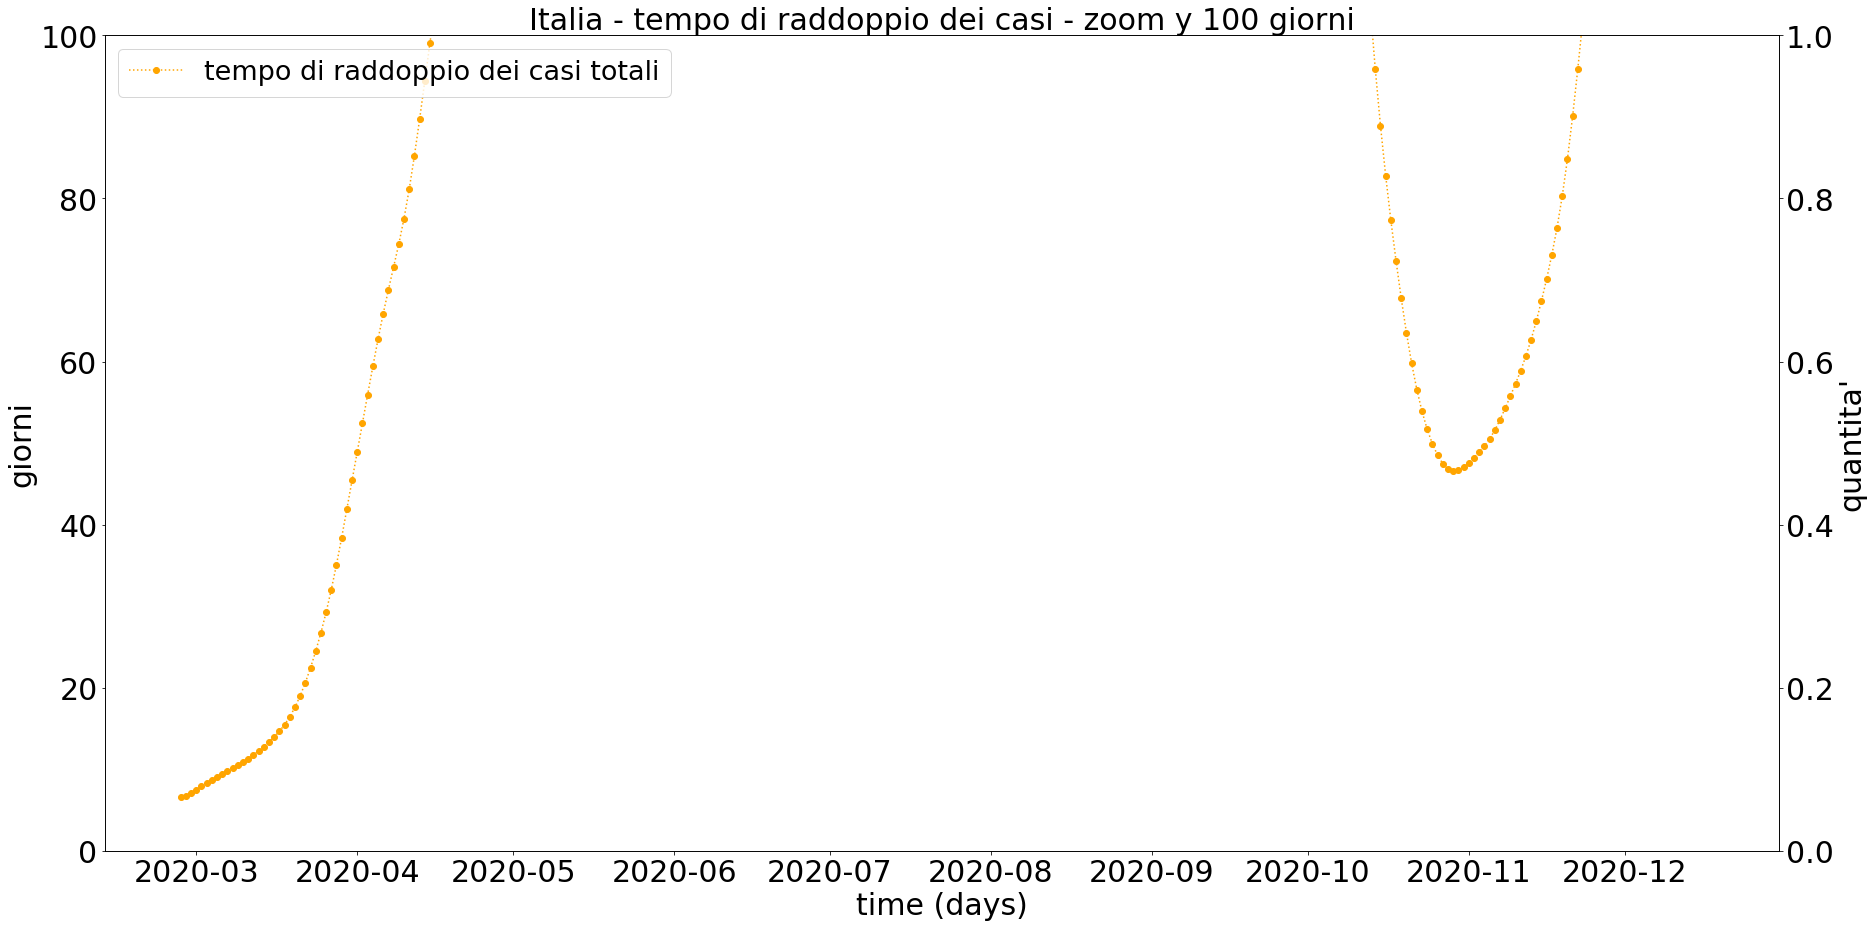

In [85]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Italia - tempo di raddoppio dei casi - zoom y 100 giorni', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('giorni', fontsize=30)
ax1.set_ylim(0,100)
ax1.plot(italy_raw_data.data, italy_raw_data.totale_casi_smoothed_Dt_fit, label='tempo di raddoppio dei casi totali', color='orange', linestyle=':', marker='o')
#ax1.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14*100, label='diffusione_su_totale_positivi_in_14', color='blue')
ax1.legend(fontsize=27, loc='upper left')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('quantita\'', fontsize=30)
ax2.tick_params(axis='y', labelsize=30)

#ax2.plot(italy_raw_data.data, italy_raw_data.nuovi_positivi_smoothed, label='nuovi positivi giornalieri', color='red')
#ax2.plot(italy_raw_data.data, italy_raw_data.totale_positivi_in_14_smoothed/10, label='DECINE di totale positivi nei 14 gg prec.', color='green')

#ax2.legend(fontsize=27,loc='upper right')

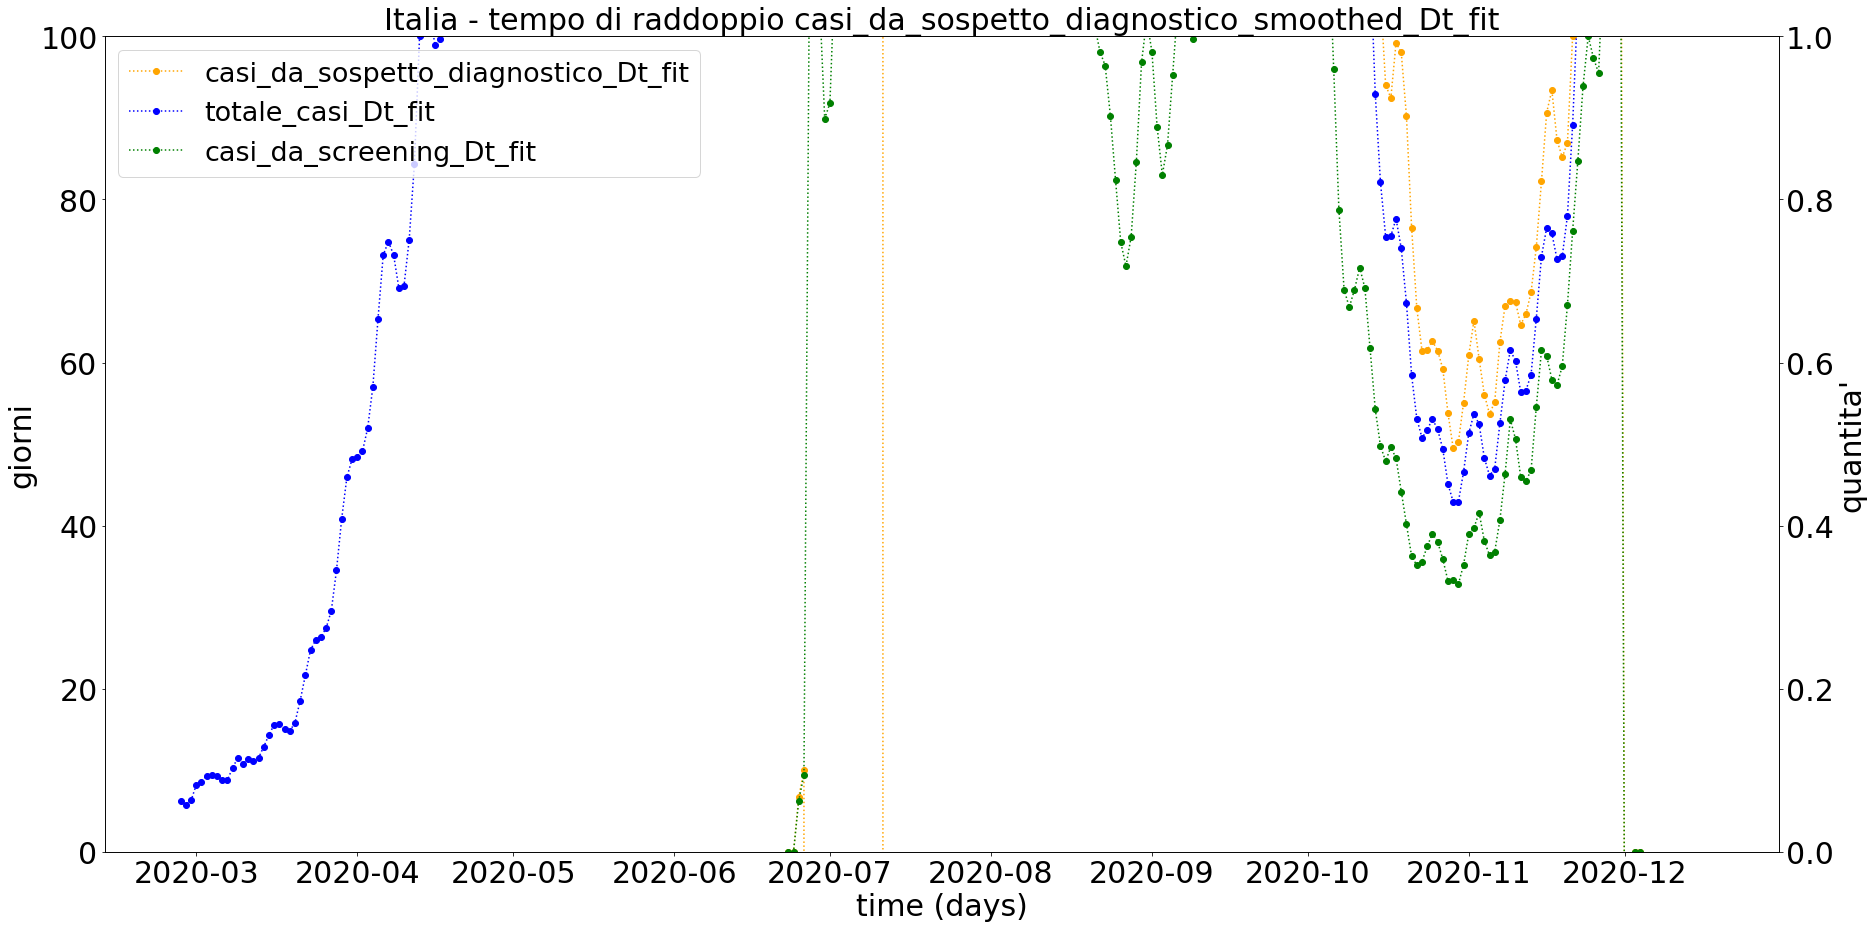

In [86]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Italia - tempo di raddoppio casi_da_sospetto_diagnostico_smoothed_Dt_fit', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('giorni', fontsize=30)
ax1.set_ylim(0,100)
ax1.plot(italy_raw_data.data, italy_raw_data.casi_da_sospetto_diagnostico_Dt_fit, 
         label='casi_da_sospetto_diagnostico_Dt_fit', color='orange', linestyle=':', marker='o')

ax1.plot(italy_raw_data.data, italy_raw_data.totale_casi_Dt_fit, 
         label='totale_casi_Dt_fit', color='blue', linestyle=':', marker='o')

ax1.plot(italy_raw_data.data, italy_raw_data.casi_da_screening_Dt_fit, 
         label='casi_da_screening_Dt_fit', color='green', linestyle=':', marker='o')

#ax1.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14*100, label='diffusione_su_totale_positivi_in_14', color='blue')
ax1.legend(fontsize=27, loc='upper left')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('quantita\'', fontsize=30)
ax2.tick_params(axis='y', labelsize=30)

#ax2.plot(italy_raw_data.data, italy_raw_data.nuovi_positivi_smoothed, label='nuovi positivi giornalieri', color='red')
#ax2.plot(italy_raw_data.data, italy_raw_data.totale_positivi_in_14_smoothed/10, label='DECINE di totale positivi nei 14 gg prec.', color='green')

#ax2.legend(fontsize=27,loc='upper right')

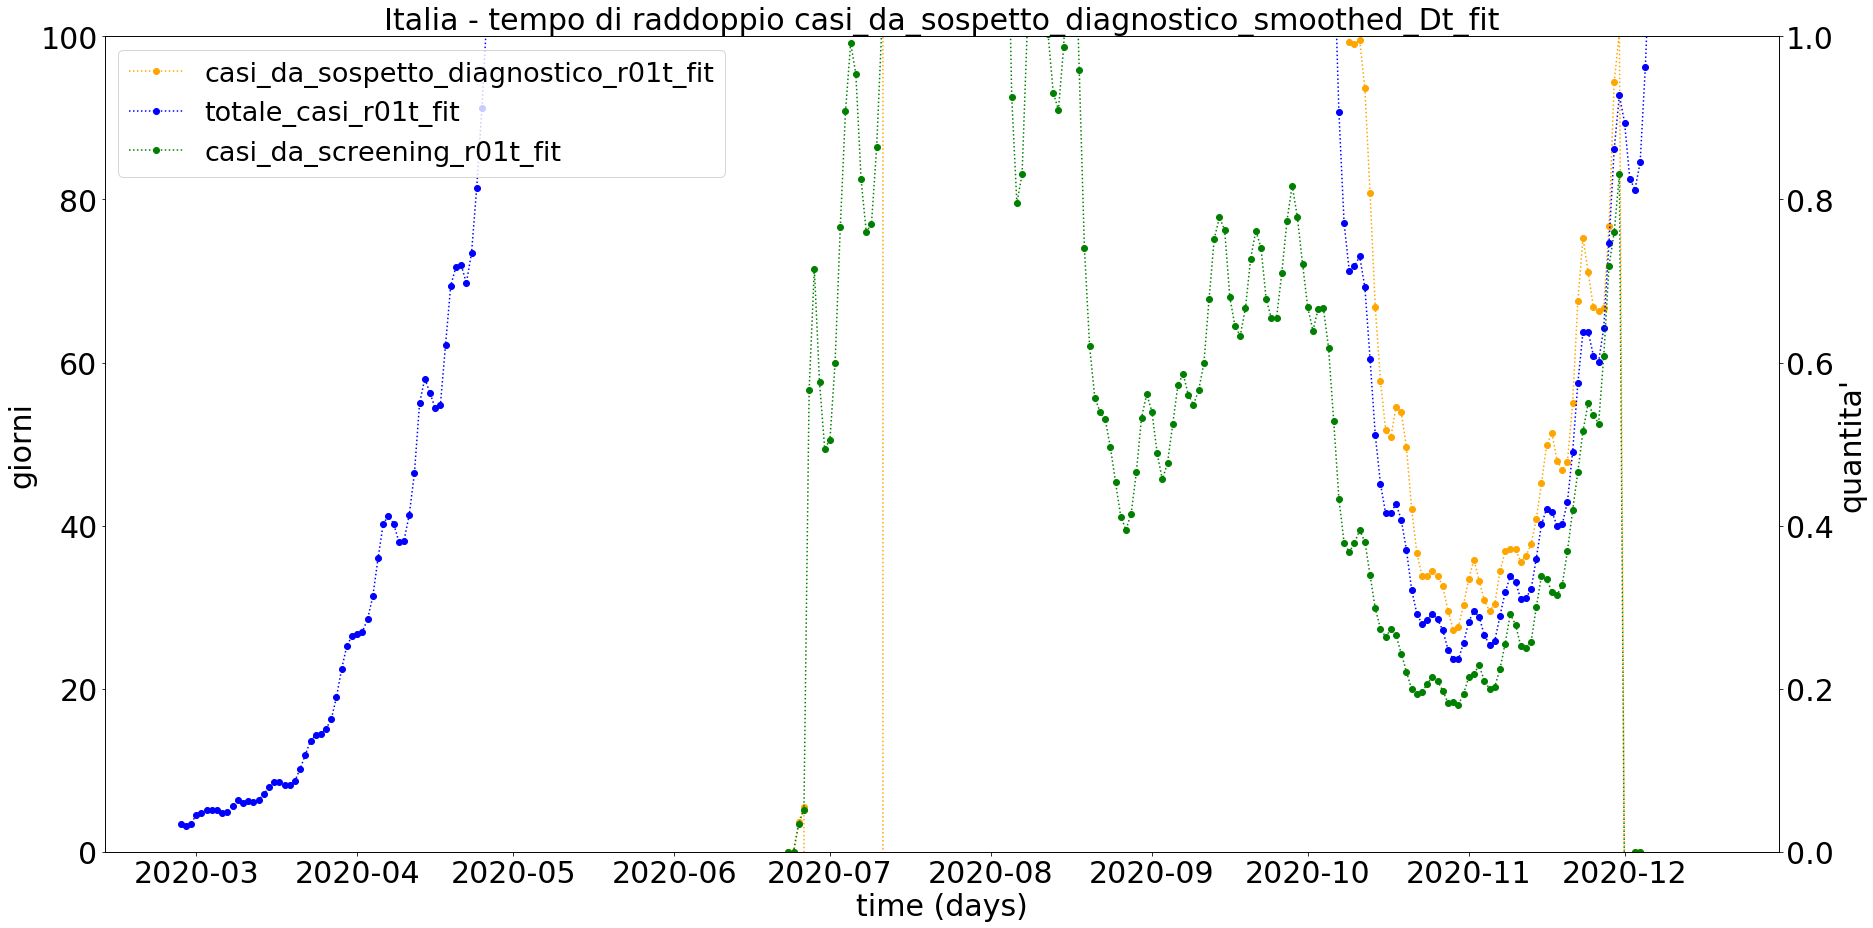

In [87]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Italia - tempo di raddoppio casi_da_sospetto_diagnostico_smoothed_Dt_fit', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('giorni', fontsize=30)
ax1.set_ylim(0,100)
ax1.plot(italy_raw_data.data, italy_raw_data.casi_da_sospetto_diagnostico_r01t_fit, 
         label='casi_da_sospetto_diagnostico_r01t_fit', color='orange', linestyle=':', marker='o')

ax1.plot(italy_raw_data.data, italy_raw_data.totale_casi_r01t_fit, 
         label='totale_casi_r01t_fit', color='blue', linestyle=':', marker='o')

ax1.plot(italy_raw_data.data, italy_raw_data.casi_da_screening_r01t_fit, 
         label='casi_da_screening_r01t_fit', color='green', linestyle=':', marker='o')

#ax1.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14*100, label='diffusione_su_totale_positivi_in_14', color='blue')
ax1.legend(fontsize=27, loc='upper left')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('quantita\'', fontsize=30)
ax2.tick_params(axis='y', labelsize=30)

#ax2.plot(italy_raw_data.data, italy_raw_data.nuovi_positivi_smoothed, label='nuovi positivi giornalieri', color='red')
#ax2.plot(italy_raw_data.data, italy_raw_data.totale_positivi_in_14_smoothed/10, label='DECINE di totale positivi nei 14 gg prec.', color='green')

#ax2.legend(fontsize=27,loc='upper right')

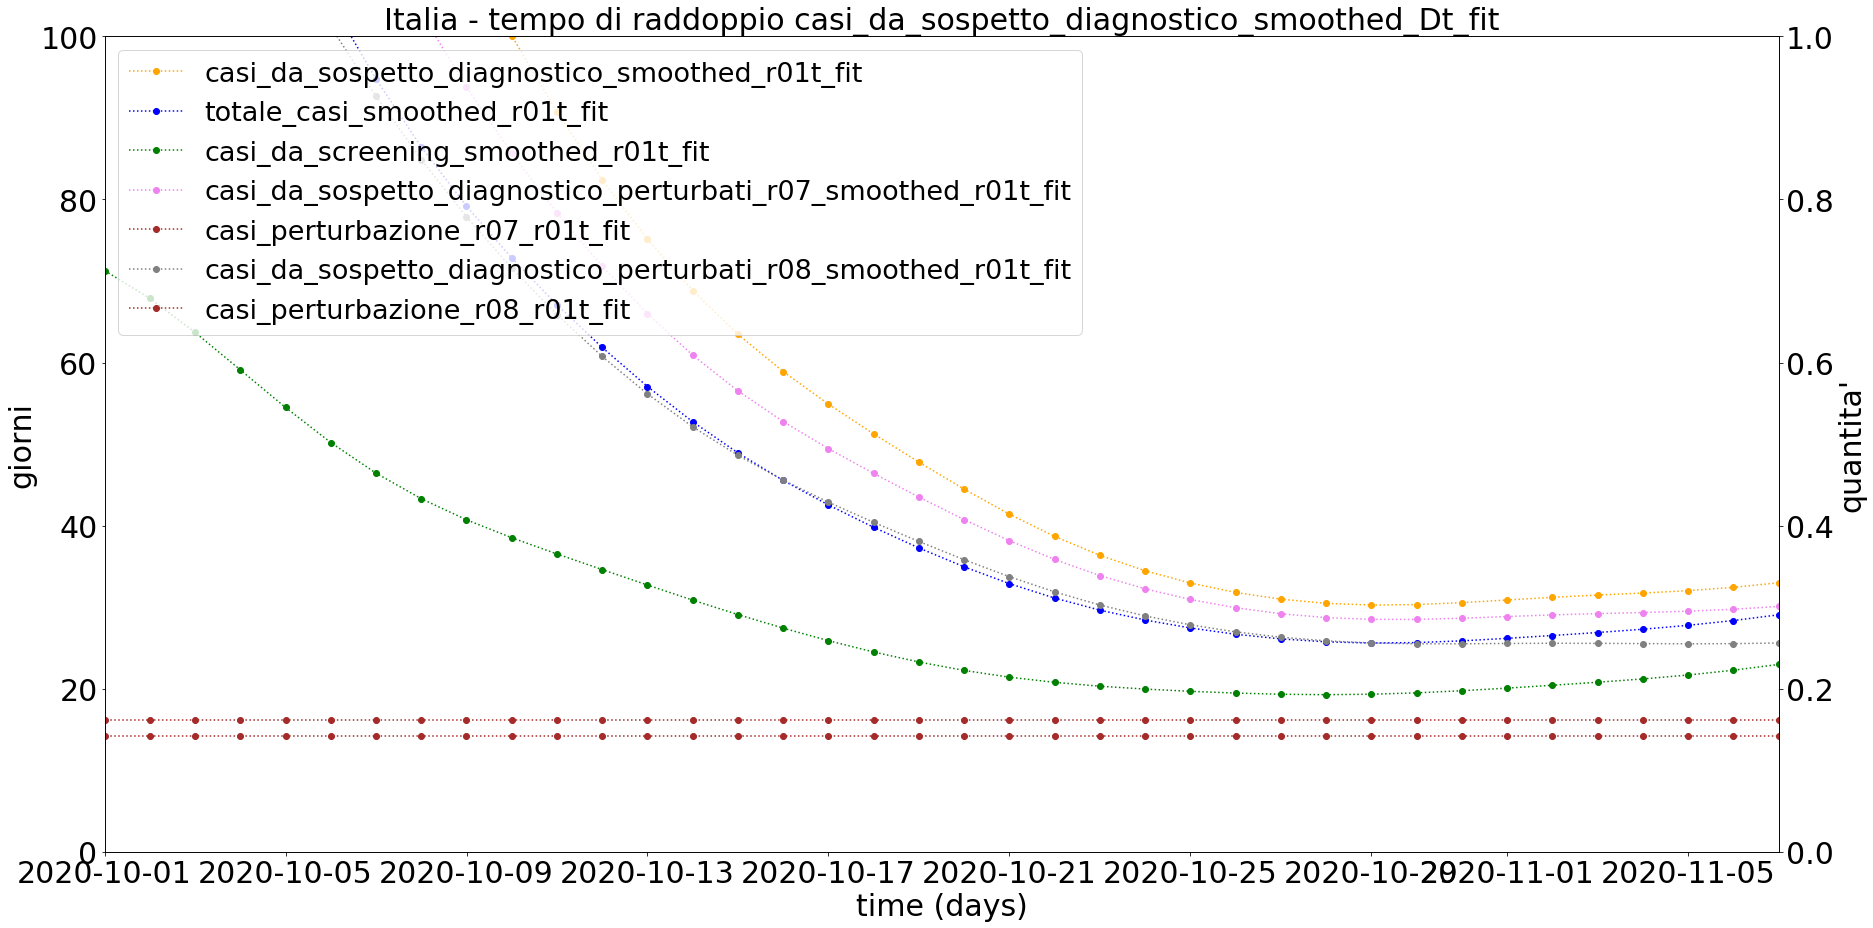

In [88]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Italia - tempo di raddoppio casi_da_sospetto_diagnostico_smoothed_Dt_fit', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('giorni', fontsize=30)
ax1.set_ylim(0,100)
ax1.set_xlim(datetime(2020,10,1),datetime(2020,11,7))
ax1.plot(italy_raw_data.data, italy_raw_data.casi_da_sospetto_diagnostico_smoothed_r01t_fit, 
         label='casi_da_sospetto_diagnostico_smoothed_r01t_fit', color='orange', linestyle=':', marker='o')

ax1.plot(italy_raw_data.data, italy_raw_data.totale_casi_smoothed_r01t_fit, 
         label='totale_casi_smoothed_r01t_fit', color='blue', linestyle=':', marker='o')

ax1.plot(italy_raw_data.data, italy_raw_data.casi_da_screening_smoothed_r01t_fit, 
         label='casi_da_screening_smoothed_r01t_fit', color='green', linestyle=':', marker='o')

ax1.plot(italy_raw_data.data, italy_raw_data.casi_da_sospetto_diagnostico_perturbati_r07_smoothed_r01t_fit, 
         label='casi_da_sospetto_diagnostico_perturbati_r07_smoothed_r01t_fit', color='violet', linestyle=':', marker='o')

ax1.plot(italy_raw_data.data, italy_raw_data.casi_perturbazione_r07_r01t_fit, 
         label='casi_perturbazione_r07_r01t_fit', color='brown', linestyle=':', marker='o')

ax1.plot(italy_raw_data.data, italy_raw_data.casi_da_sospetto_diagnostico_perturbati_r08_smoothed_r01t_fit, 
         label='casi_da_sospetto_diagnostico_perturbati_r08_smoothed_r01t_fit', color='grey', linestyle=':', marker='o')

ax1.plot(italy_raw_data.data, italy_raw_data.casi_perturbazione_r08_r01t_fit, 
         label='casi_perturbazione_r08_r01t_fit', color='brown', linestyle=':', marker='o')


#ax1.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14*100, label='diffusione_su_totale_positivi_in_14', color='blue')
ax1.legend(fontsize=27, loc='upper left')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('quantita\'', fontsize=30)
ax2.tick_params(axis='y', labelsize=30)

#ax2.plot(italy_raw_data.data, italy_raw_data.nuovi_positivi_smoothed, label='nuovi positivi giornalieri', color='red')
#ax2.plot(italy_raw_data.data, italy_raw_data.totale_positivi_in_14_smoothed/10, label='DECINE di totale positivi nei 14 gg prec.', color='green')

#ax2.legend(fontsize=27,loc='upper right')

La perturbazione $p_t$ e' definita come:

$ p_{t+1} = p_t \times (1 + r) $

dove $r$ è il tasso di crescita della perturbazione

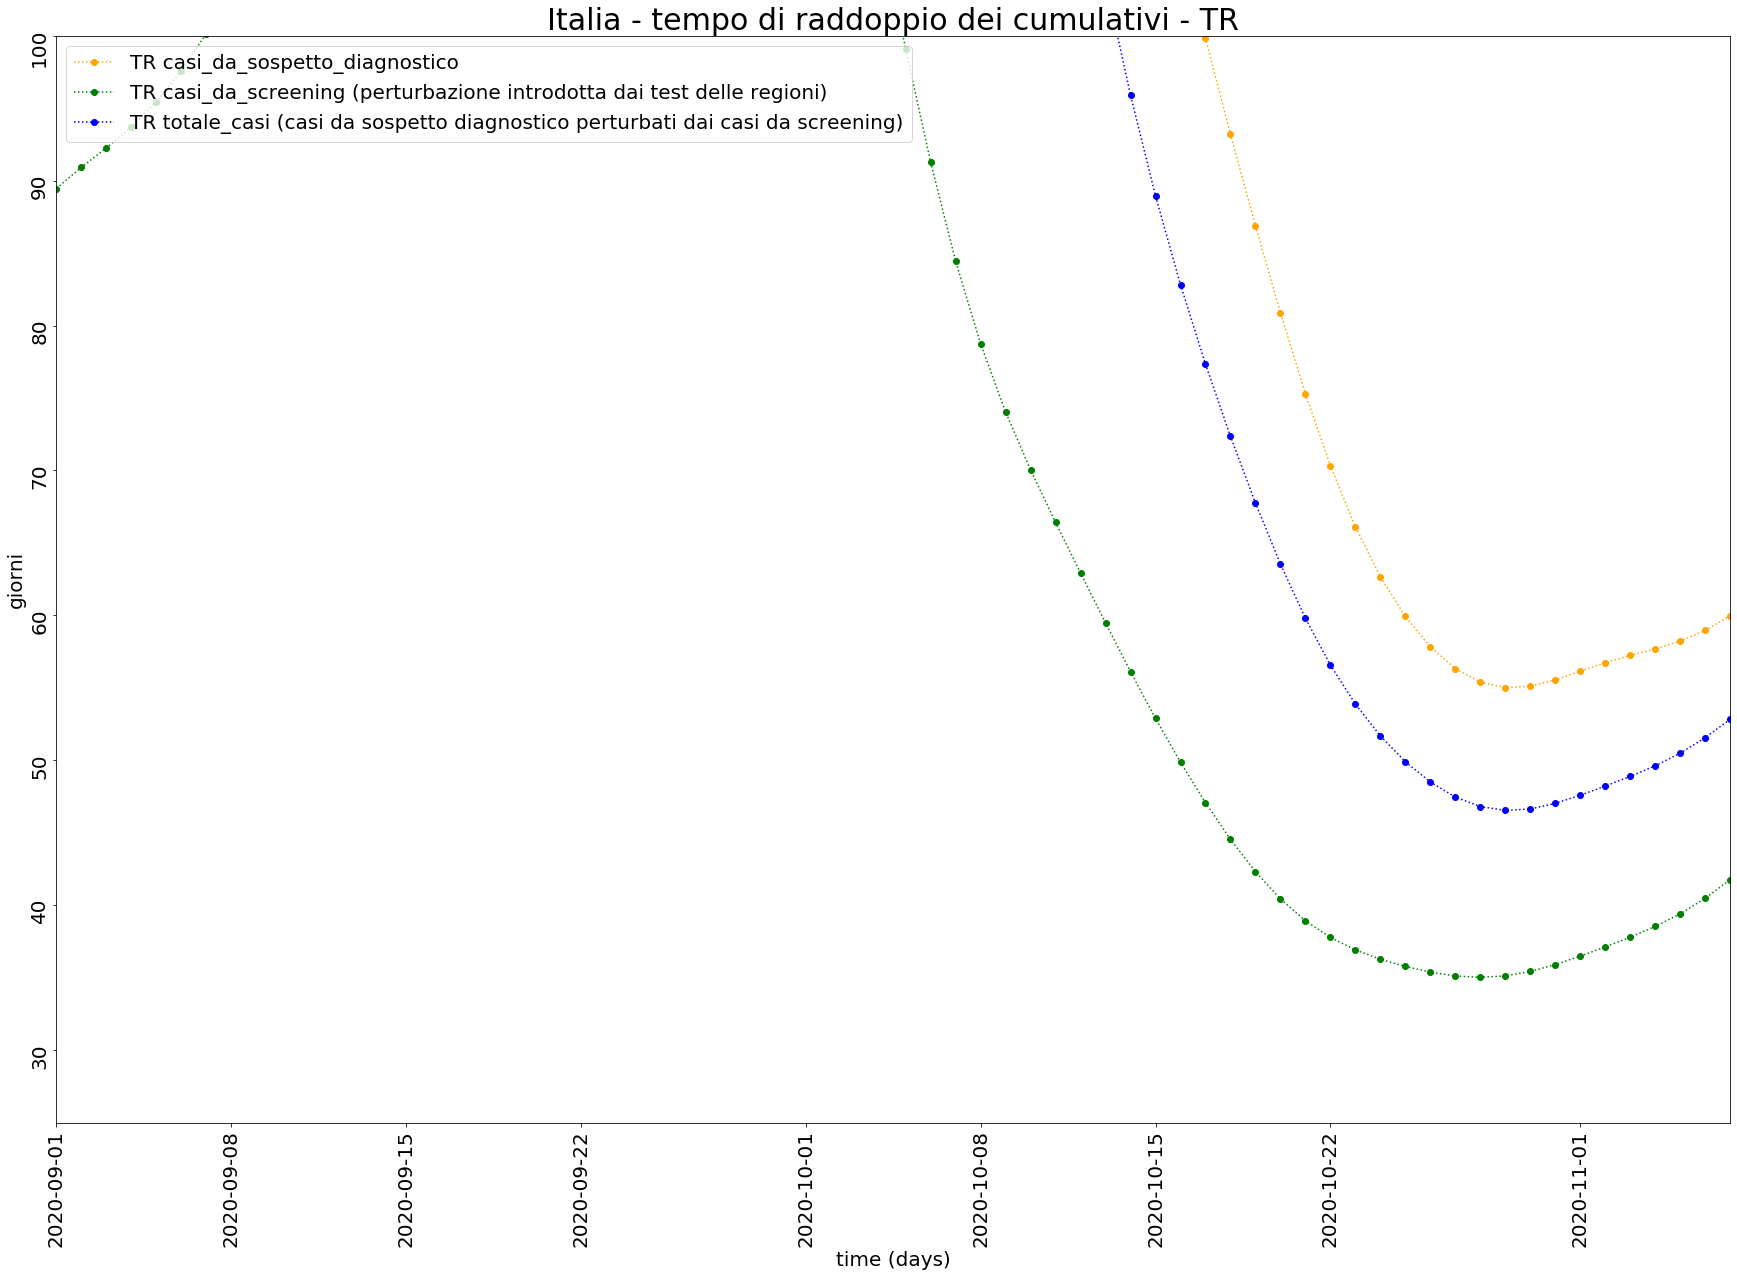

In [89]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,20))
ax1.set_title('Italia - tempo di raddoppio dei cumulativi - TR', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=20)
ax1.tick_params(axis='both', labelsize=20, labelrotation=90)
ax1.set_ylabel('giorni', fontsize=20)
ax1.set_ylim(25,100)
ax1.set_xlim(datetime(2020,9,1),datetime(2020,11,7))
ax1.plot(italy_raw_data.data, italy_raw_data.casi_da_sospetto_diagnostico_smoothed_Dt_fit, 
         label='TR casi_da_sospetto_diagnostico', color='orange', linestyle=':', marker='o')

ax1.plot(italy_raw_data.data, italy_raw_data.casi_da_screening_smoothed_Dt_fit, 
         label='TR casi_da_screening (perturbazione introdotta dai test delle regioni)', color='green', linestyle=':', marker='o')

ax1.plot(italy_raw_data.data, italy_raw_data.totale_casi_smoothed_Dt_fit, 
         label='TR totale_casi (casi da sospetto diagnostico perturbati dai casi da screening)', color='blue', linestyle=':', marker='o')

#ax1.plot(italy_raw_data.data, italy_raw_data.casi_da_sospetto_diagnostico_perturbati_const_50k_smoothed_Dt_fit, 
#         label='TR casi_da_sospetto_diagnostico_perturbati_const_50k', color='red', linestyle=':', marker='o')
#
#ax1.plot(italy_raw_data.data, italy_raw_data.casi_da_sospetto_diagnostico_perturbati_lin_10k_smoothed_Dt_fit, 
#         label='TR casi_da_sospetto_diagnostico_perturbati_lin_10k_smoothed_Dt_fit', color='brown', linestyle=':', marker='o')
#
#
#ax1.plot(italy_raw_data.data, italy_raw_data.casi_da_sospetto_diagnostico_perturbati_rsin_smoothed_Dt_fit, 
#         label='TR casi_da_sospetto_diagnostico_perturbati_rsin_smoothed', color='violet', linestyle=':', marker='o')


#ax1.plot(italy_raw_data.data, italy_raw_data.casi_perturbazione_r07_Dt_fit, 
#         label='TR perturbazione r=0.07', color='violet', linestyle=':', marker='o')
#
#
#ax1.plot(italy_raw_data.data, italy_raw_data.casi_da_sospetto_diagnostico_perturbati_r07_smoothed_Dt_fit, 
#         label='TR casi_da_sospetto_diagnostico perturbati con r=0.07', color='violet', linestyle=':', marker='o')
#
#ax1.plot(italy_raw_data.data, italy_raw_data.casi_perturbazione_r08_Dt_fit, 
#         label='TR perturbazione r=0.08', color='grey', linestyle=':', marker='o')
#
#ax1.plot(italy_raw_data.data, italy_raw_data.casi_da_sospetto_diagnostico_perturbati_r08_smoothed_Dt_fit, 
#         label='TR casi_da_sospetto_diagnostico perturbati con r=0.08', color='grey', linestyle=':', marker='o')
#


#ax1.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14*100, label='diffusione_su_totale_positivi_in_14', color='blue')
ax1.legend(fontsize=20, loc='upper left')


#ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
#ax2.set_ylabel('quantita\'', fontsize=30)
#ax2.tick_params(axis='y', labelsize=30)

#ax2.plot(italy_raw_data.data, italy_raw_data.nuovi_positivi_smoothed, label='nuovi positivi giornalieri', color='red')
#ax2.plot(italy_raw_data.data, italy_raw_data.totale_positivi_in_14_smoothed/10, label='DECINE di totale positivi nei 14 gg prec.', color='green')

#ax2.legend(fontsize=27,loc='upper right')

In [90]:
italy_raw_data.casi_da_sospetto_diagnostico_perturbati_lin_10k_smoothed_Dt_fit

0             NaN
1             NaN
2        6.668067
3        7.624250
4        8.926699
          ...    
294    399.893647
295    602.152237
296           NaN
297           NaN
298           NaN
Name: casi_da_sospetto_diagnostico_perturbati_lin_10k_smoothed_Dt_fit, Length: 299, dtype: float64

In [91]:
doubling_times

<function __main__.doubling_times(x)>

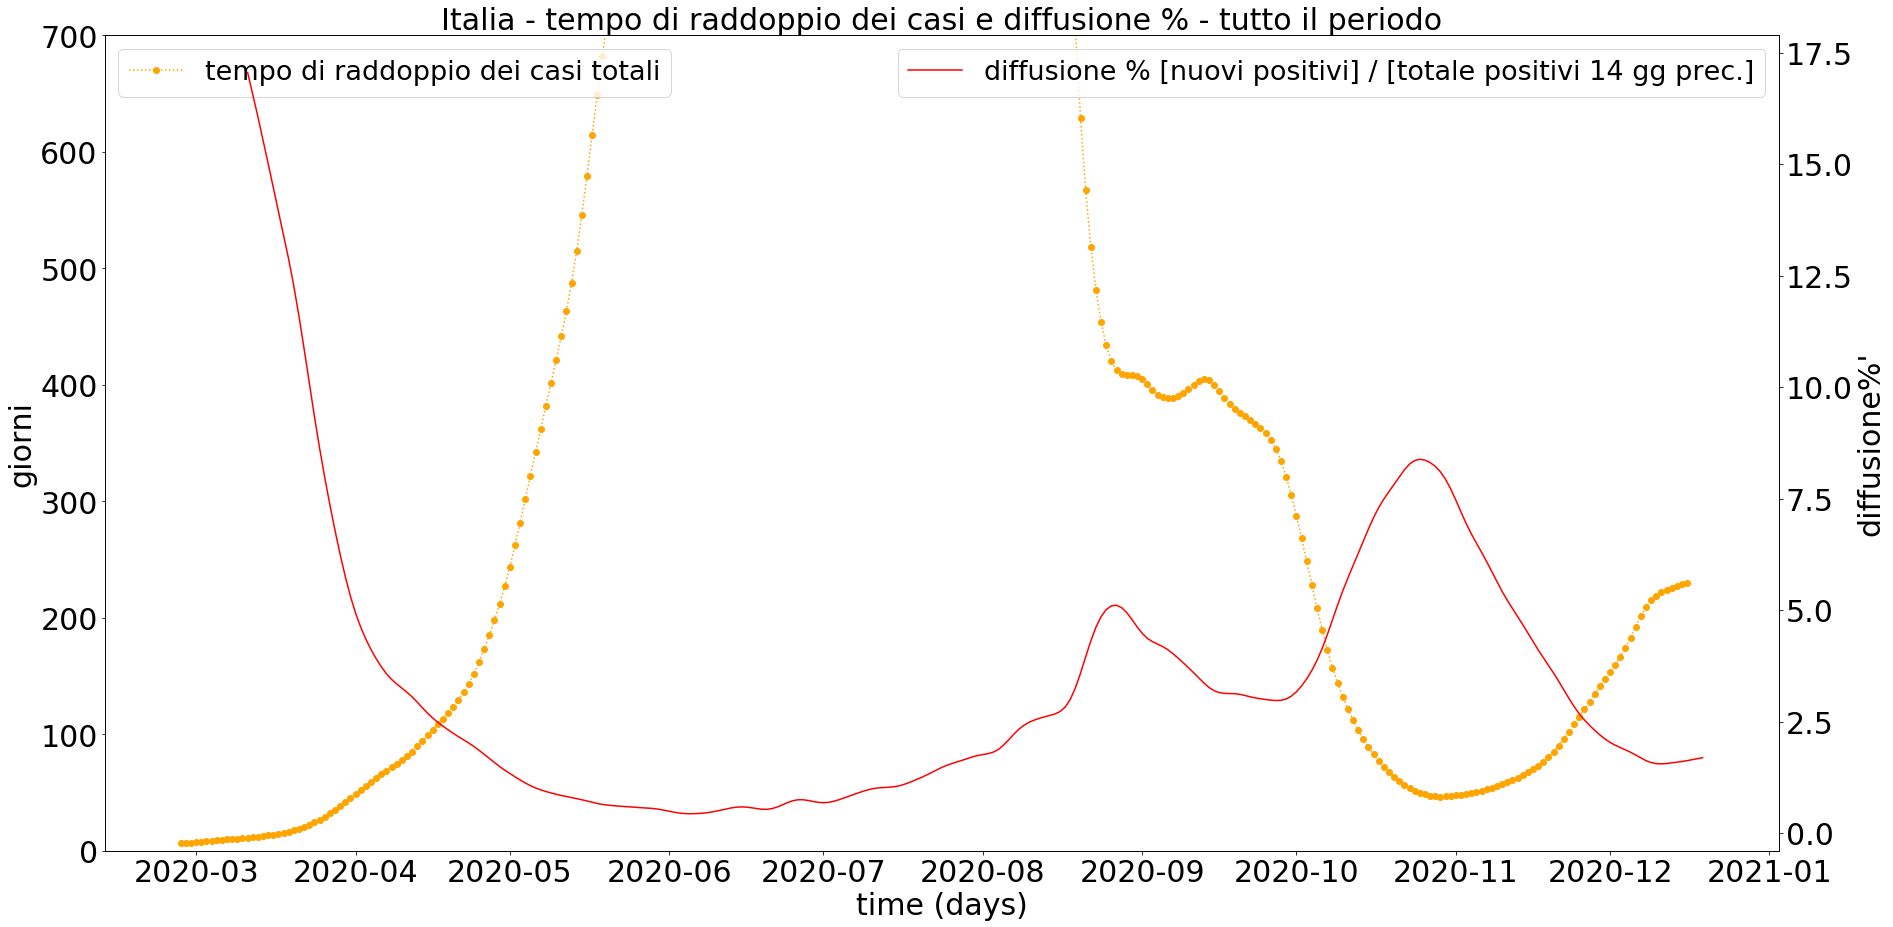

In [92]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Italia - tempo di raddoppio dei casi e diffusione % - tutto il periodo', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('giorni', fontsize=30)
ax1.set_ylim(0,700)
ax1.plot(italy_raw_data.data, italy_raw_data.totale_casi_smoothed_Dt_fit, label='tempo di raddoppio dei casi totali', color='orange', linestyle=':', marker='o')
#ax1.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14*100, label='diffusione_su_totale_positivi_in_14', color='blue')
ax1.legend(fontsize=27, loc='upper left')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('diffusione%\'', fontsize=30)
ax2.tick_params(axis='y', labelsize=30)

ax2.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14_smoothed*100, label='diffusione % [nuovi positivi] / [totale positivi 14 gg prec.]', color='red')
#ax2.plot(italy_raw_data.data, italy_raw_data.totale_positivi_in_14_smoothed/10, label='DECINE di totale positivi nei 14 gg prec.', color='green')

ax2.legend(fontsize=27,loc='upper right')

In [93]:
italy_raw_data['deceduti_smoothed_Dt_fit'] = fitted_doubling_time(italy_raw_data.deceduti_smoothed)
italy_raw_data['deceduti_giornalieri_smoothed_Dt_fit'] = fitted_doubling_time(italy_raw_data.deceduti_giornalieri_smoothed)
italy_raw_data['terapia_intensiva_smoothed_Dt_fit'] = fitted_doubling_time(italy_raw_data.terapia_intensiva_smoothed)

### doubling time of deaths

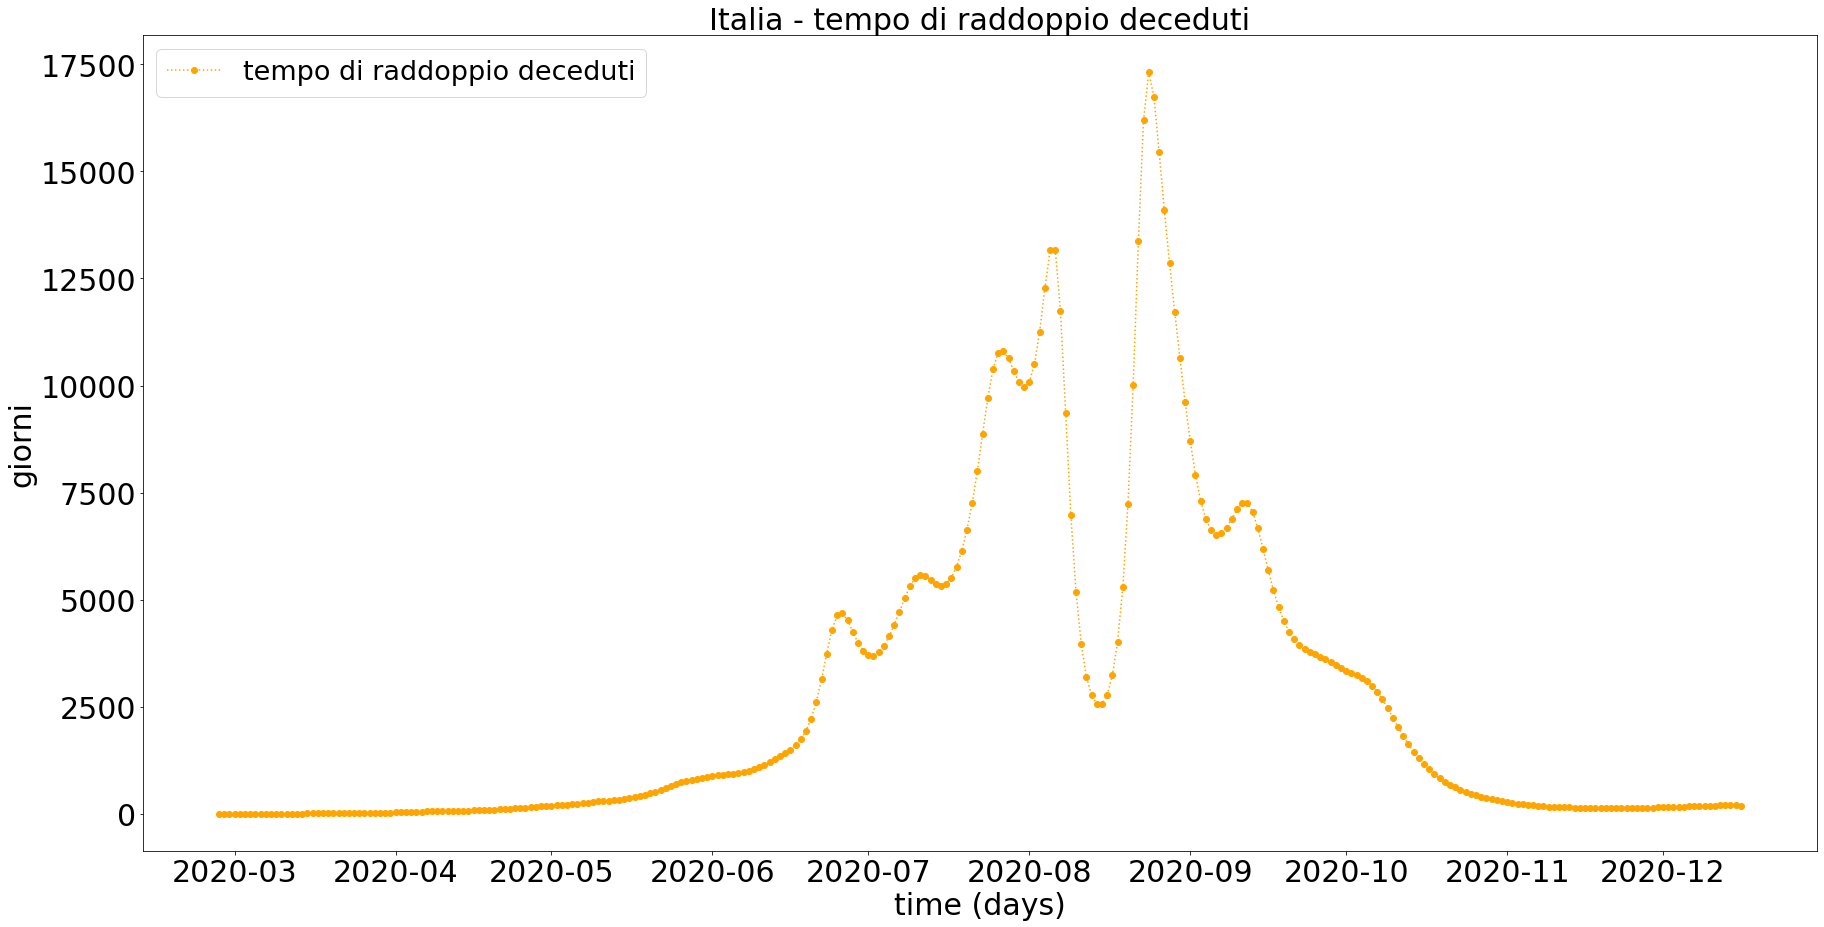

In [94]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Italia - tempo di raddoppio deceduti', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('giorni', fontsize=30)
#ax1.set_ylim(0,100)
ax1.plot(italy_raw_data.data, italy_raw_data.deceduti_smoothed_Dt_fit, label='tempo di raddoppio deceduti', color='orange', linestyle=':', marker='o')
#ax1.plot(italy_raw_data.data, italy_raw_data.terapia_intensiva_smoothed_Dt_fit, label='tempo di raddoppio terapie intensive', color='blue')
ax1.legend(fontsize=27, loc='upper left')


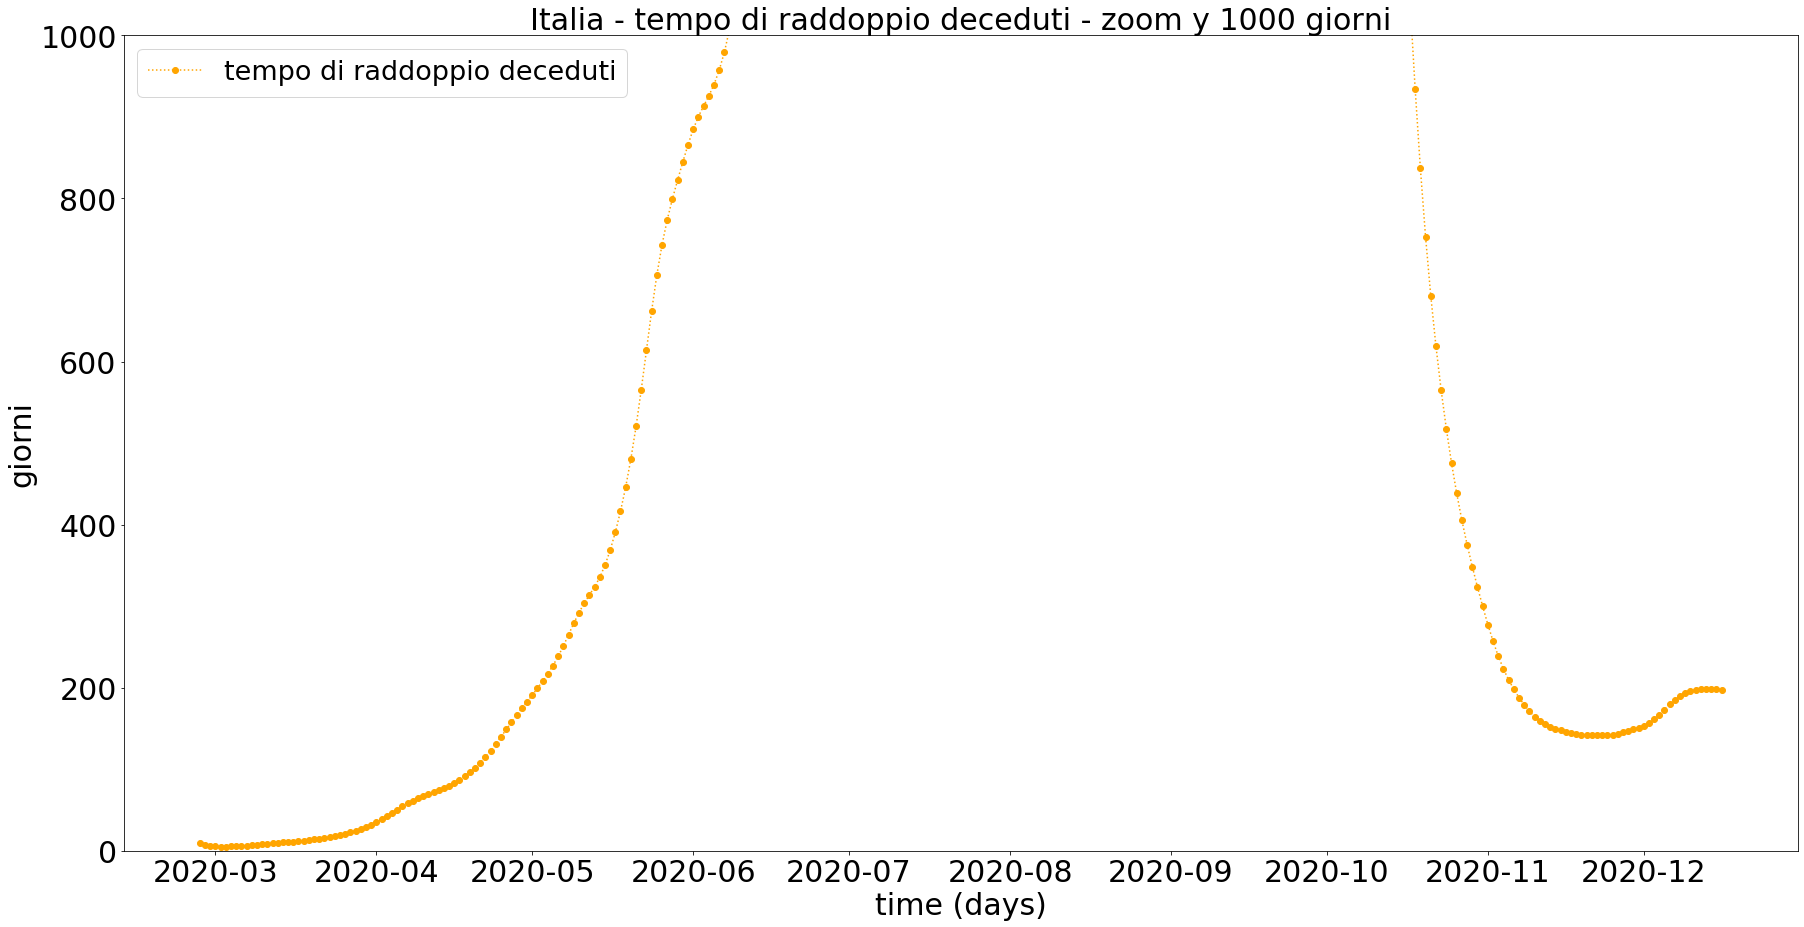

In [95]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Italia - tempo di raddoppio deceduti - zoom y 1000 giorni', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('giorni', fontsize=30)
ax1.set_ylim(0,1000)
ax1.plot(italy_raw_data.data, italy_raw_data.deceduti_smoothed_Dt_fit, label='tempo di raddoppio deceduti', color='orange', linestyle=':', marker='o')
#ax1.plot(italy_raw_data.data, italy_raw_data.terapia_intensiva_smoothed_Dt_fit, label='tempo di raddoppio terapie intensive', color='blue')
ax1.legend(fontsize=27, loc='upper left')


### Doubling time terapia intensiva

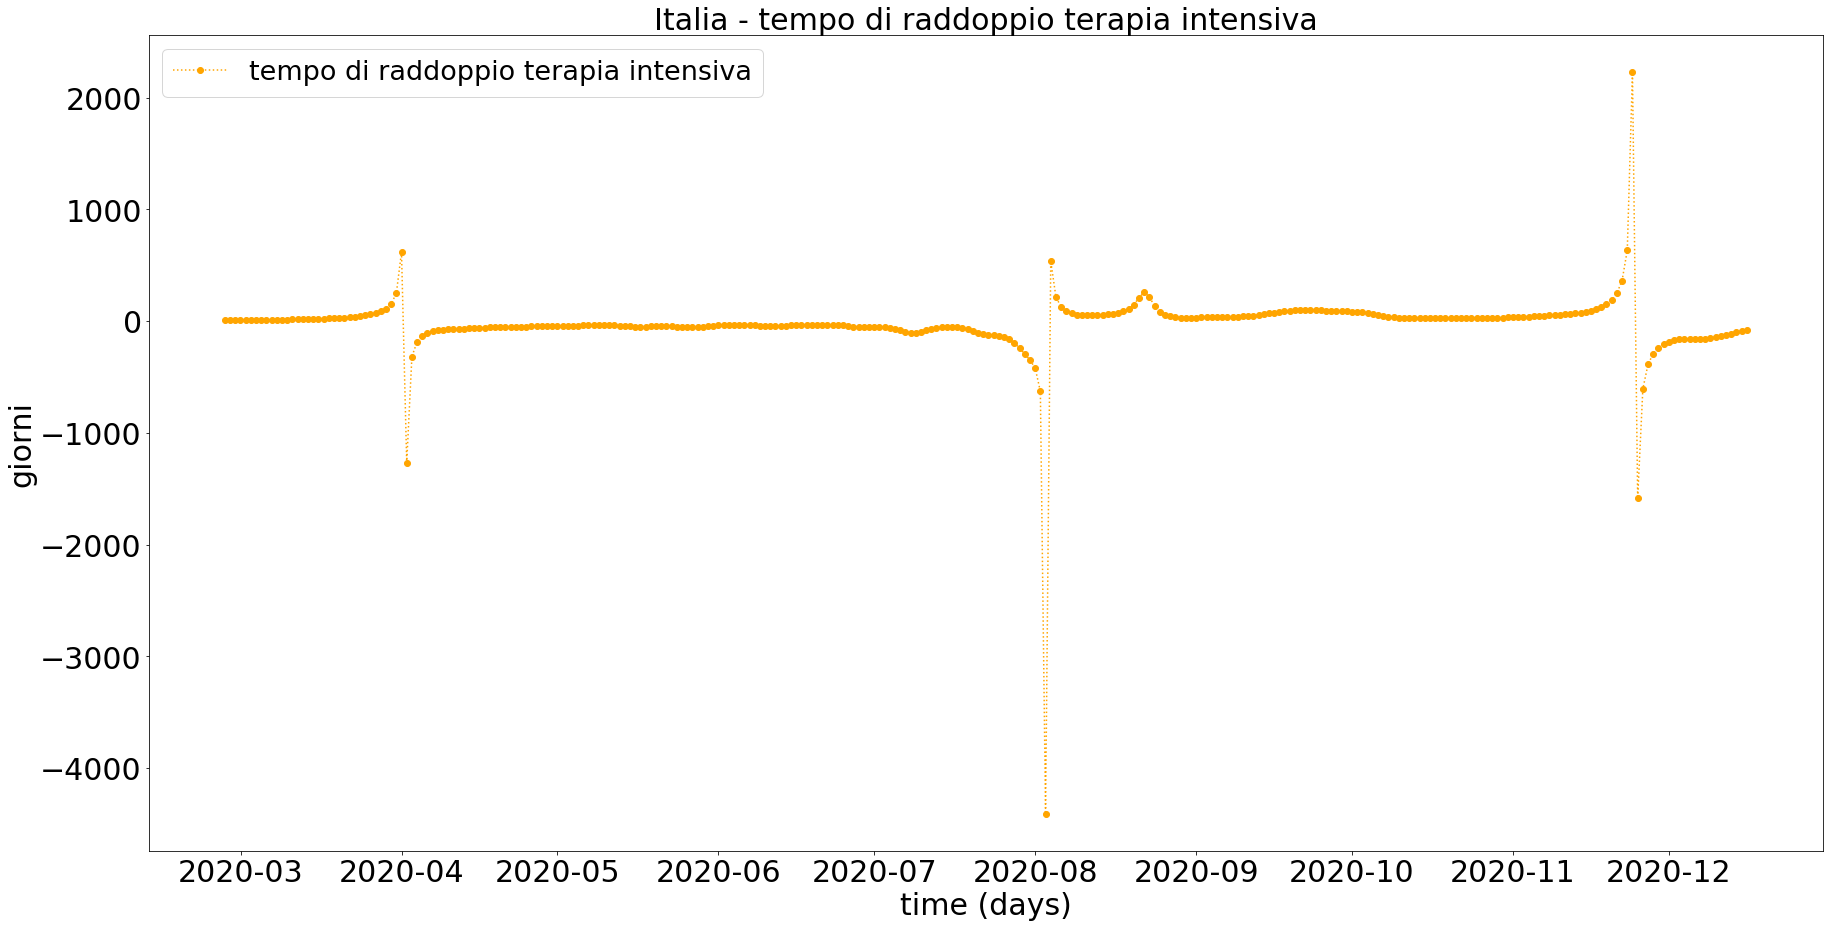

In [96]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Italia - tempo di raddoppio terapia intensiva', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('giorni', fontsize=30)
#ax1.set_ylim(0,1000)
ax1.plot(italy_raw_data.data, italy_raw_data.terapia_intensiva_smoothed_Dt_fit, label='tempo di raddoppio terapia intensiva', color='orange', linestyle=':', marker='o')
#ax1.plot(italy_raw_data.data, italy_raw_data.terapia_intensiva_smoothed_Dt_fit, label='tempo di raddoppio terapie intensive', color='blue')
ax1.legend(fontsize=27, loc='upper left')


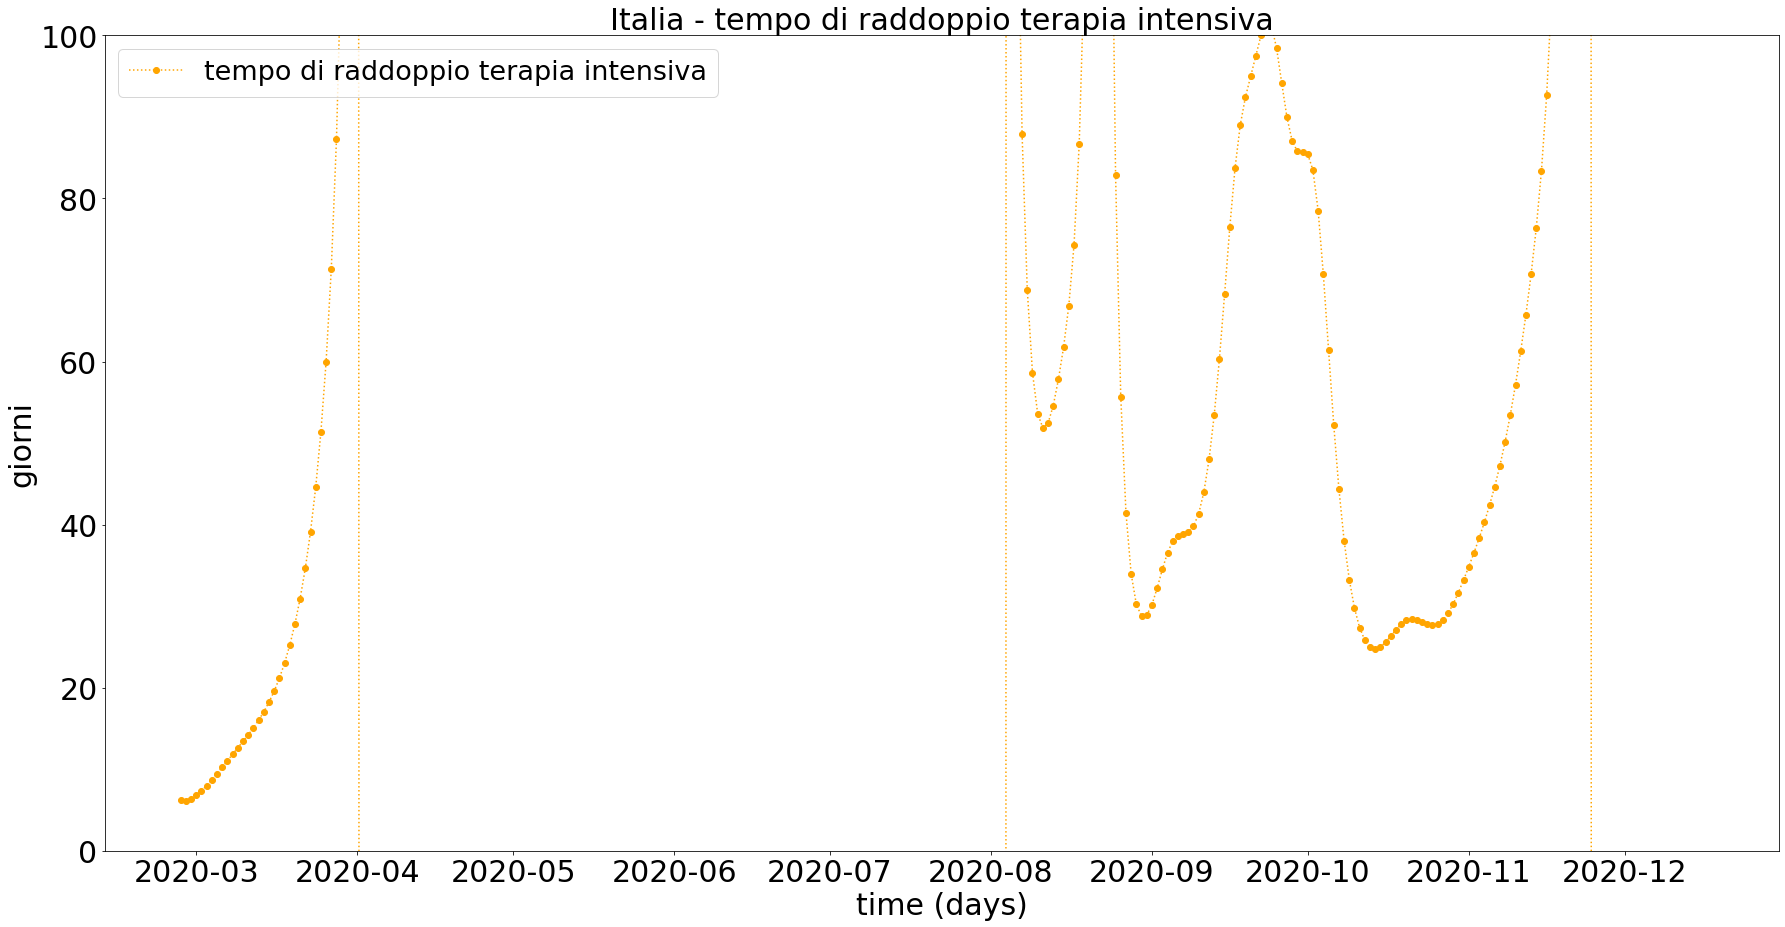

In [97]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Italia - tempo di raddoppio terapia intensiva', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('giorni', fontsize=30)
ax1.set_ylim(0,100)
ax1.plot(italy_raw_data.data, italy_raw_data.terapia_intensiva_smoothed_Dt_fit, label='tempo di raddoppio terapia intensiva', color='orange', linestyle=':', marker='o')
#ax1.plot(italy_raw_data.data, italy_raw_data.terapia_intensiva_smoothed_Dt_fit, label='tempo di raddoppio terapie intensive', color='blue')
ax1.legend(fontsize=27, loc='upper left')


### doubling time totale positivi giornalieri

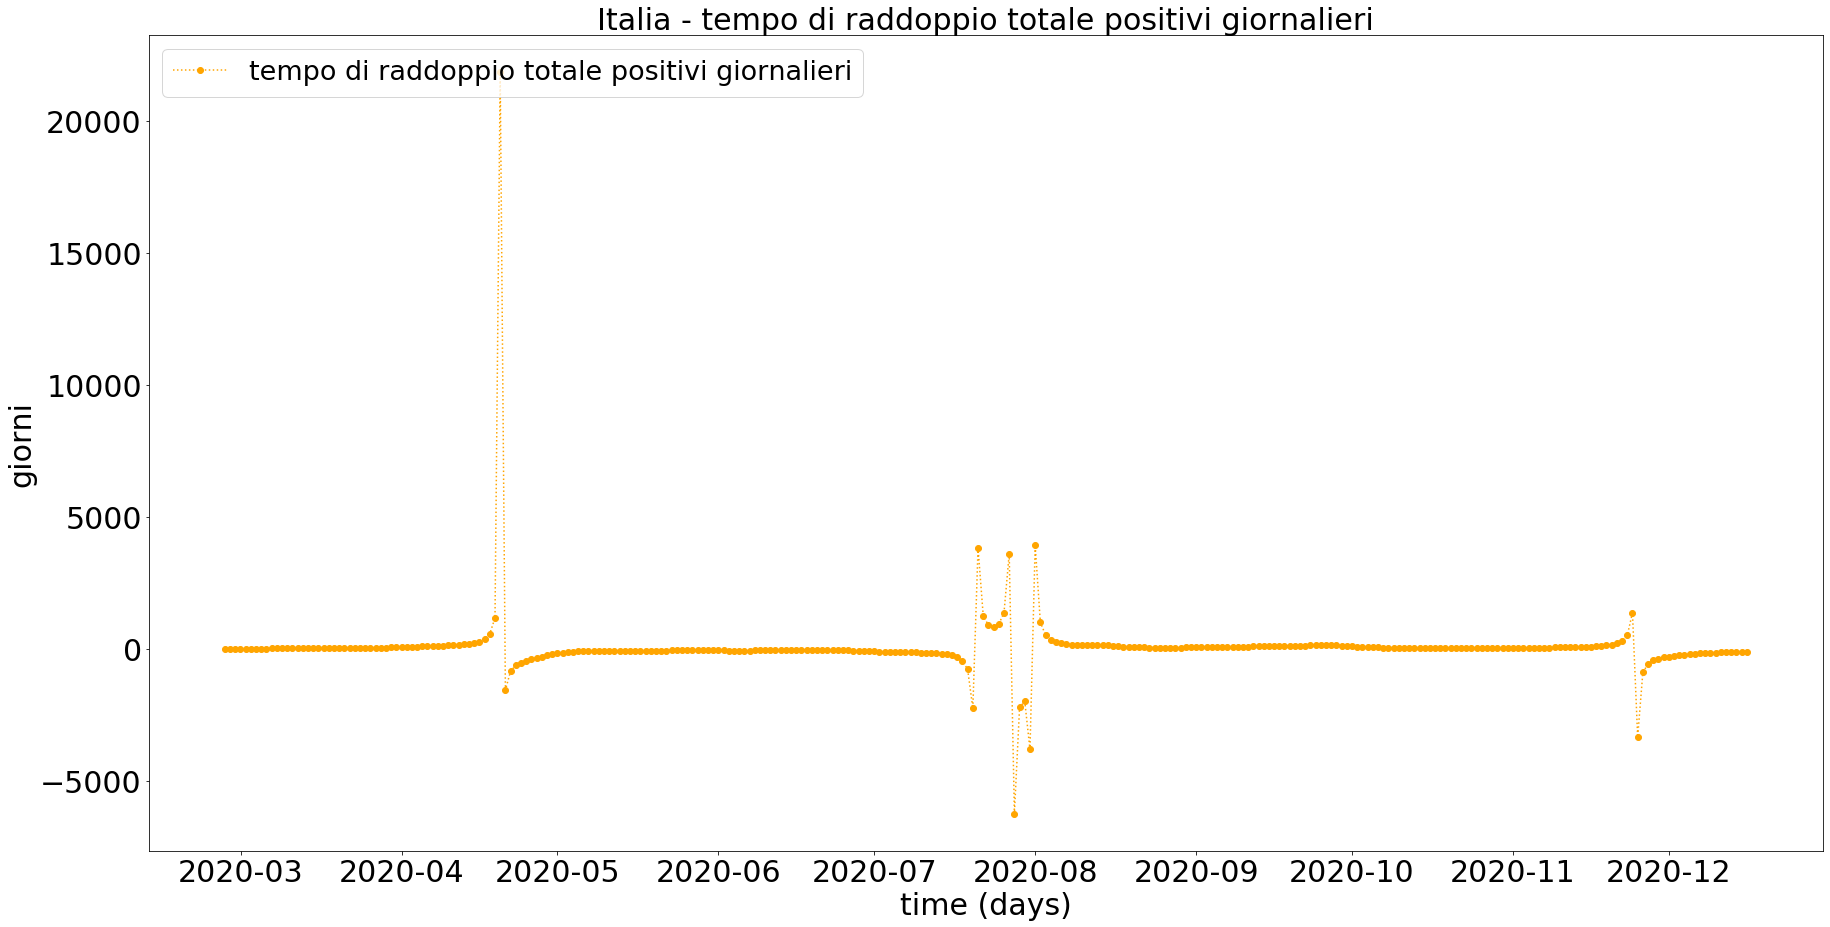

In [98]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Italia - tempo di raddoppio totale positivi giornalieri', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('giorni', fontsize=30)
#ax1.set_ylim(0,1000)
ax1.plot(italy_raw_data.data, italy_raw_data.totale_positivi_smoothed_Dt_fit, label='tempo di raddoppio totale positivi giornalieri', color='orange', linestyle=':', marker='o')
#ax1.plot(italy_raw_data.data, italy_raw_data.terapia_intensiva_smoothed_Dt_fit, label='tempo di raddoppio terapie intensive', color='blue')
ax1.legend(fontsize=27, loc='upper left')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


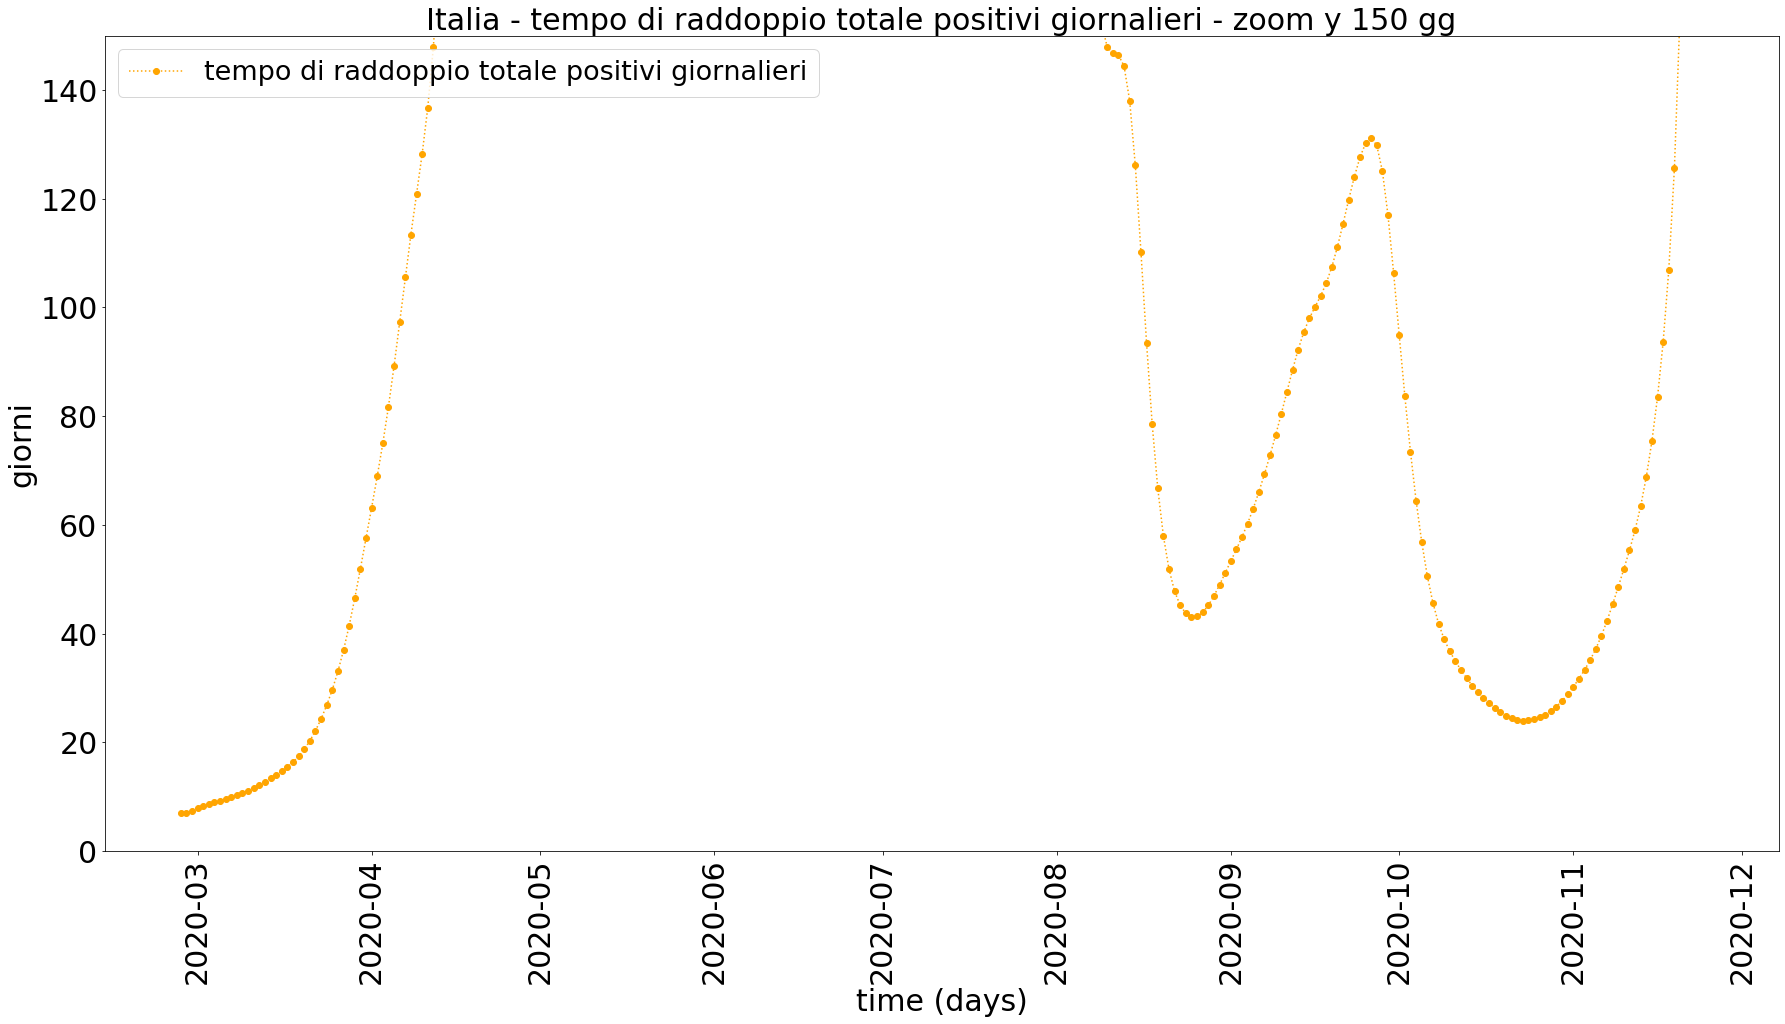

In [99]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Italia - tempo di raddoppio totale positivi giornalieri - zoom y 150 gg', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.tick_params(axis='x', labelrotation=90)
ax1.set_ylabel('giorni', fontsize=30)
ax1.set_ylim(0,150)
#ax1.set_xlim(datetime(2020,10,1),datetime(2020,11,7))

italy_raw_data['totale_positivi_smoothed_Dt_fit_gtzero'] = italy_raw_data.totale_positivi_smoothed_Dt_fit
italy_raw_data.totale_positivi_smoothed_Dt_fit_gtzero[italy_raw_data.totale_positivi_smoothed_Dt_fit_gtzero <0] = np.nan

ax1.plot(italy_raw_data.data, 
         italy_raw_data.totale_positivi_smoothed_Dt_fit_gtzero, 
         label='tempo di raddoppio totale positivi giornalieri', color='orange', linestyle=':', marker='o')
#ax1.plot(italy_raw_data.data, italy_raw_data.terapia_intensiva_smoothed_Dt_fit, label='tempo di raddoppio terapie intensive', color='blue')
ax1.legend(fontsize=27, loc='upper left')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


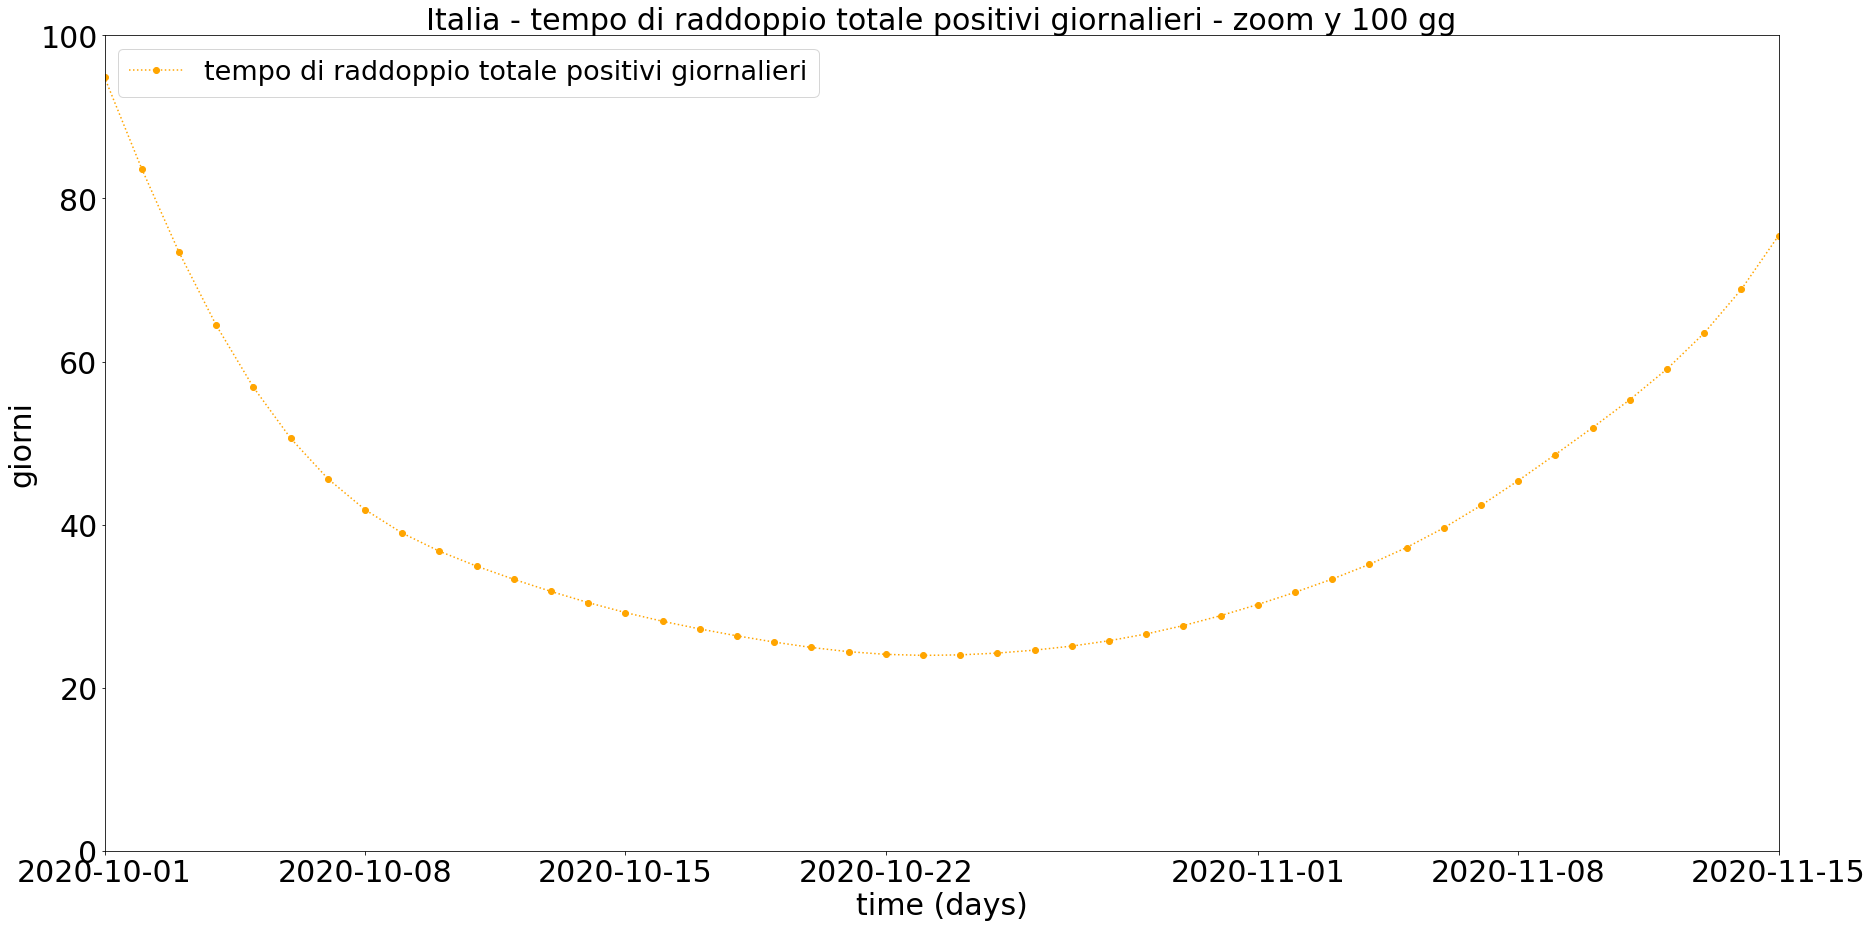

In [100]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Italia - tempo di raddoppio totale positivi giornalieri - zoom y 100 gg', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('giorni', fontsize=30)
ax1.set_ylim(0,100)
ax1.set_xlim(datetime(2020,10,1),datetime(2020,11,15))

italy_raw_data['totale_positivi_smoothed_Dt_fit_gtzero'] = italy_raw_data.totale_positivi_smoothed_Dt_fit
italy_raw_data.totale_positivi_smoothed_Dt_fit_gtzero[italy_raw_data.totale_positivi_smoothed_Dt_fit_gtzero <0] = np.nan

ax1.plot(italy_raw_data.data, 
         italy_raw_data.totale_positivi_smoothed_Dt_fit_gtzero, 
         label='tempo di raddoppio totale positivi giornalieri', color='orange', linestyle=':', marker='o')
#ax1.plot(italy_raw_data.data, italy_raw_data.terapia_intensiva_smoothed_Dt_fit, label='tempo di raddoppio terapie intensive', color='blue')
ax1.legend(fontsize=27, loc='upper left')


In [101]:
italy_raw_data['tamponi_positivi_giornalieri_smoothed'] = italy_raw_data.nuovi_positivi_smoothed/italy_raw_data.tamponi_giornalieri_smoothed
italy_raw_data['tamponi_positivi_cum_smoothed'] = italy_raw_data.totale_casi_smoothed/italy_raw_data.tamponi_smoothed

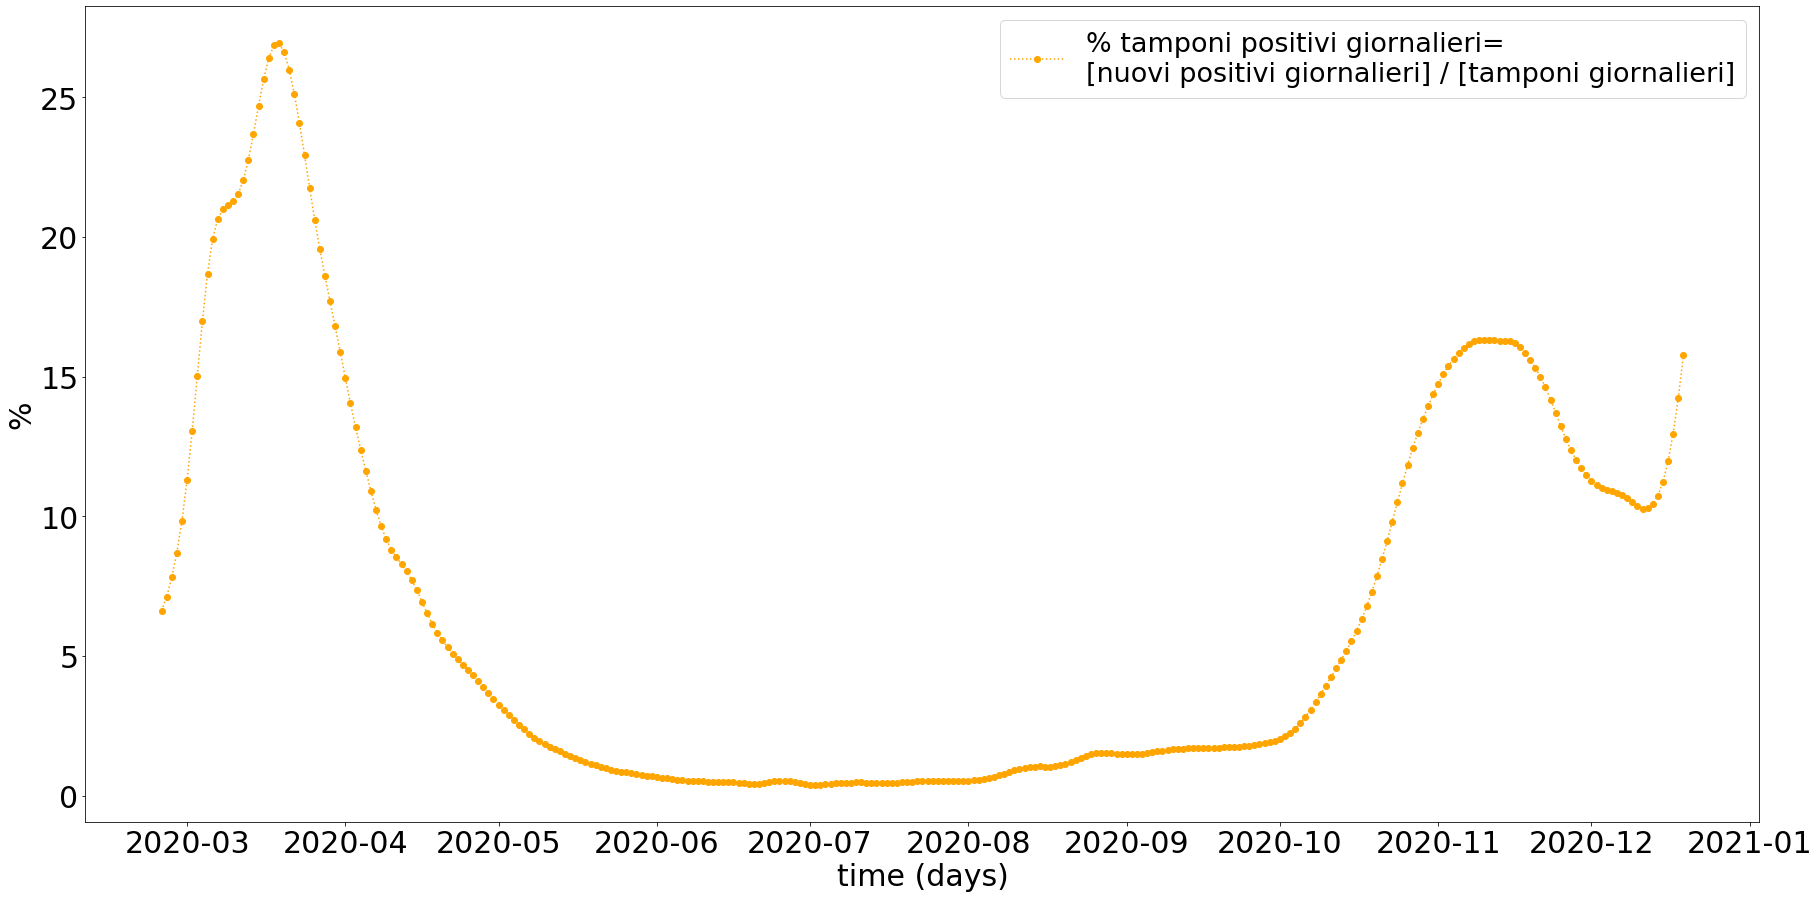

In [102]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,15))
#ax1.set_title('Italia - tempo di raddoppio totale positivi giornalieri - zoom y 50 gg', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('%', fontsize=30)
ax1.plot(italy_raw_data.data, italy_raw_data.tamponi_positivi_giornalieri_smoothed*100, 
         label='% tamponi positivi giornalieri= \n[nuovi positivi giornalieri] / [tamponi giornalieri]', 
         color='orange', linestyle=':', marker='o')
ax1.legend(fontsize=27, loc='upper right')


In [103]:
italy_raw_data['nuovi_positivi_smoothed_Dt_fit'] = fitted_doubling_time(italy_raw_data.nuovi_positivi_smoothed)

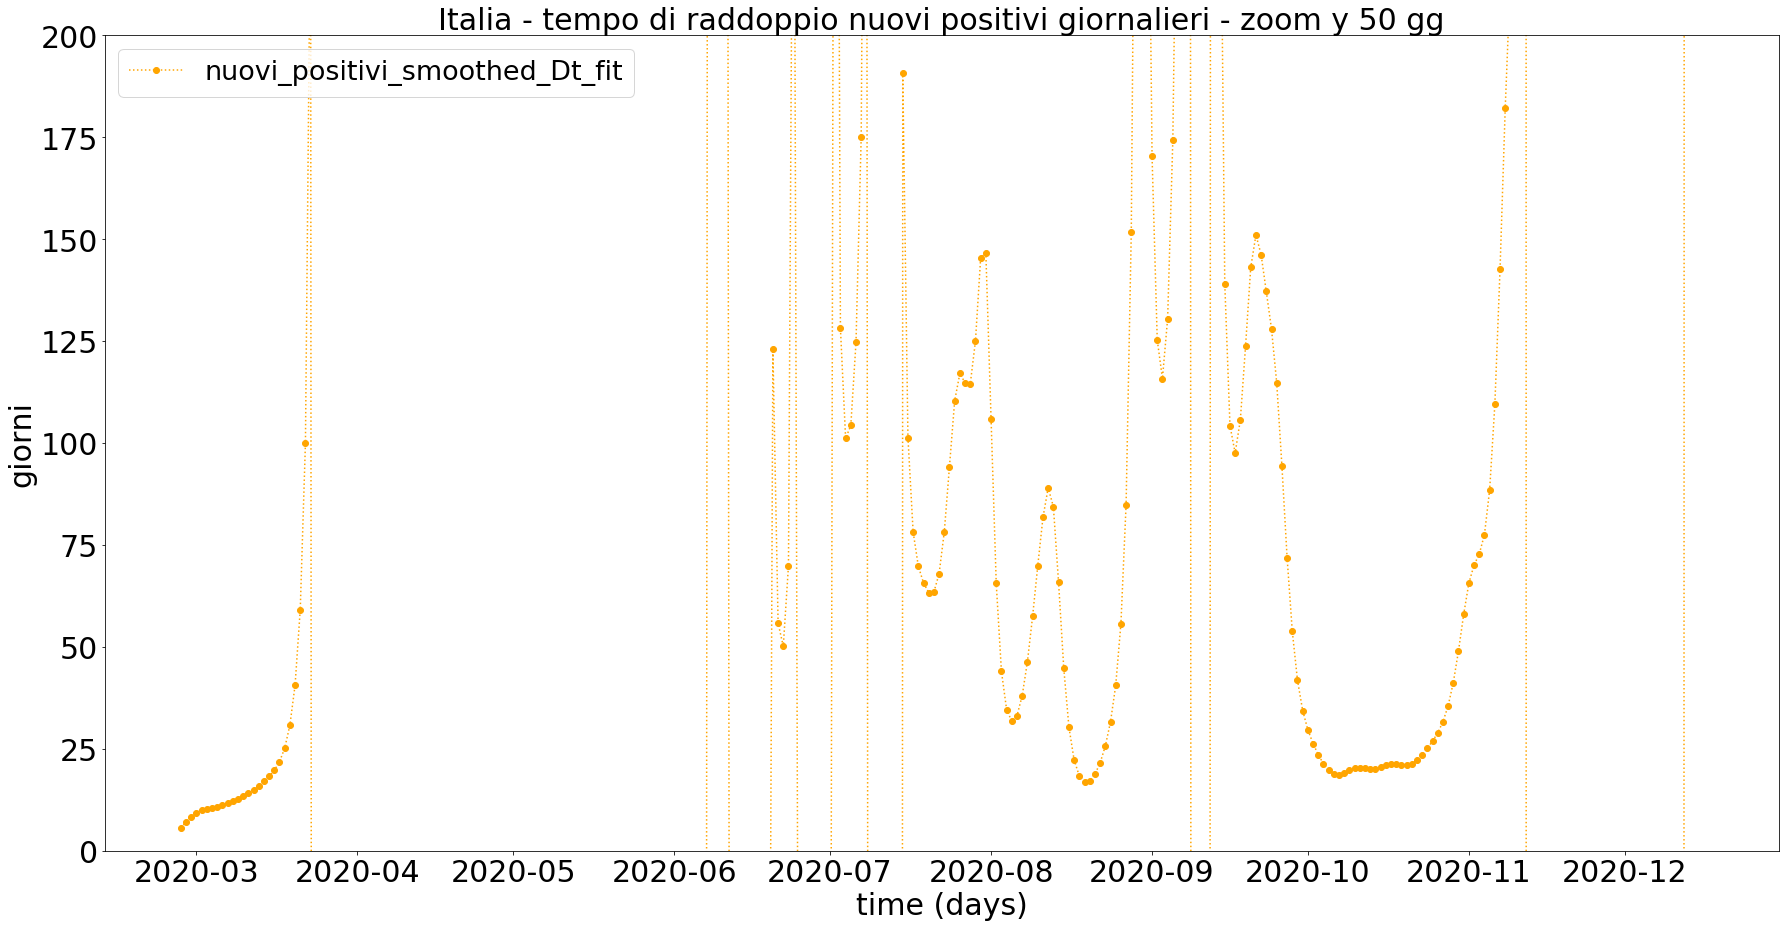

In [104]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Italia - tempo di raddoppio nuovi positivi giornalieri - zoom y 50 gg', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('giorni', fontsize=30)
ax1.set_ylim(0,200)
ax1.plot(italy_raw_data.data, italy_raw_data.nuovi_positivi_smoothed_Dt_fit, label='nuovi_positivi_smoothed_Dt_fit', color='orange', linestyle=':', marker='o')
ax1.legend(fontsize=27, loc='upper left')


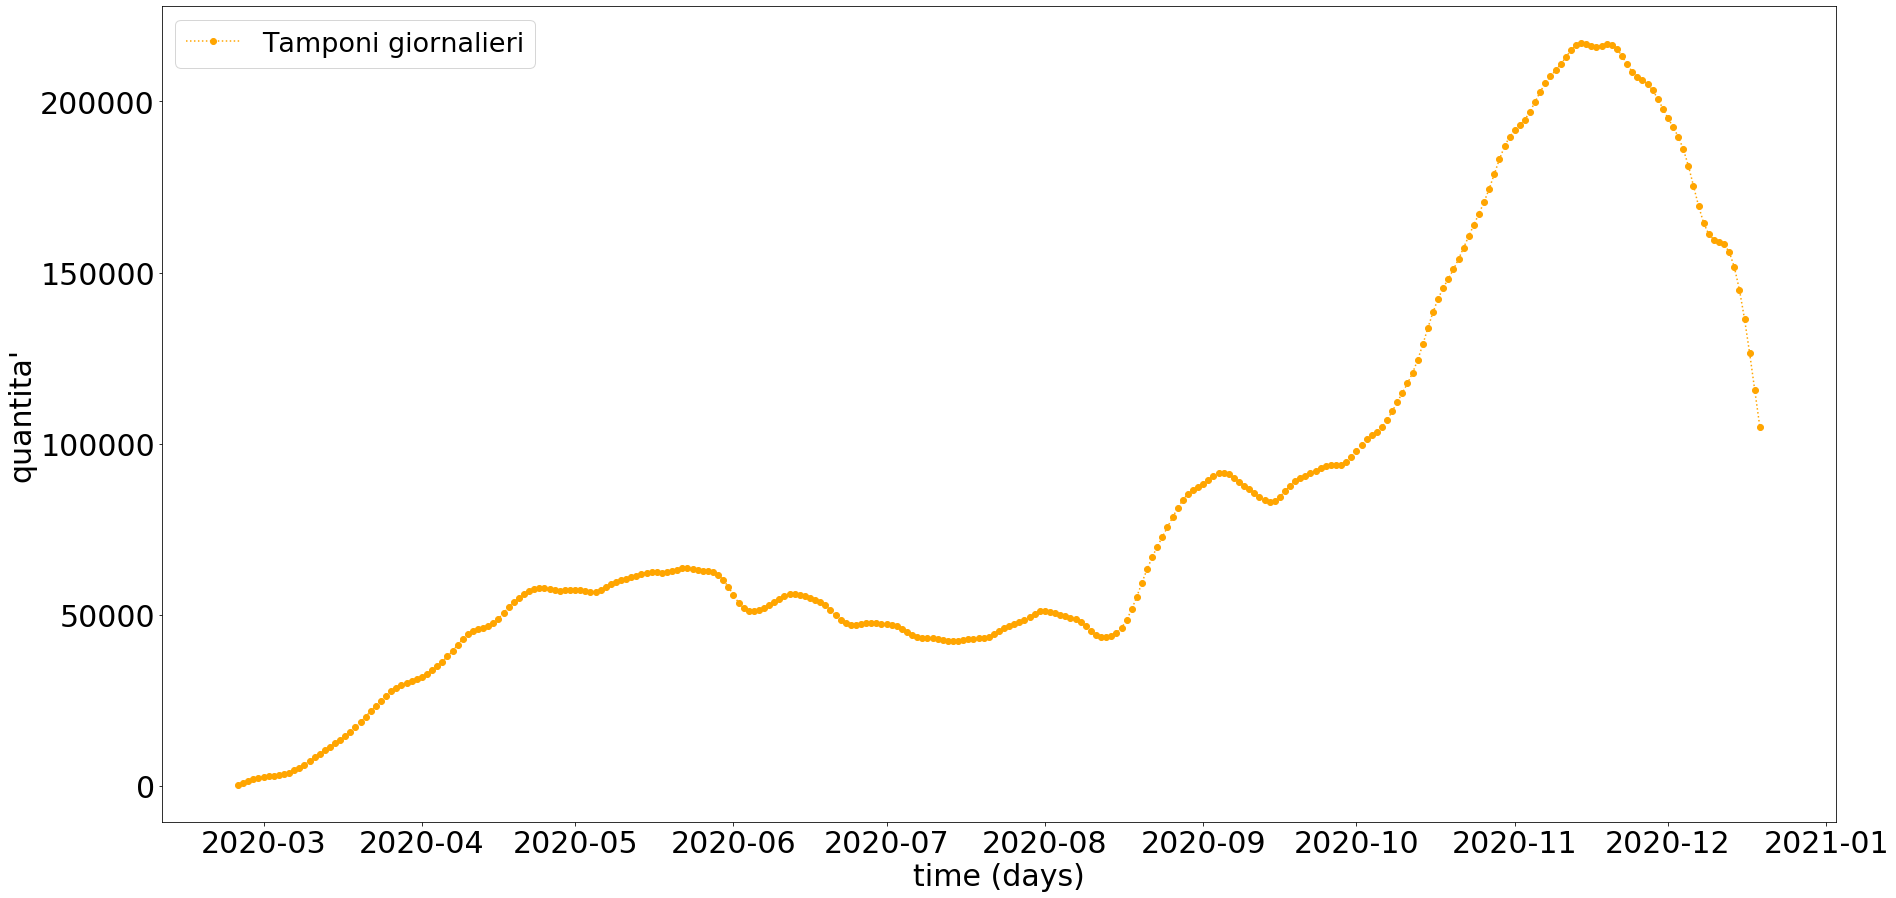

In [105]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,15))
#ax1.set_title('Italia - tempo di raddoppio totale positivi giornalieri - zoom y 50 gg', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('quantita\'', fontsize=30)
#ax1.set_xlim(datetime(2020,10,1),datetime(2020,11,7))
#ax1.set_ylim(0,200)
ax1.plot(italy_raw_data.data, italy_raw_data.tamponi_giornalieri_smoothed, label='Tamponi giornalieri', color='orange', linestyle=':', marker='o')
ax1.legend(fontsize=27, loc='upper left')


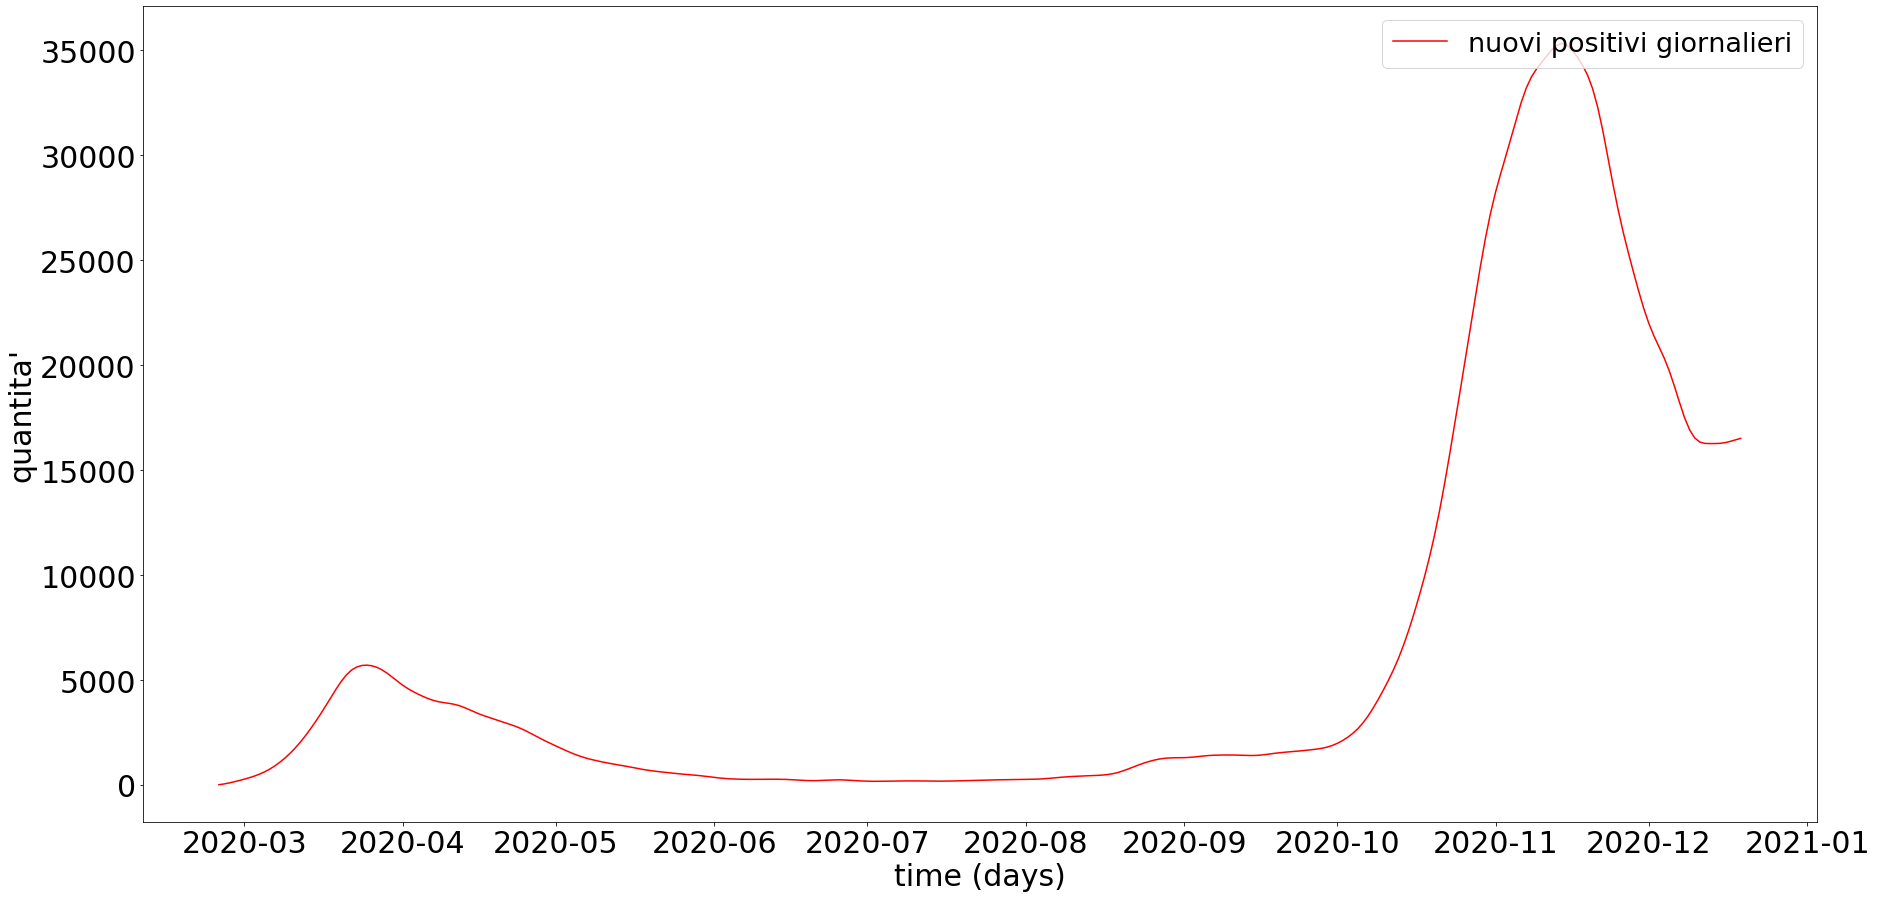

In [106]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,15))
#ax1.set_title('Italia - diffusione - tutto il periodo', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('quantita\'', fontsize=30)

ax1.plot(italy_raw_data.data, italy_raw_data.nuovi_positivi_smoothed, label='nuovi positivi giornalieri', color='red')

ax1.legend(fontsize=27,loc='upper right')

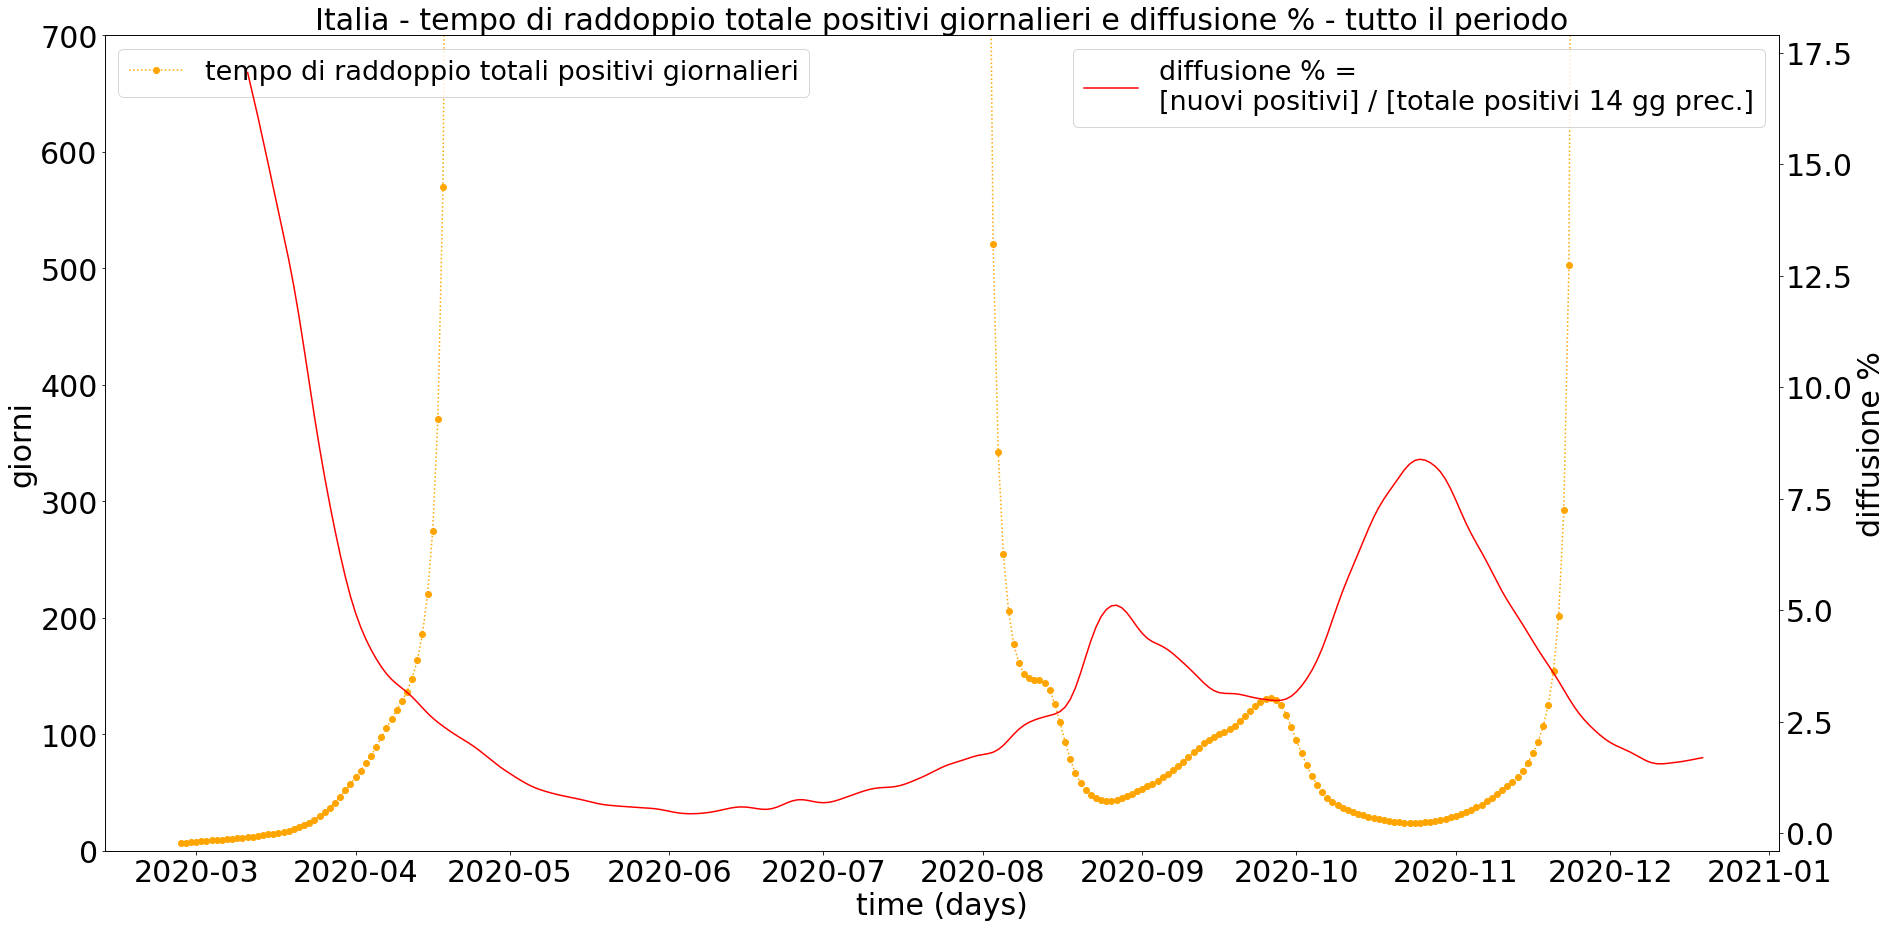

In [107]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Italia - tempo di raddoppio totale positivi giornalieri e diffusione % - tutto il periodo', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.set_ylabel('giorni', fontsize=30)
ax1.set_ylim(0,700)
ax1.plot(italy_raw_data.data, italy_raw_data.totale_positivi_smoothed_Dt_fit_gtzero, label='tempo di raddoppio totali positivi giornalieri', color='orange', linestyle=':', marker='o')
#ax1.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14*100, label='diffusione_su_totale_positivi_in_14', color='blue')
ax1.legend(fontsize=27, loc='upper left')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('diffusione %', fontsize=30)
ax2.tick_params(axis='y', labelsize=30)

ax2.plot(italy_raw_data.data, italy_raw_data.diffusione_su_totale_positivi_in_14_smoothed*100, 
         label='diffusione % =\n[nuovi positivi] / [totale positivi 14 gg prec.]', color='red')
#ax2.plot(italy_raw_data.data, italy_raw_data.totale_positivi_in_14_smoothed/10, label='DECINE di totale positivi nei 14 gg prec.', color='green')

ax2.legend(fontsize=27,loc='upper right')

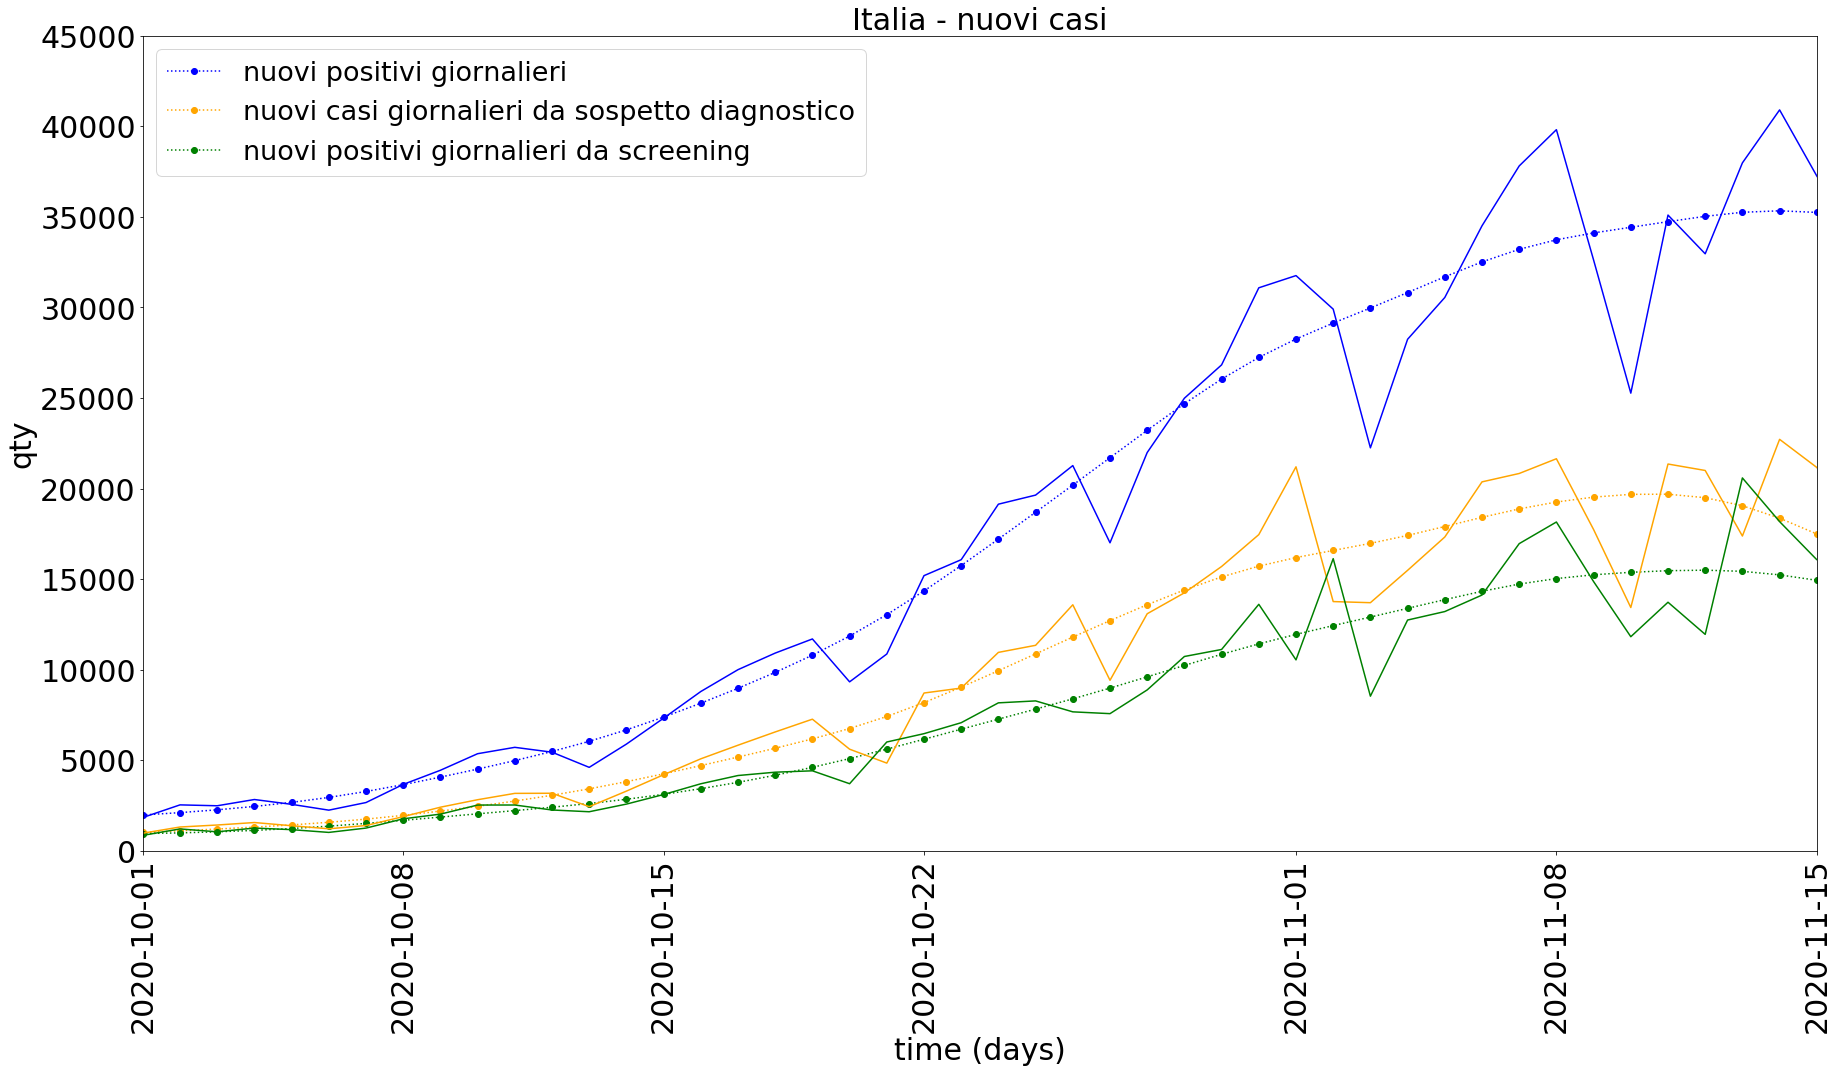

In [108]:
#plt.figure(figsize=(30,30))

fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Italia - nuovi casi', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.tick_params(axis='x', labelrotation=90)
ax1.set_ylabel('qty', fontsize=30)
ax1.set_xlim(datetime(2020,10,1),datetime(2020,11,15))
ax1.set_ylim(0,45000)

ax1.plot(italy_raw_data.data, italy_raw_data.nuovi_positivi_smoothed, 
         label='nuovi positivi giornalieri', color='blue', linestyle=':', marker='o')
ax1.plot(italy_raw_data.data, italy_raw_data.nuovi_casi_da_sospetto_diagnostico_smoothed, 
         label='nuovi casi giornalieri da sospetto diagnostico', color='orange', linestyle=':', marker='o')
ax1.plot(italy_raw_data.data, italy_raw_data.nuovi_casi_da_screening_smoothed, 
         label='nuovi positivi giornalieri da screening', color='green', linestyle=':', marker='o')

ax1.plot(italy_raw_data.data, italy_raw_data.nuovi_positivi, color='blue')
ax1.plot(italy_raw_data.data, italy_raw_data.nuovi_casi_da_sospetto_diagnostico, color='orange')
ax1.plot(italy_raw_data.data, italy_raw_data.nuovi_casi_da_screening, color='green')


ax1.legend(fontsize=27,loc='upper left')